In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Least squares
The folder ElectionsEconomy contains the data for the example in Section 7.1.
Load these data, type in the R function `rss()` from page 104, and evaluate it at several different values of $ (a, b) $.
Make two graphs: a plot of the sum of squares of residuals as a funciton of $a$, with $b$ fixed at its least squares estimate given in Section 7.1, and a plot of the sum of squares of residuals as a function of $ b$, with $a$ fixed at its least squares estimate.
Confirm that the residual sum of squares is indeed minimized at the least squares estimate.

## Read the data

In [4]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table("./data/ElectionsEconomy/hibbs.dat", header=TRUE)

## Calculate the rss of different fits

In [5]:
rss <- function(x, y, a, b) {
    resid <- y - (a + b * x)
    sum(resid^2)
}

In [6]:
as <- seq(0, 100, by=0.1)
bs <- seq(0, 10, by=0.01)

In [7]:
rss_fits <- expand.grid(a=as, b=bs) %>% rowwise() %>% mutate(resid = rss(hibbs$growth, hibbs$vote, a, b))

## Find the minimiser of rss

In [8]:
min_rss <- rss_fits %>% arrange(resid) %>% head(1)

In [9]:
a_min = min_rss$a[1]
b_min = min_rss$b[1]
c(a_min, b_min)

[1] 46.20  3.08

## Plot residuals as function of a

It's a parabola

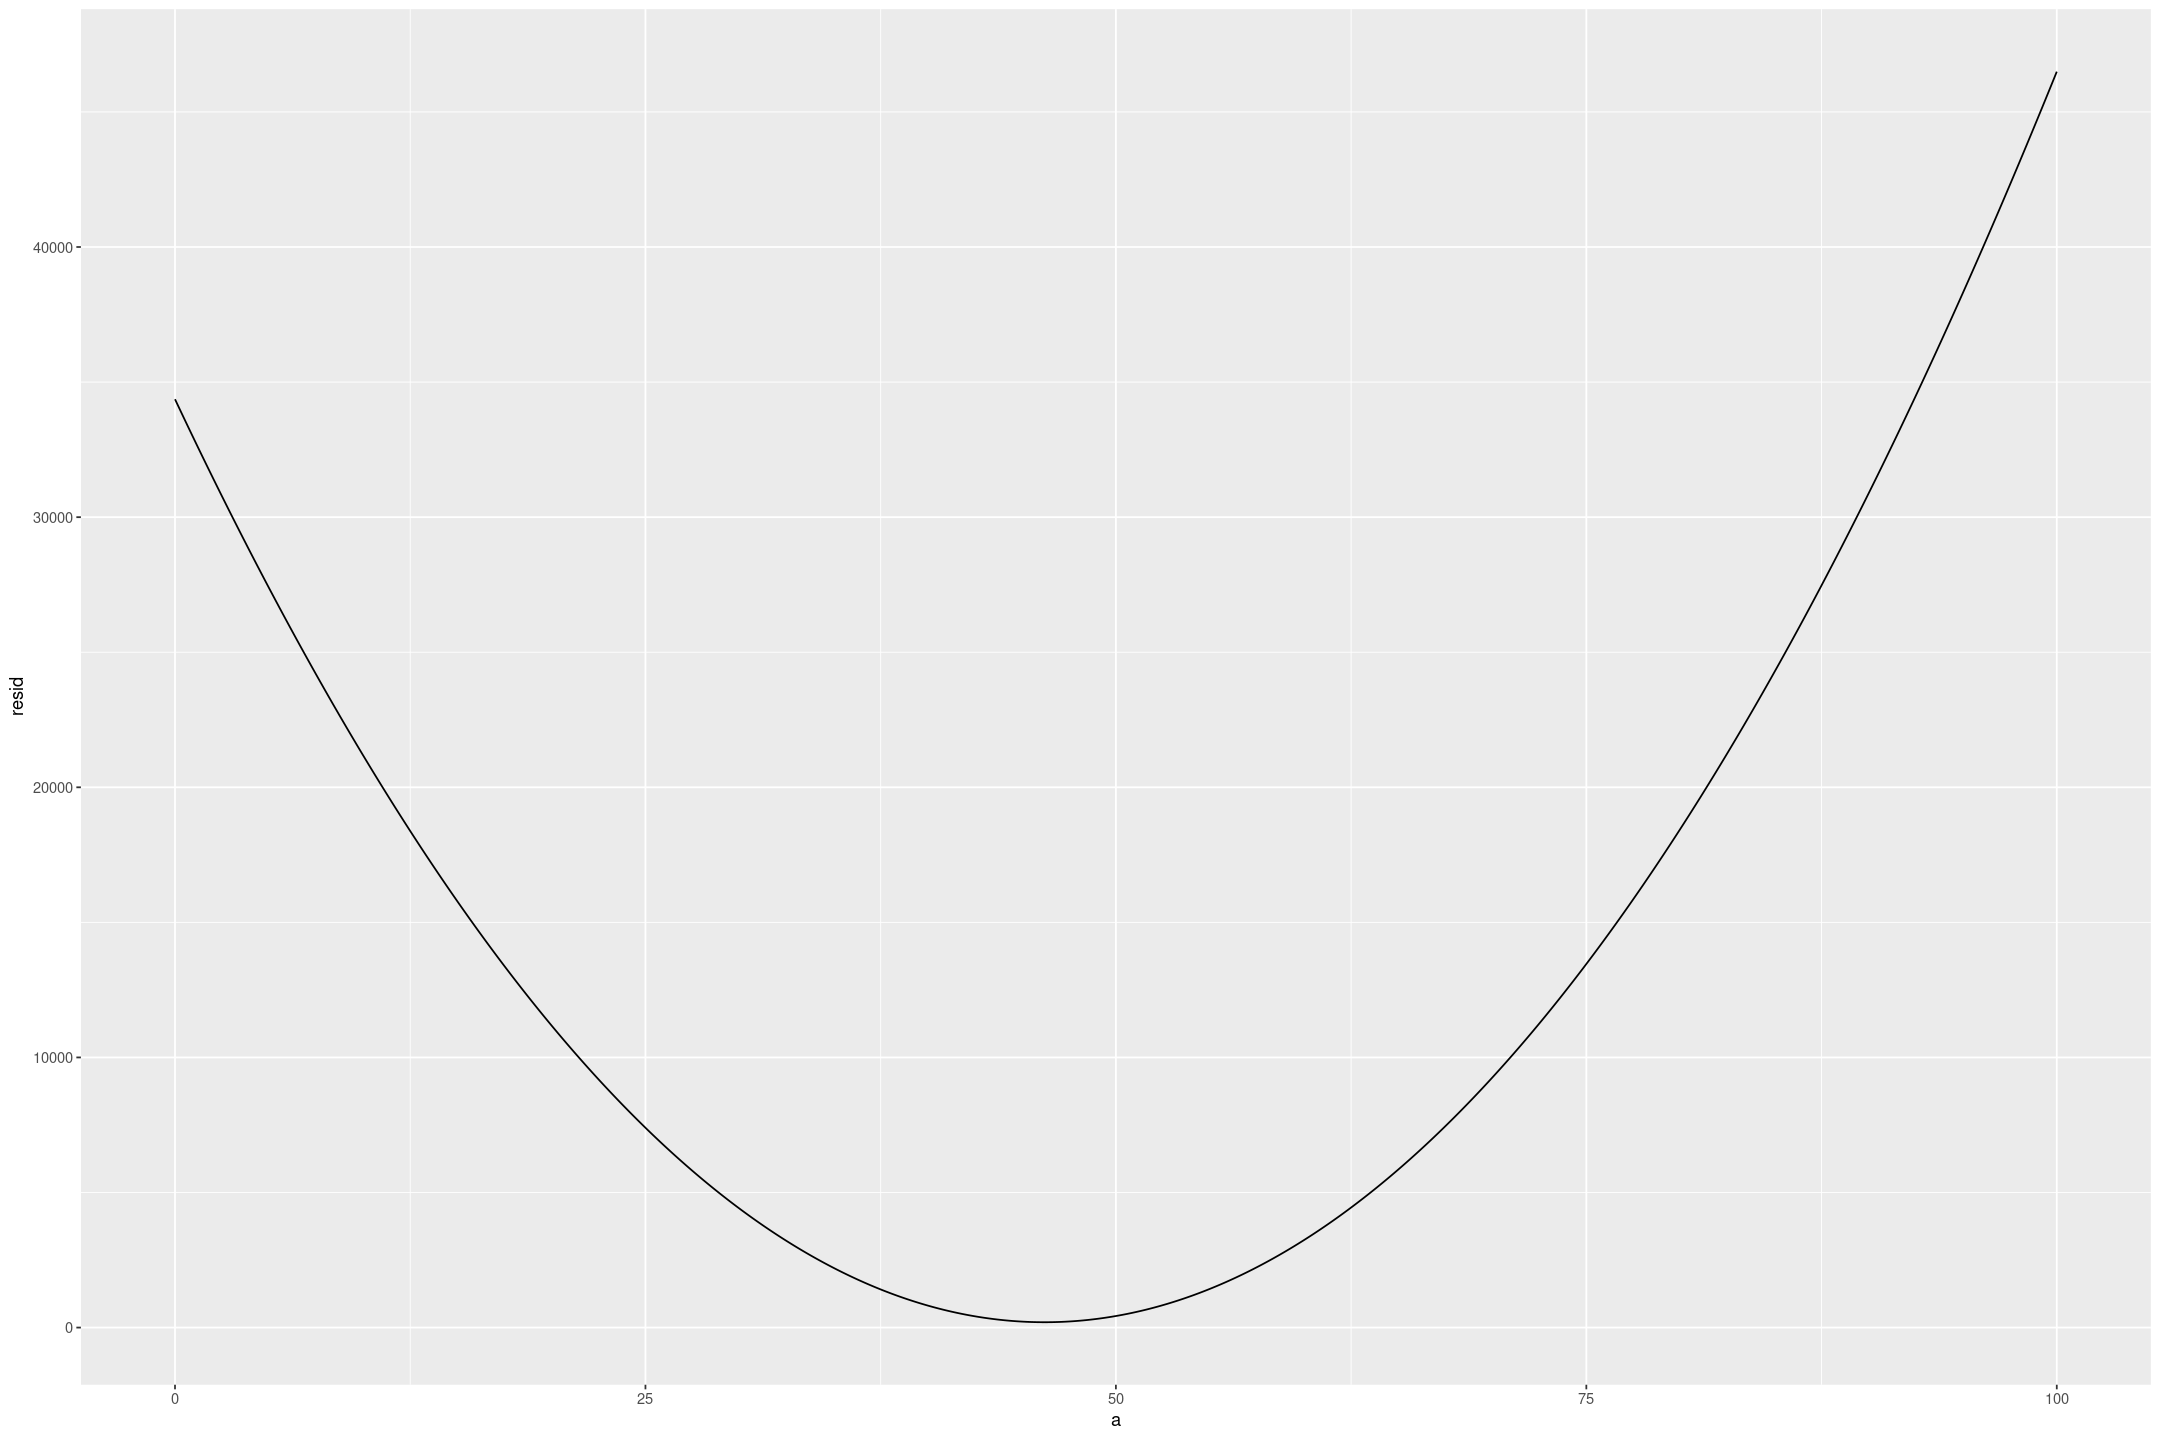

In [10]:
rss_fits %>% filter(b == b_min) %>% gf_line(resid ~ a)

## Plot residuals as function of b

It's another parabola

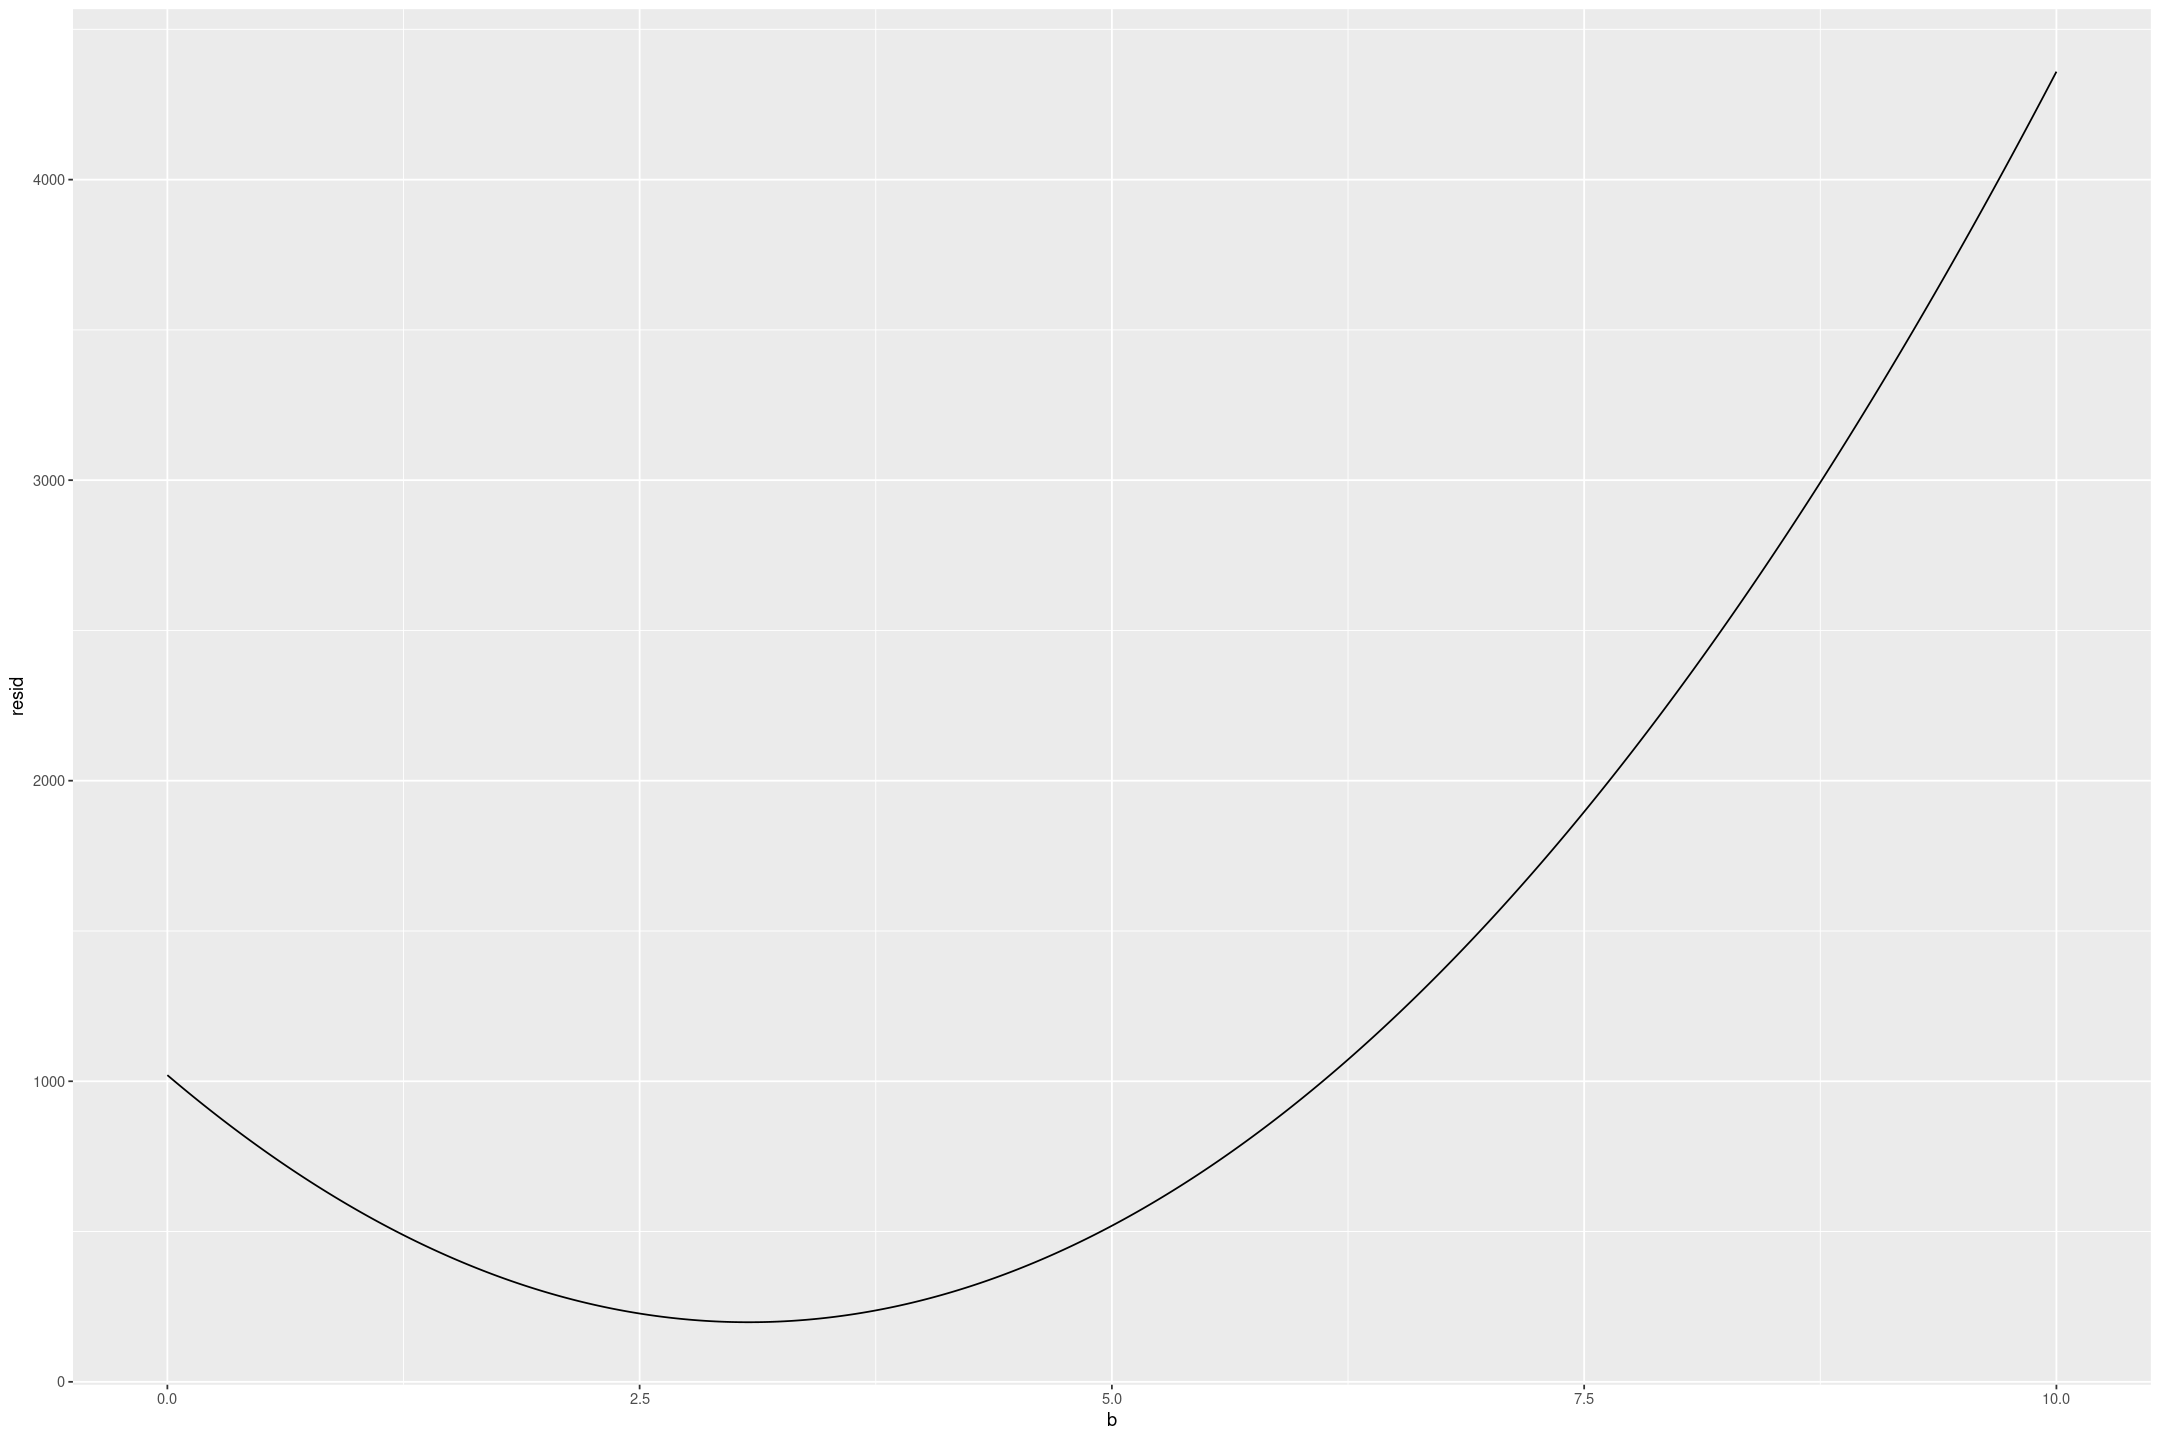

In [11]:
rss_fits %>% filter(a == a_min) %>% gf_line(resid ~ b)

## Combining the plots

It looks like a parabolic surface

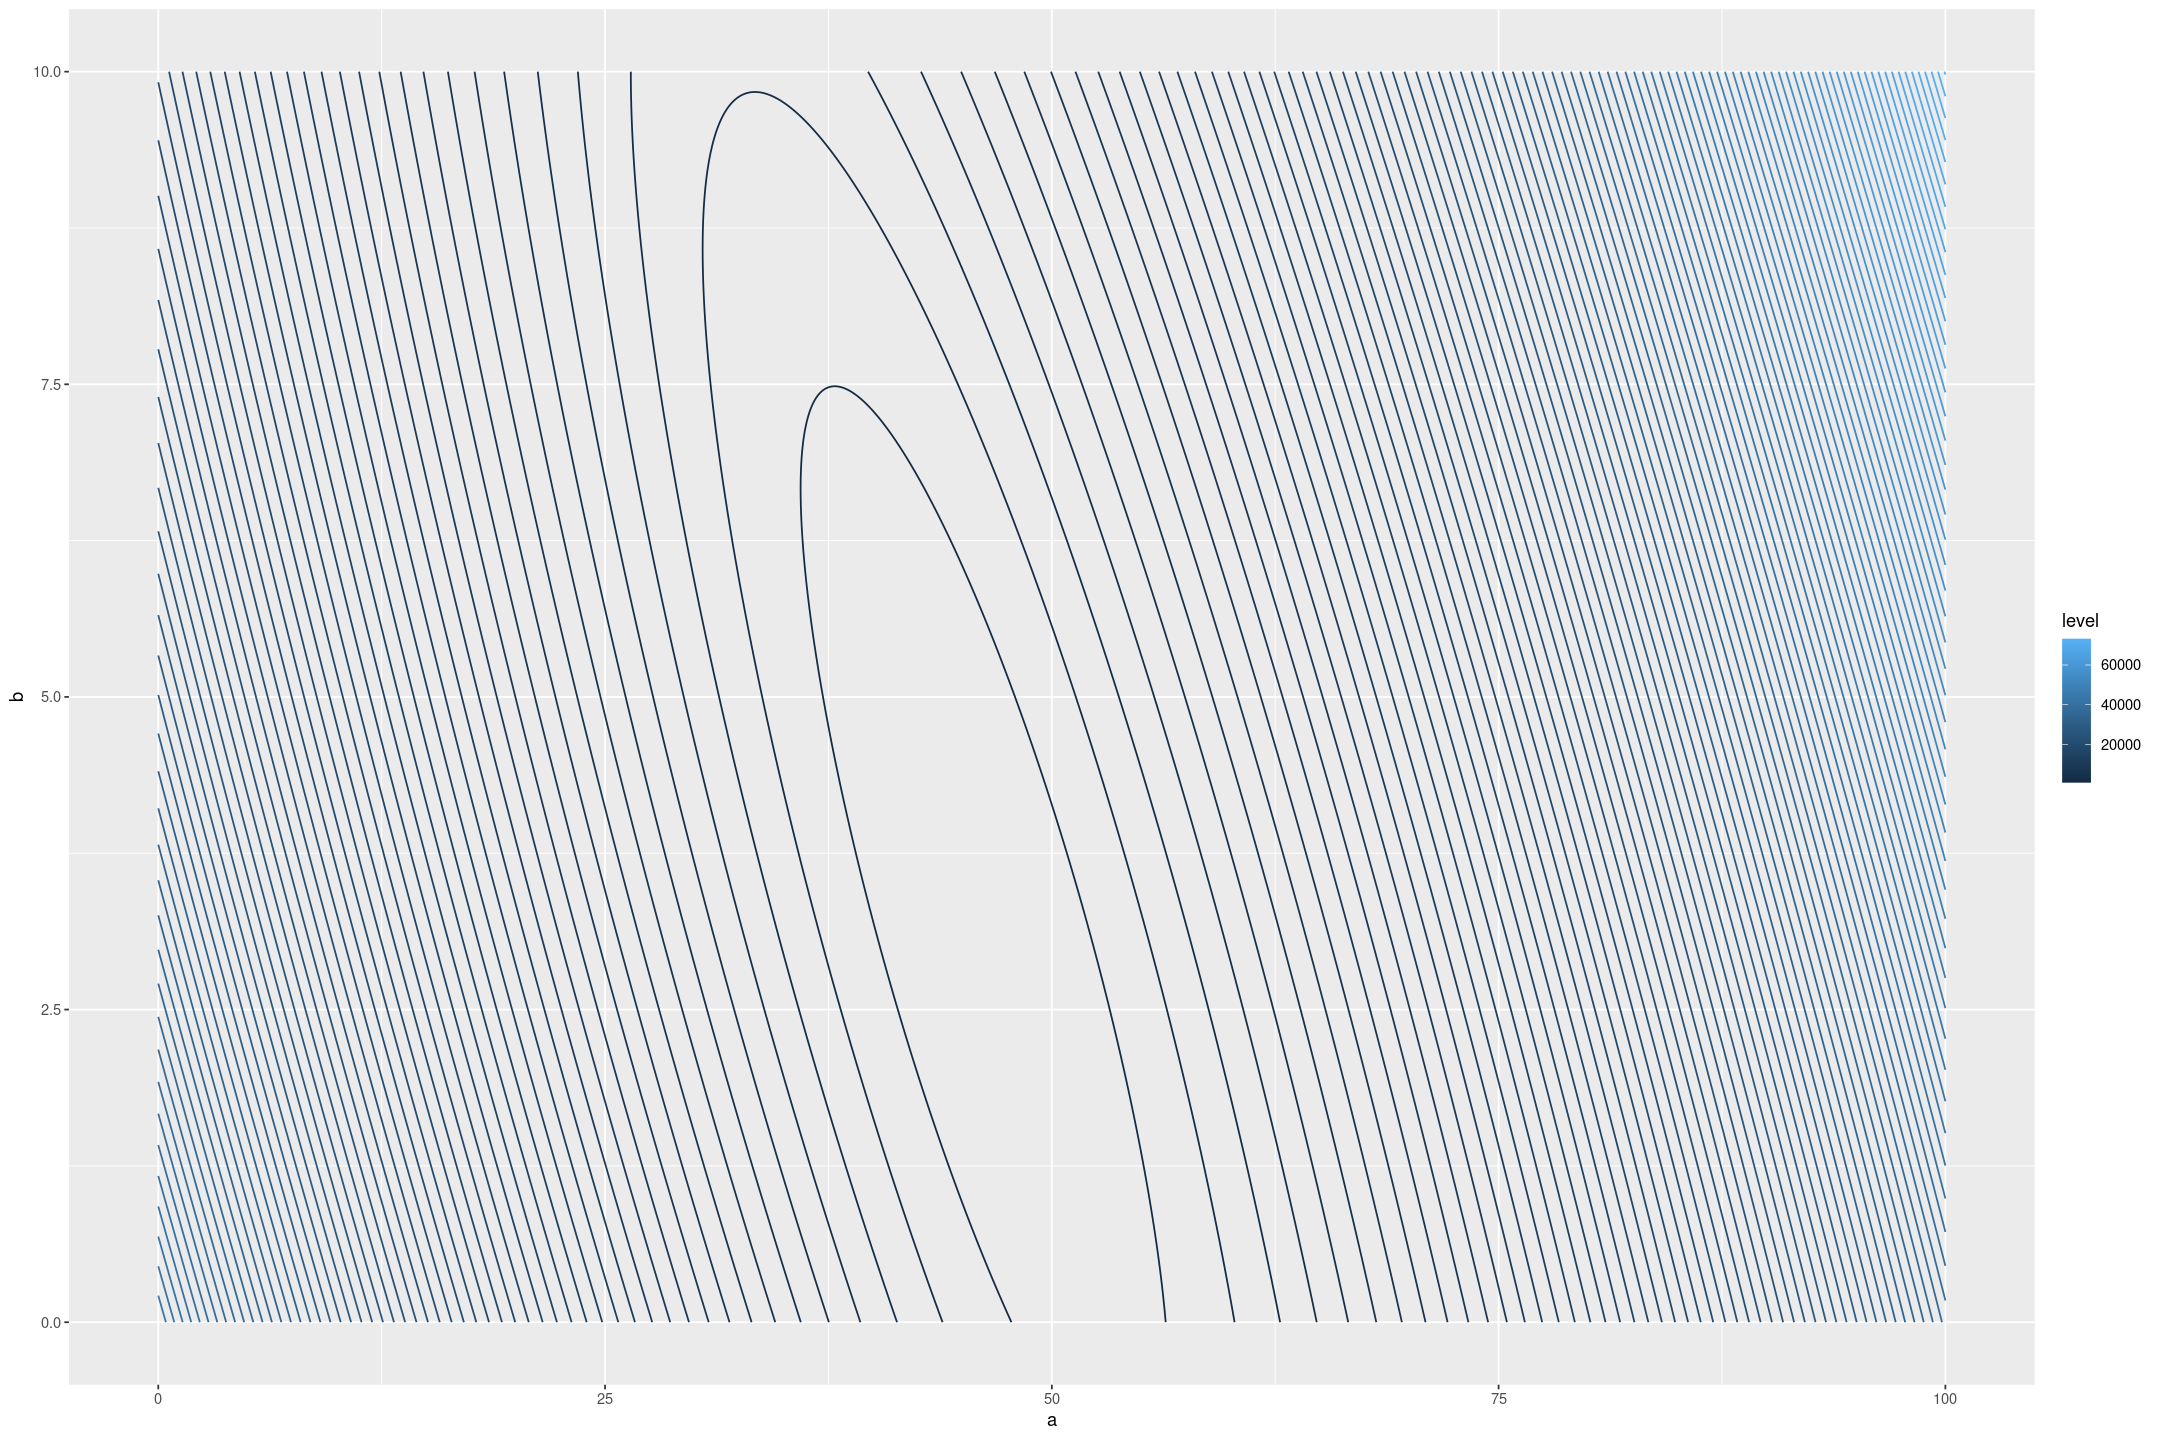

In [12]:
rss_fits %>% ggplot(mapping=aes(x=a, y=b, z=resid)) + 
geom_contour(bins=100, aes(colour = after_stat(level)))

# Maximum likelihood
Repeat the previous exercise but this time write a function, similar to `rss()` on page 104, that computes the logarithm of the likelihood (8.6) as a function of the data and the parameters $ a, b, \sigma$.
Evaluate this function at several values of these parameters, and make a plot demonstrating that it is maximized at the values computed from the formulas in the text (with $\sigma$ computed using $\frac{1}{n}$, not $\frac{1}{n-2}$; see page 104).

## Define the Log Likelihood function

In [13]:
normal_logliklihood <- function(x, y, a, b, sigma) {
    ypred <- a + b*x
    N <- length(y)
    - N * log(sigma) - sum((y - ypred)^2)/(2 * sigma^2) - N/2 * log(2*pi)
}

### Check a random point

In [14]:
normal_logliklihood(0.8, 1, 0.5, 0.2, 0.1)

[1] -4.396353

In [15]:
log(dnorm(1, 0.5 + 0.2*0.8, 0.1))

[1] -4.396353

In [16]:
normal_logliklihood(c(0.8, 0.8), c(1,1), 0.5, 0.2, 0.1)

[1] -8.792707

## Check the parameters are at the maximum loglikelihood

Equations from p 104

In [17]:
x <- hibbs$growth
y <- hibbs$vote

b_min <- sum((x - mean(x)) * y) / sum((x-mean(x))^2)
a_min <- mean(y) - b_min * mean(x)
s_min <- (1/length(y) * sum((y - (a_min + b_min * x))^2))^(1/2)

In [18]:
c(a_min, b_min, s_min)

[1] 46.247648  3.060528  3.520233

In [19]:
max_ll <- normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, s_min)
max_ll

[1] -42.83945

## Check along a

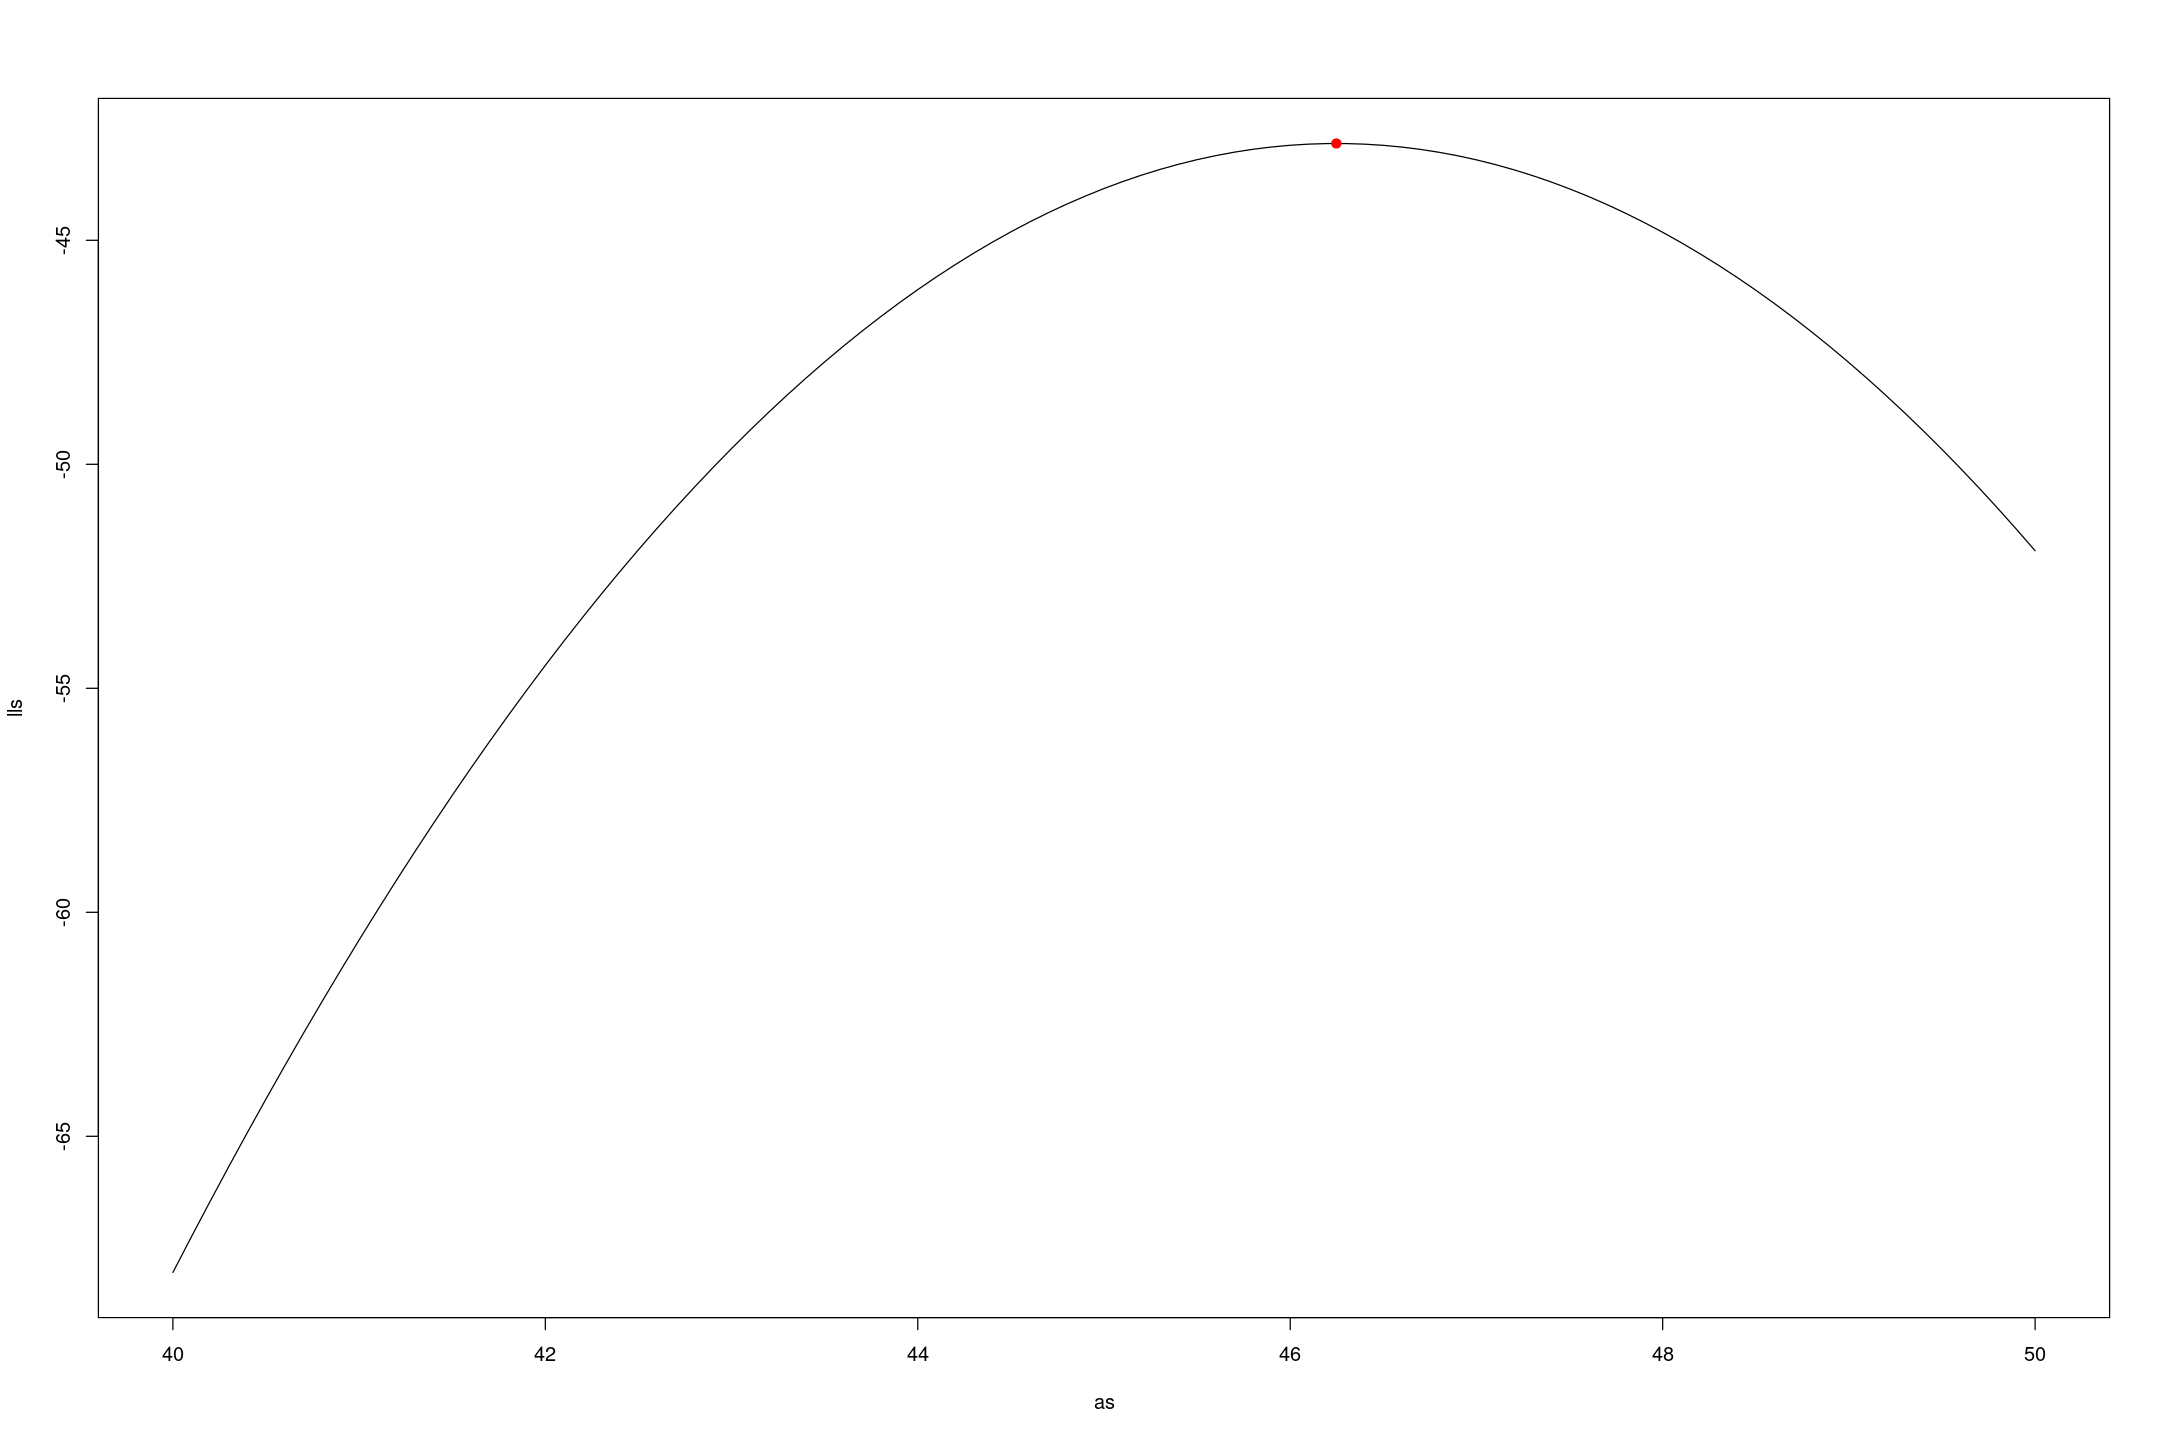

In [20]:
as <- seq(40, 50, by=0.1)
lls <- vapply(as, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, x, b_min, s_min), double(1))
plot(as, lls, type='l')
points(a_min, max_ll, pch=19, col='red')

The minimum is very near what we expect

In [21]:
c(as[which.max(lls)], a_min)

[1] 46.20000 46.24765

## Check along b

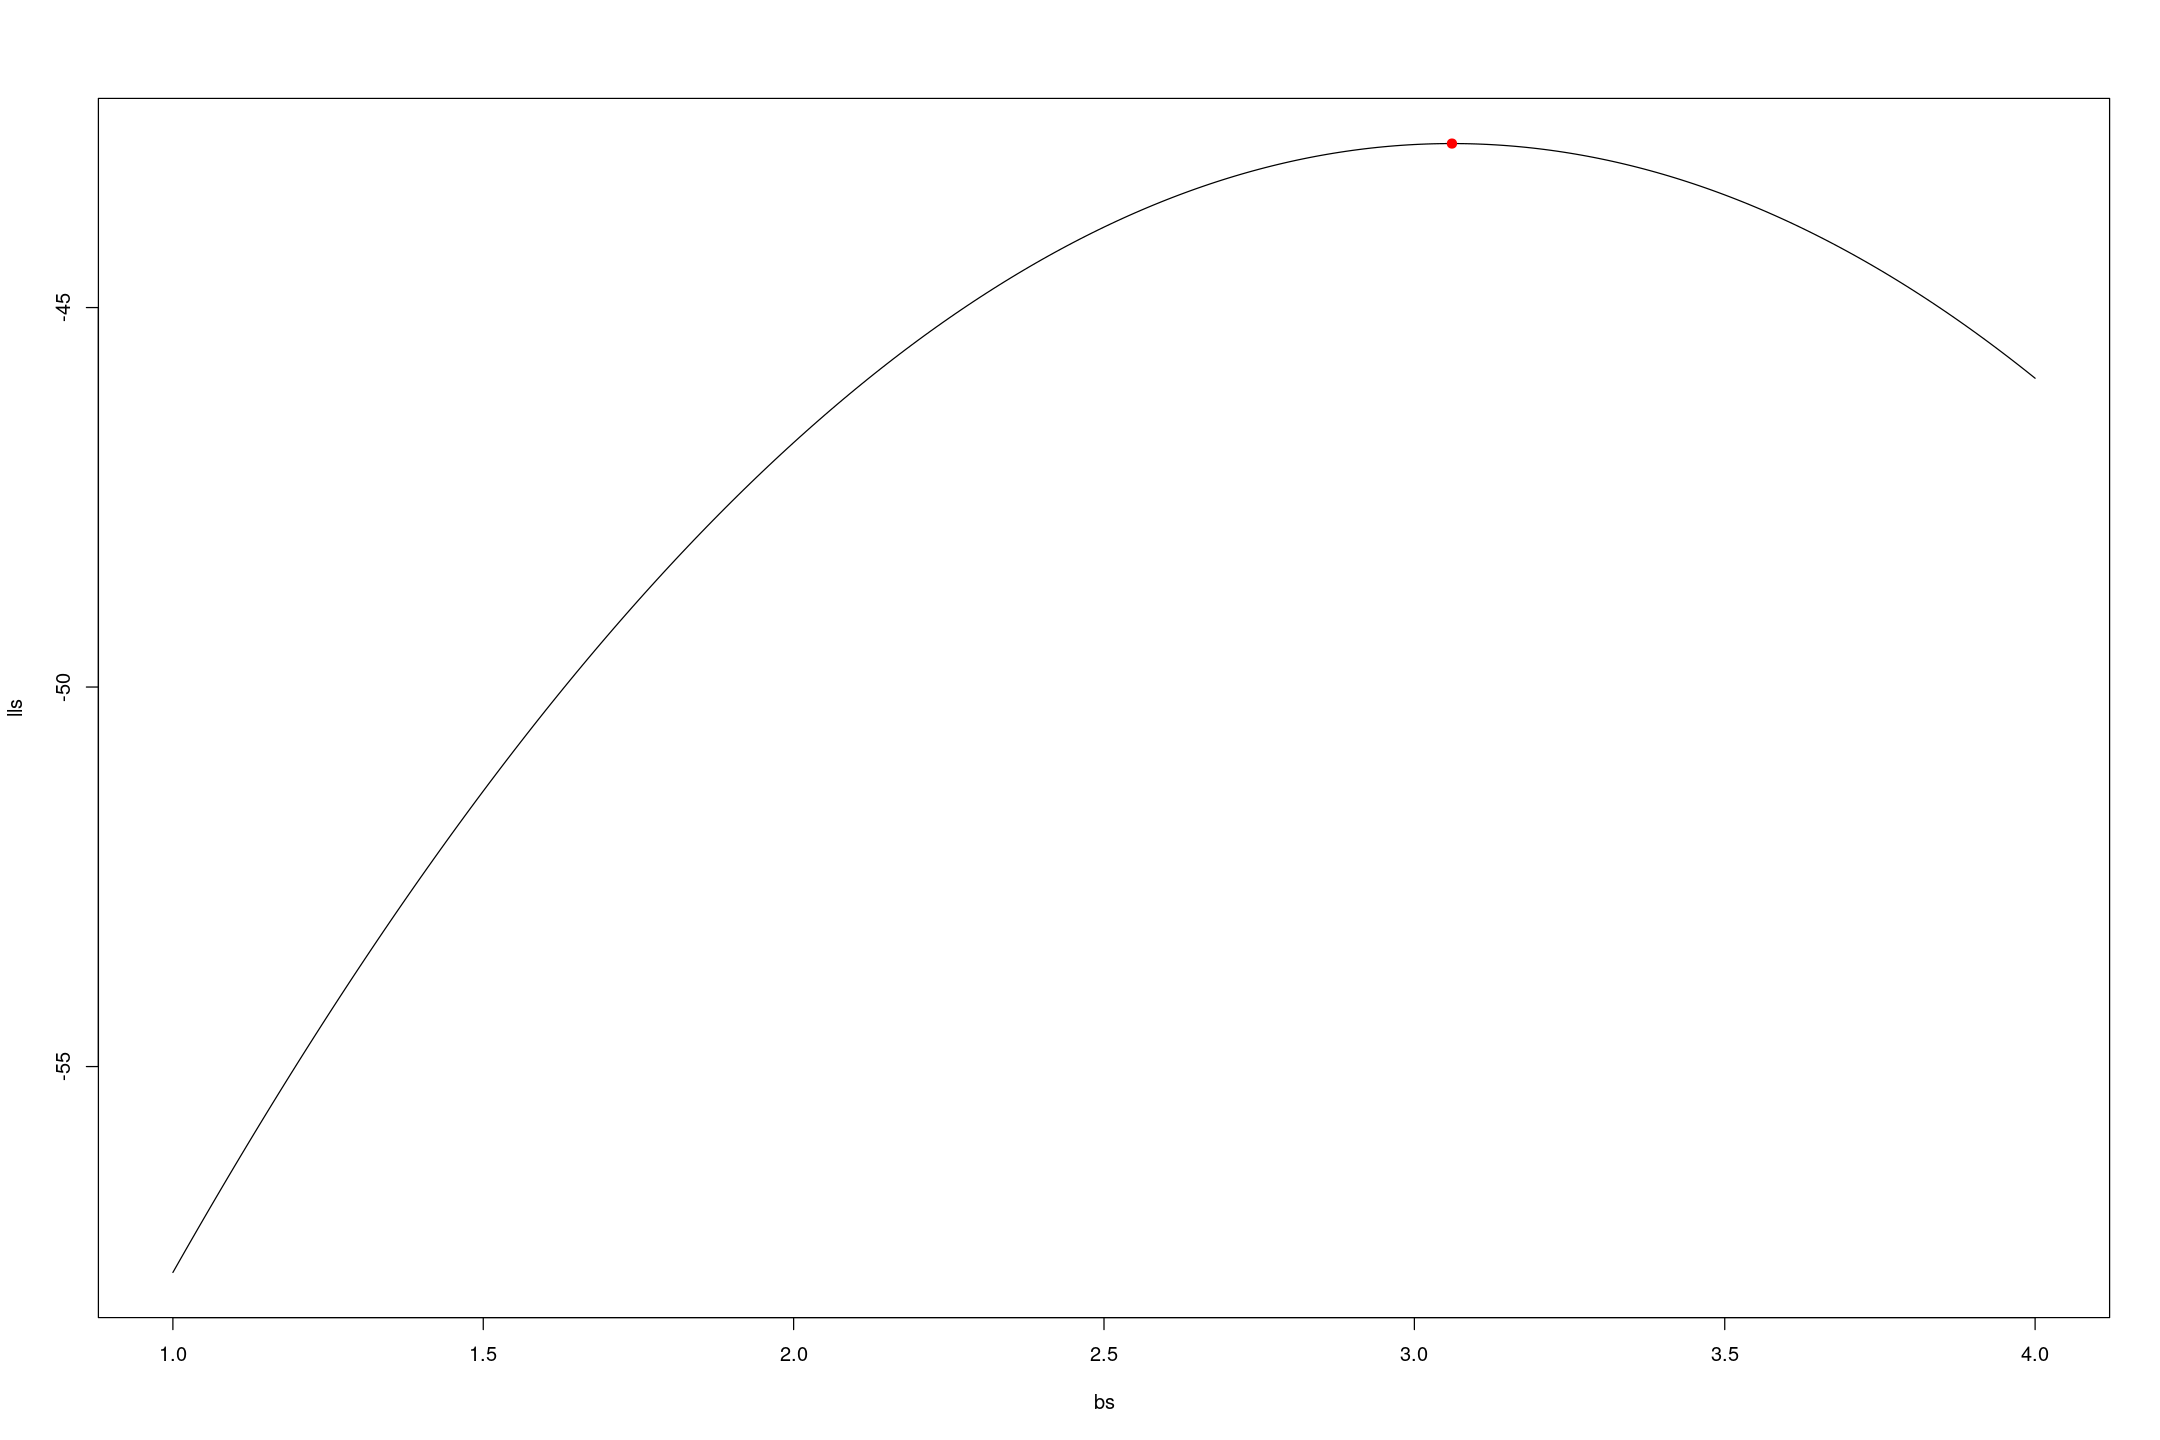

In [22]:
bs <- seq(1, 4, by=0.01)
lls <- vapply(bs, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, a_min, x, s_min), double(1))
plot(bs, lls, type='l')
points(b_min, max_ll, pch=19, col='red')

It's pretty close to what we expect the extremum to be

In [23]:
c(bs[which.max(lls)], b_min)

[1] 3.060000 3.060528

## Sigma

Notice if we use the estimate that corrects for overfitting it doesn't maximise loglikelihood

In [24]:
s_min_adjusted = (1/(length(y)-2) * sum((y - (a_min + b_min * x))^2))^(1/2)
s_min_adjusted

[1] 3.763288

In [25]:
s_adjusted_ll <- normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, s_min_adjusted)
c(s_adjusted_ll, max_ll)

[1] -42.90770 -42.83945

### Plotting

We can see that the curve is a lot less steep, and so there's going to be more uncertainty in sigma

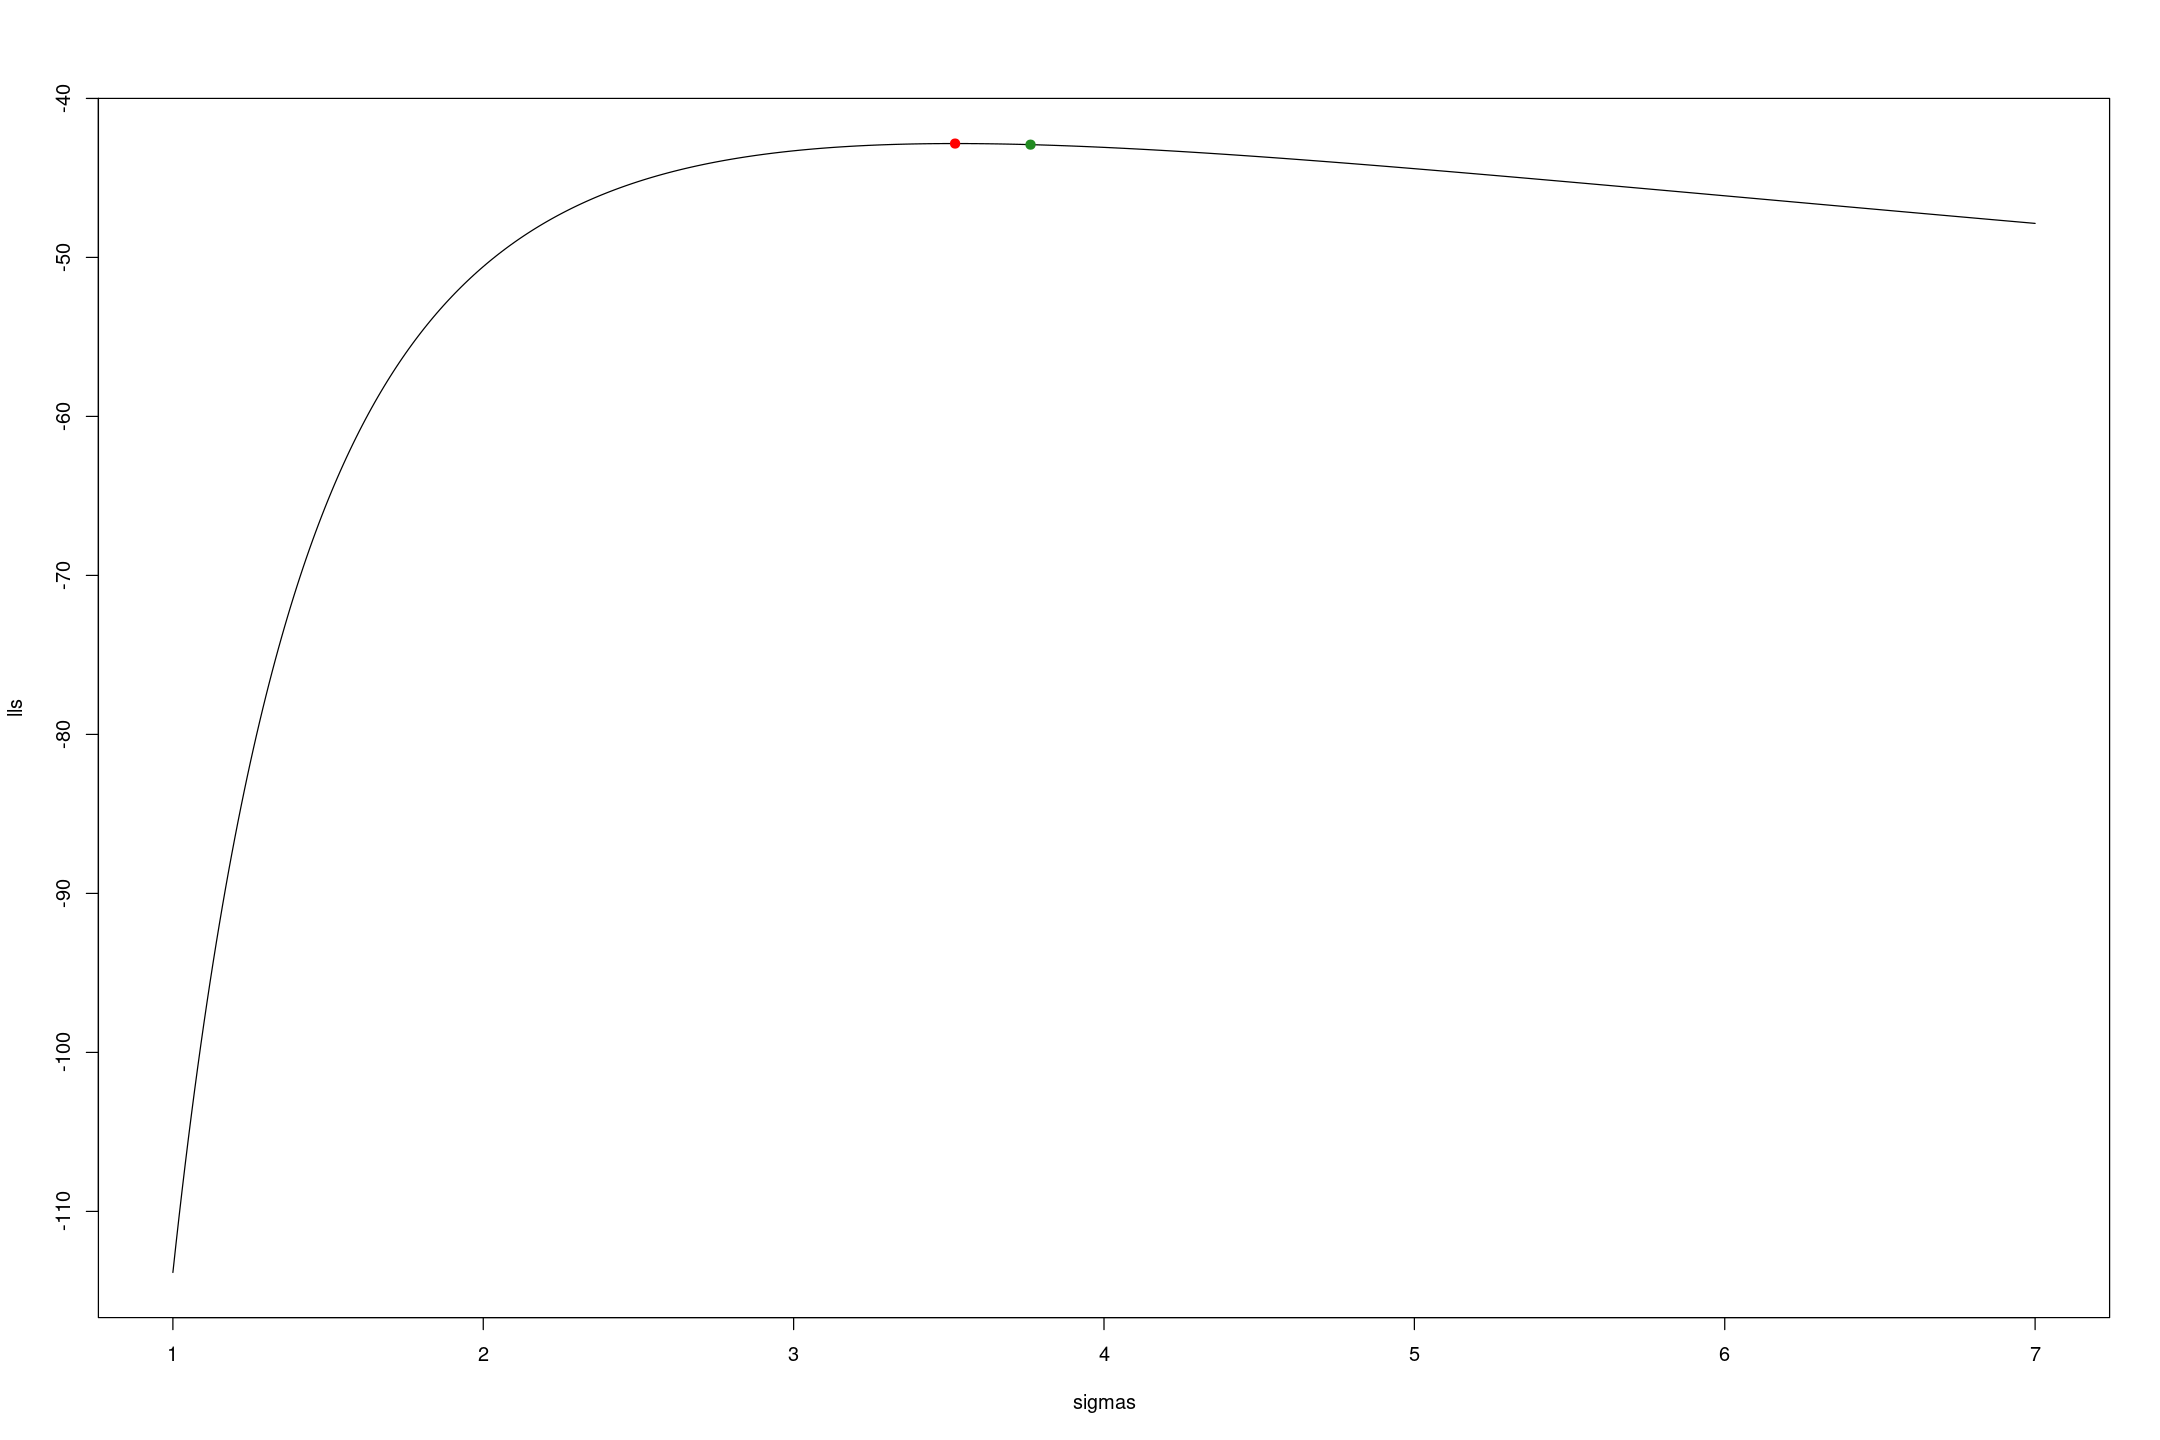

In [26]:
sigmas <- seq(1, 7, by=0.01)
lls <- vapply(sigmas, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, x), double(1))
plot(sigmas, lls, type='l')
points(s_min, max_ll, pch=19, col='red')
points(s_min_adjusted, s_adjusted_ll, pch=19, col='forestgreen')

In [27]:
c(sigmas[which.max(lls)], s_min)

[1] 3.520000 3.520233

In [28]:
s_min_adjusted

[1] 3.763288

# Least absolute deviation
Repeat 8.1, but instead of calculating and minimizing the sum of squares of residuals, do this for the sum of absolute values of residuals.
Find the $(a, b)$ that minimizes the sum of absolute values of residuals, and plot the sum of absolute values of residuals as a function of a and of b.
Compare the least squares and least absolute deviation estimates of $(a, b)$.

## Calculating the sums of absolute values of residuals

In [29]:
absolute_residual <- function(x, y, a, b) {
    resid <- y - (a + b * x)
    sum(abs(resid))
}

## Calculating the fits for a range of values of a and b

In [30]:
absolute_residual_fits <- expand.grid(a=as, b=bs) %>% rowwise() %>% mutate(resid = absolute_residual(hibbs$growth, hibbs$vote, a, b))

## Plot the contour lines

We can see the optimum happens somewhere near b=3.5, a=46

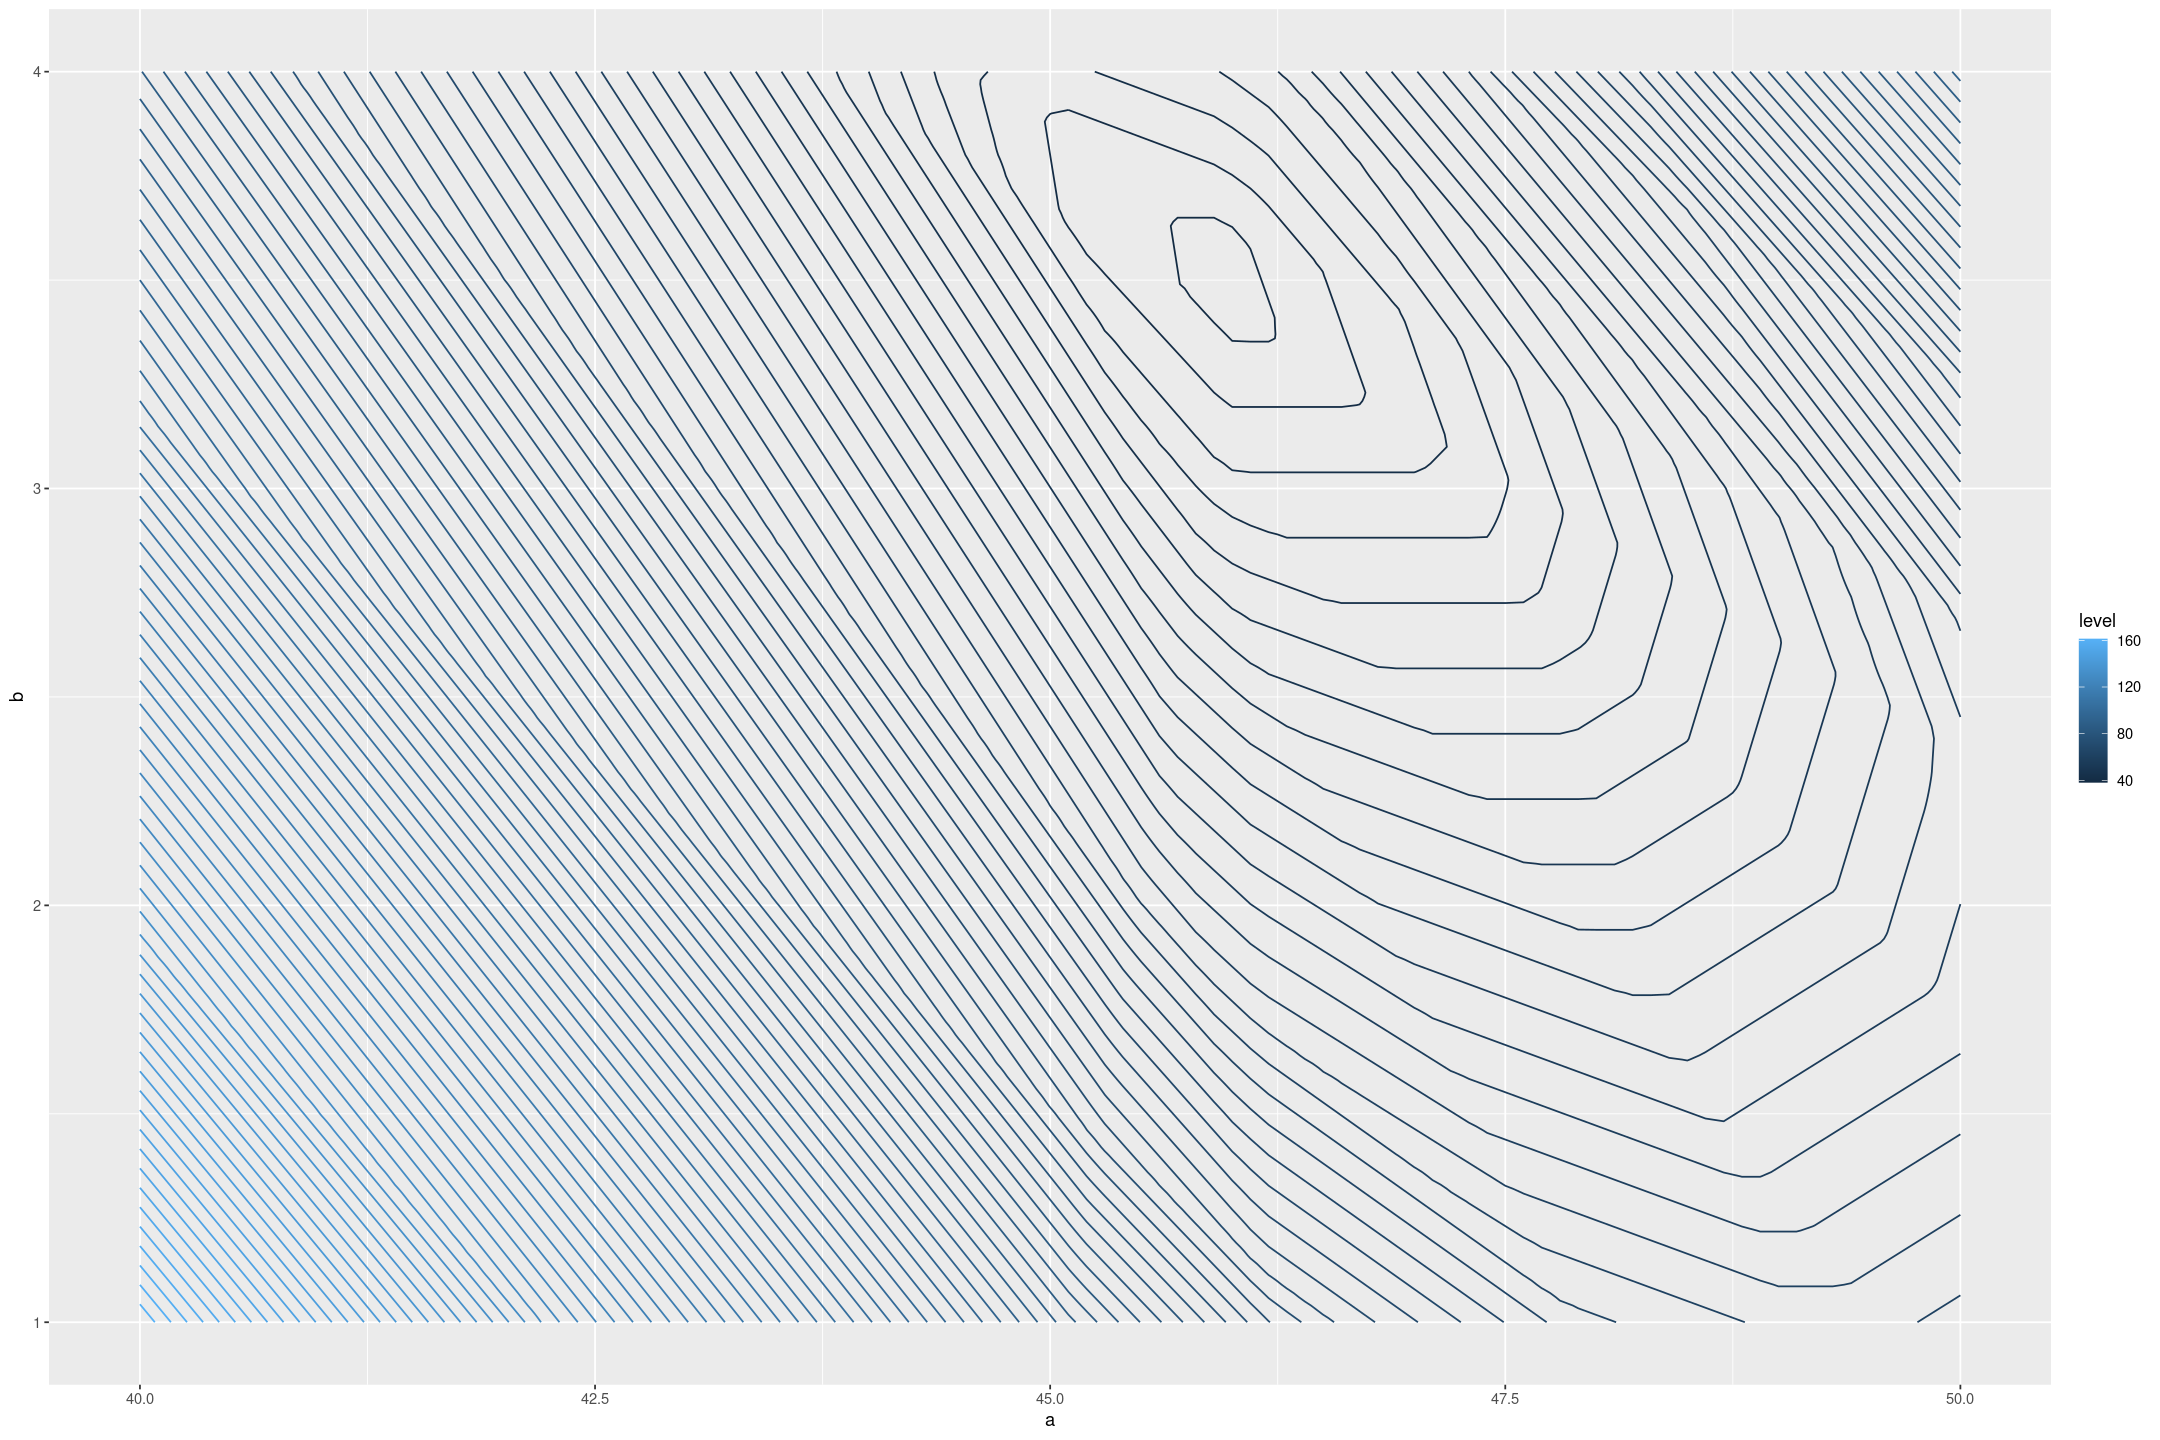

In [31]:
absolute_residual_fits %>% ggplot(mapping=aes(x=a, y=b, z=resid)) + 
geom_contour(bins=100, aes(colour = after_stat(level)))

## Find the minimum

In [32]:
min_absolute_residual <- absolute_residual_fits %>% arrange(resid) %>% head(1)

In [33]:
a_abs_min = min_absolute_residual$a[1]
b_abs_min = min_absolute_residual$b[1]
c(a_abs_min, b_abs_min)

[1] 46.00  3.49

In [34]:
c(a_min, b_min)

[1] 46.247648  3.060528

## Plot the residuals around the minimum

These increase less steeply far from the minimum

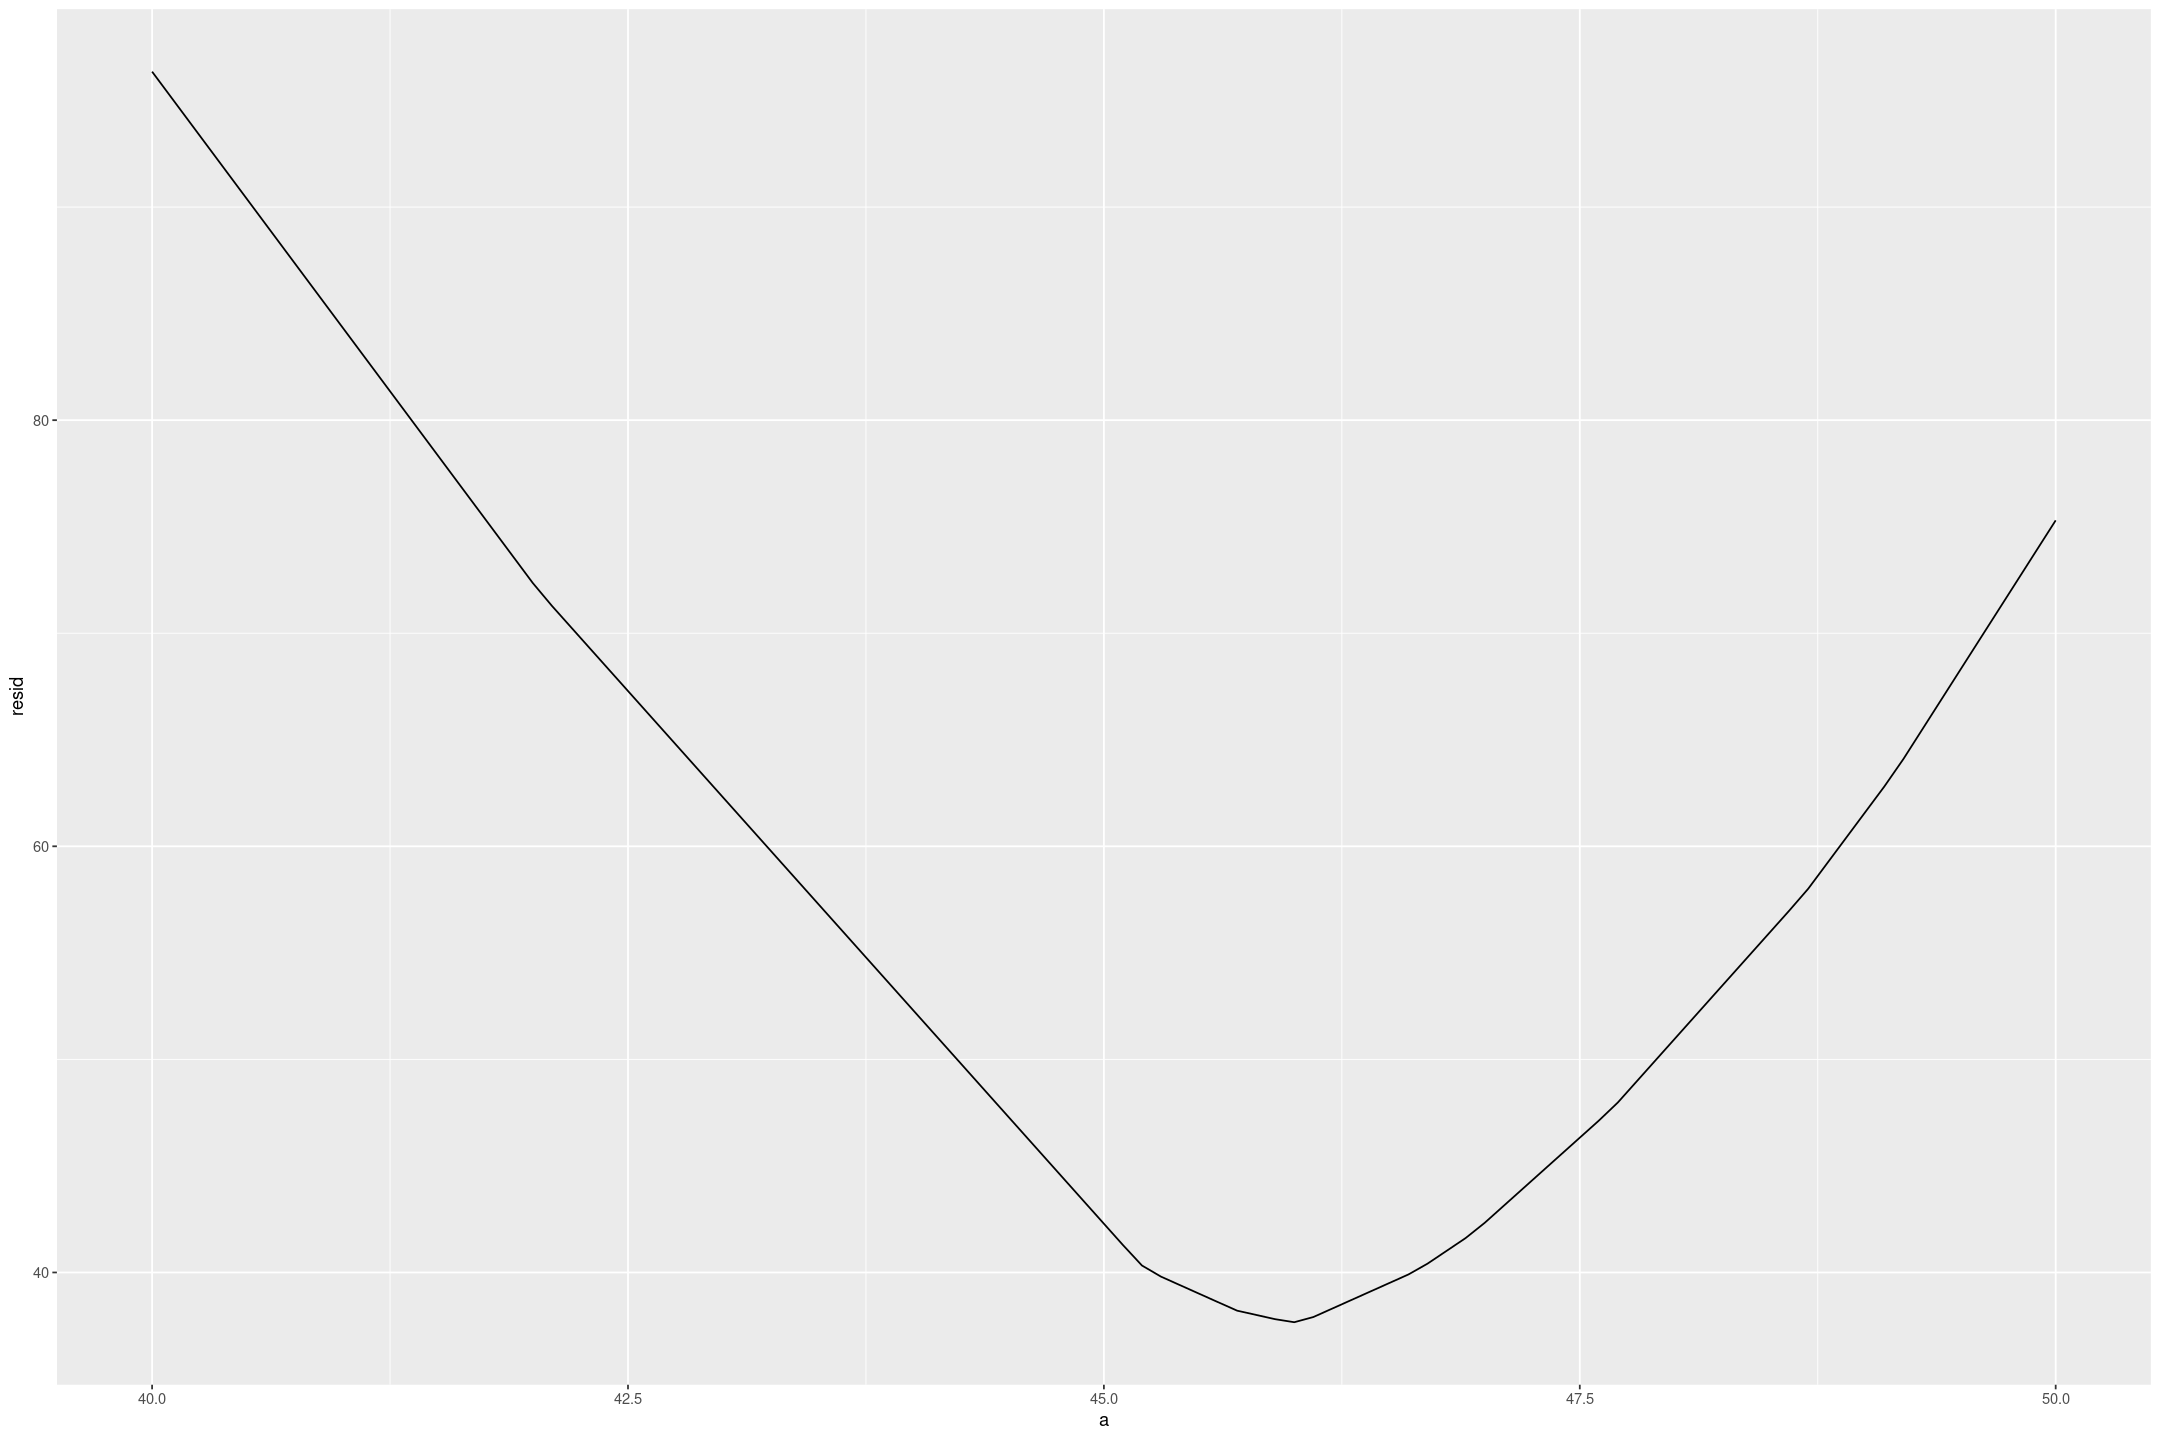

In [35]:
absolute_residual_fits %>% filter(b == b_abs_min) %>% gf_line(resid ~ a)

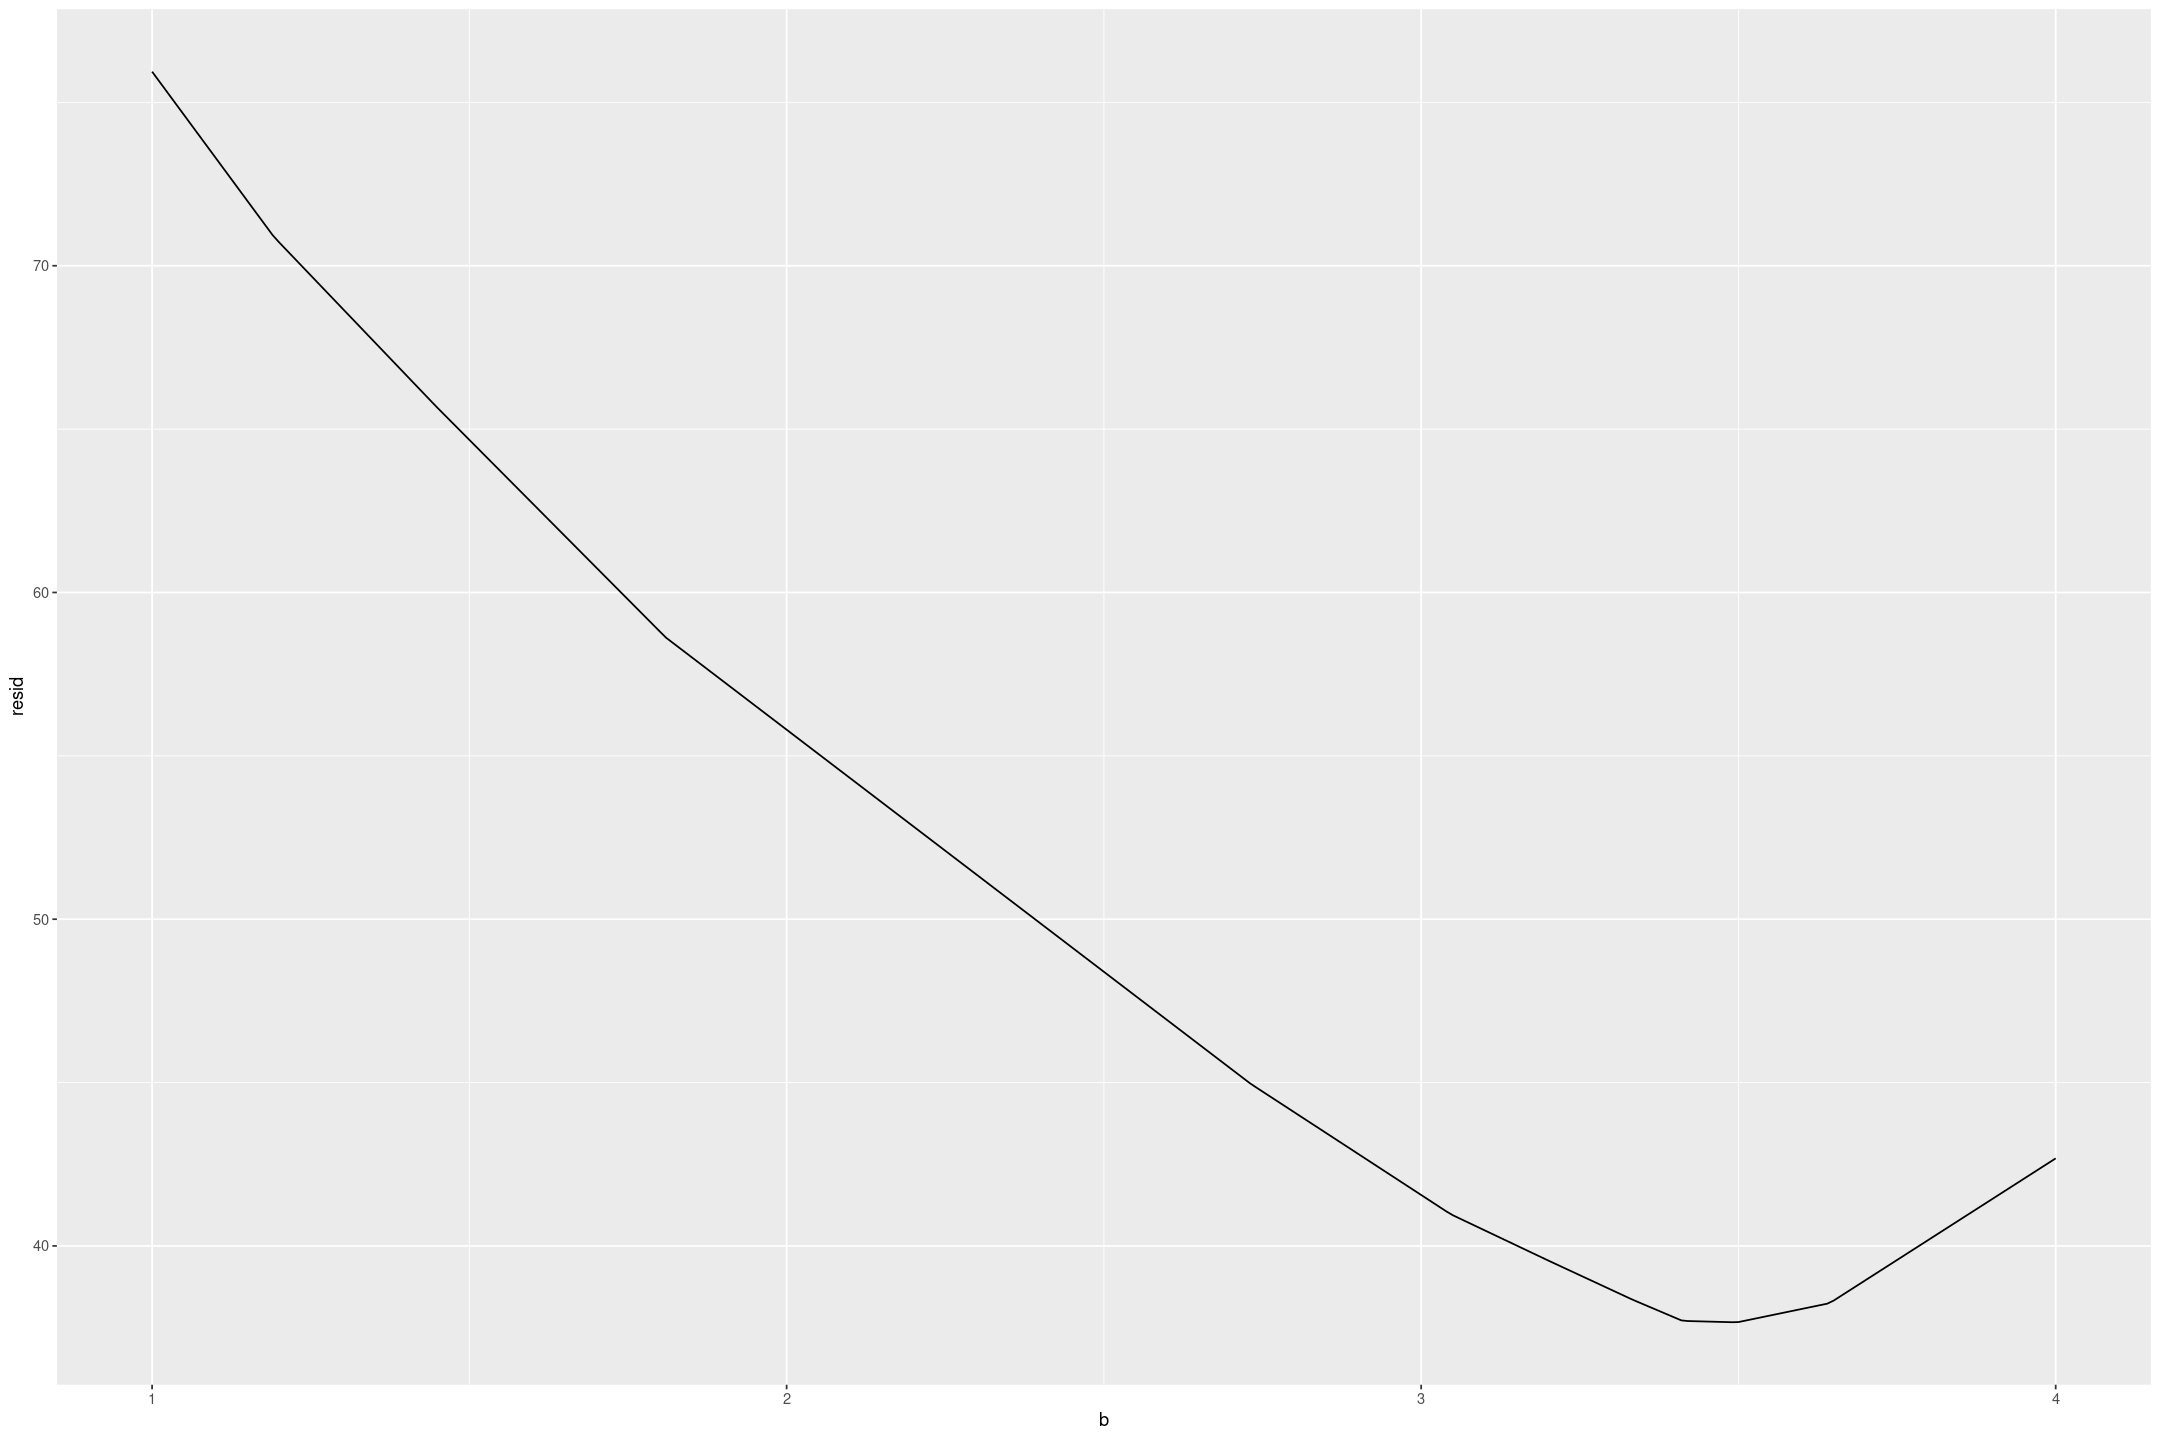

In [36]:
absolute_residual_fits %>% filter(a == a_abs_min) %>% gf_line(resid ~ b)

## Plot the fit lines on the original data

Draw the line minimising residual sum of squares in red, and sum of absolute values in blue.

In [37]:
c(a_min, b_min)

[1] 46.247648  3.060528

In [38]:
c(a_abs_min, b_abs_min)

[1] 46.00  3.49

Notice the minimiser of sum of squares in blue leans further down towards the outlier at around (2.4, 44)

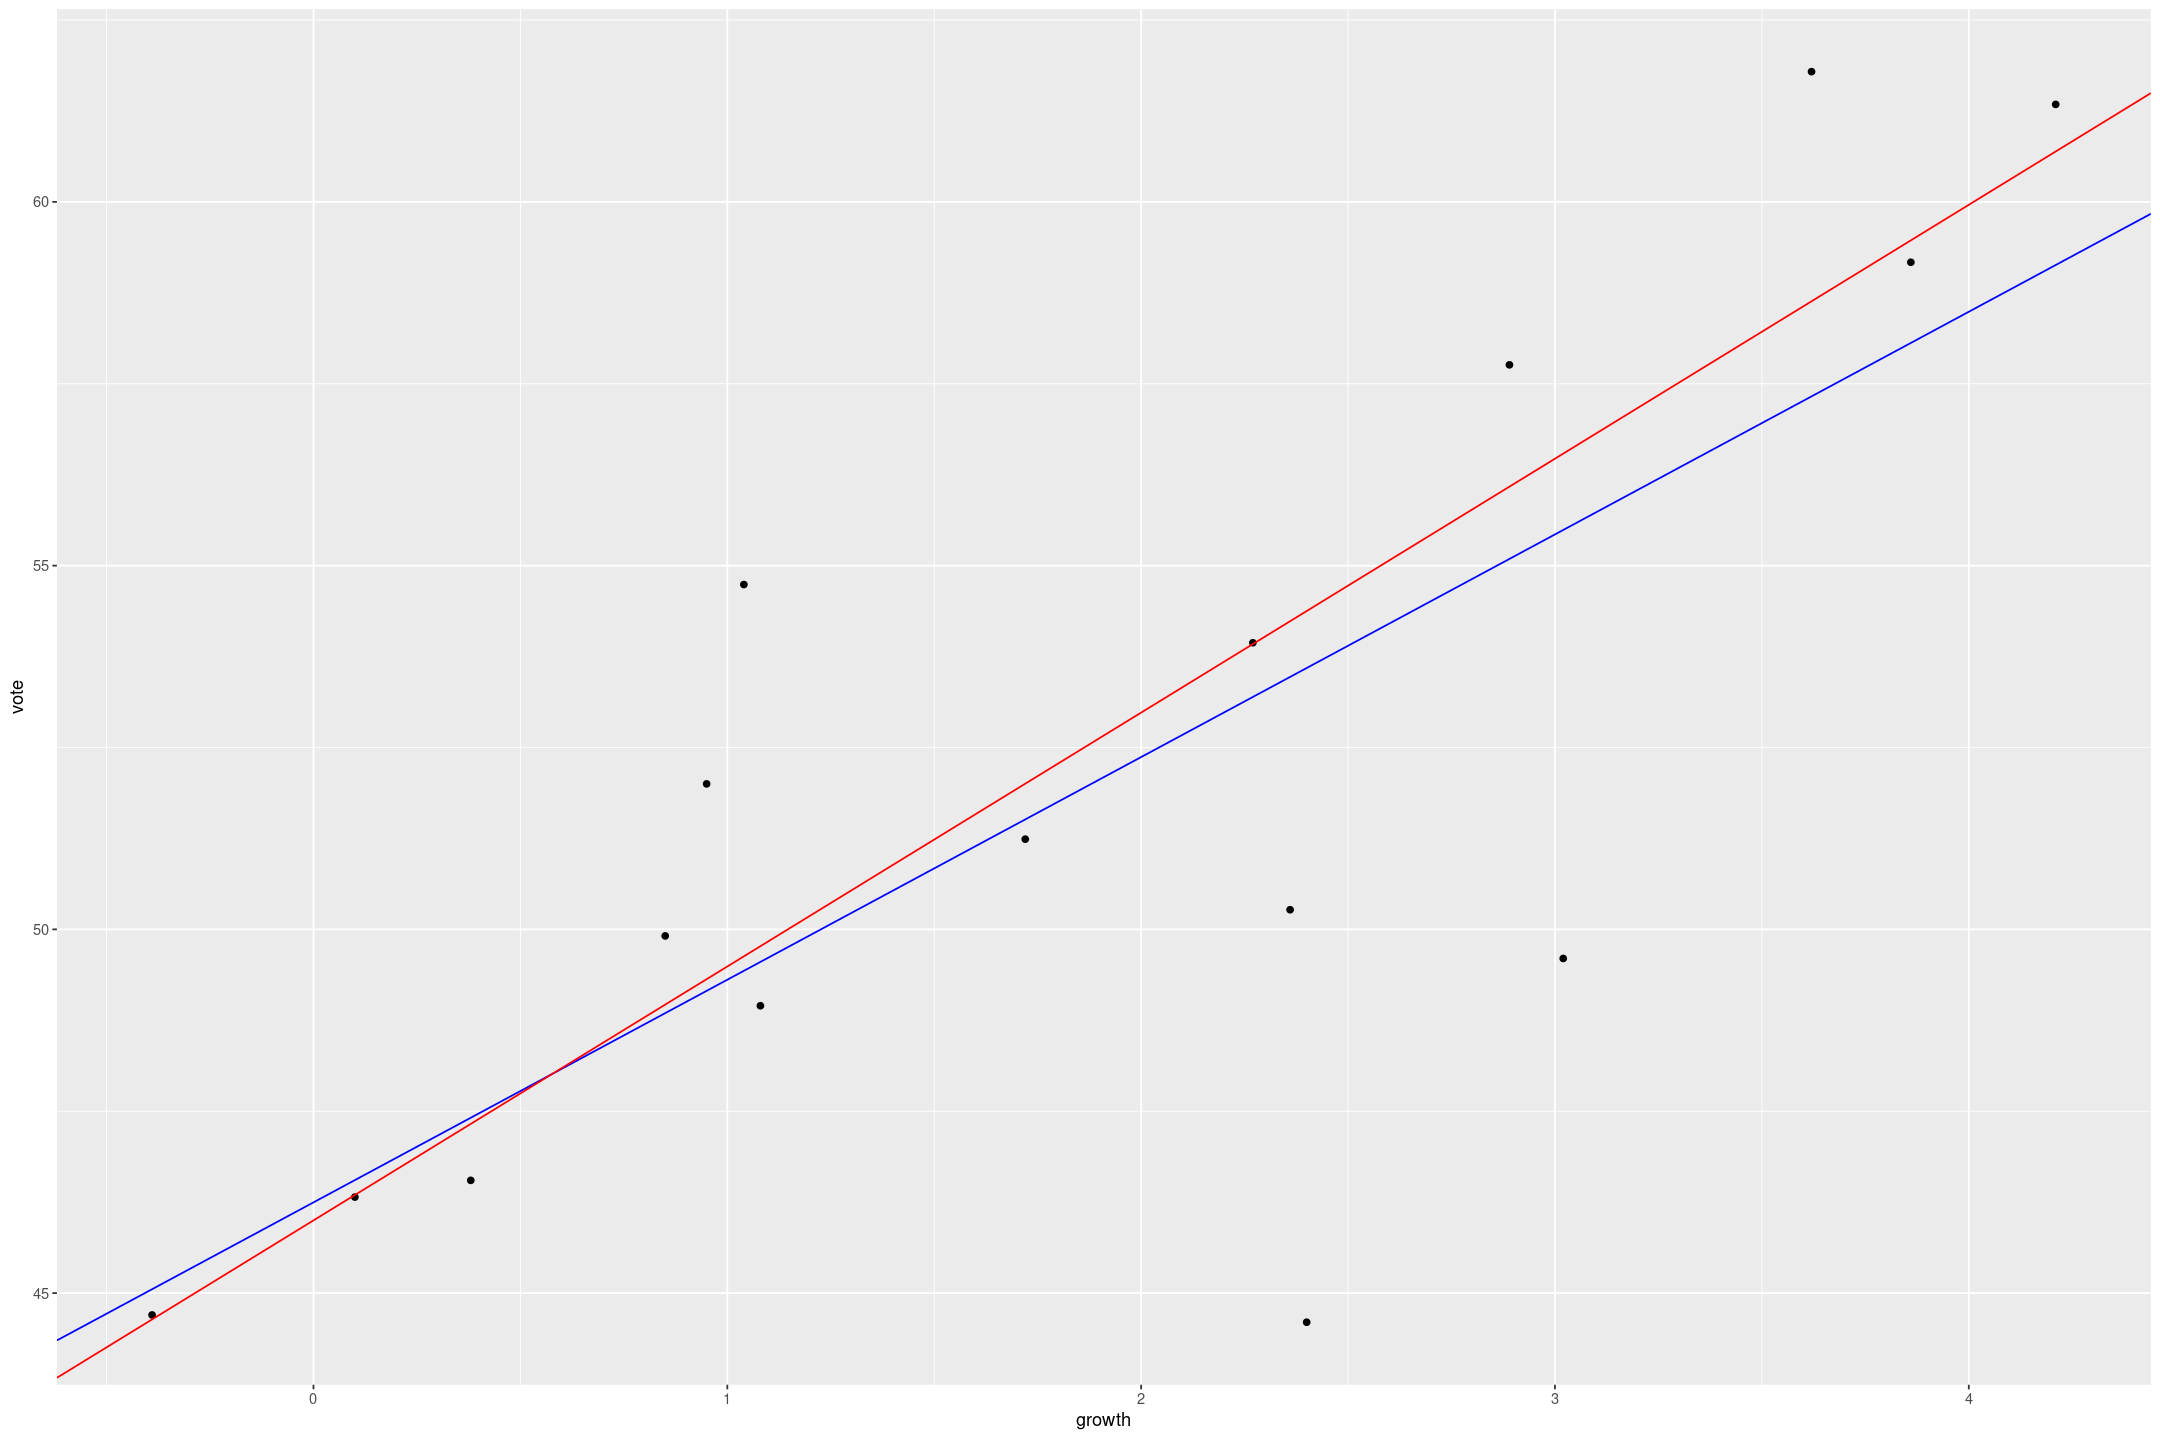

In [39]:
hibbs %>% 
gf_point(vote ~ growth) +
geom_abline(intercept=a_min, slope=b_min, colour="blue") +
geom_abline(intercept=a_abs_min, slope=b_abs_min, colour="red")

# Least squares and least abolute deviation
Construct a set of data $(x, y)_i,\ i = 1,\ldots,n$, for which the least squares and least absolute deviation estimates of $(a, b)$ in the fit, $ y = a + bx$, are much different.
What did you have to do to make this happen?

## Add an outlier to the data

The least squares penalises outliers quadratically, whereas the least absolute deviation penalises them linearly.
So large outliers will move the least squares estimate by large amounts, but the least absolute deviation by small amounts.

Let's add an outlier in the lower right corner to drag down the RSS line.

In [40]:
hibbs_outlier_growth = c(hibbs$growth, 4)
hibbs_outlier_vote = c(hibbs$vote, 40)

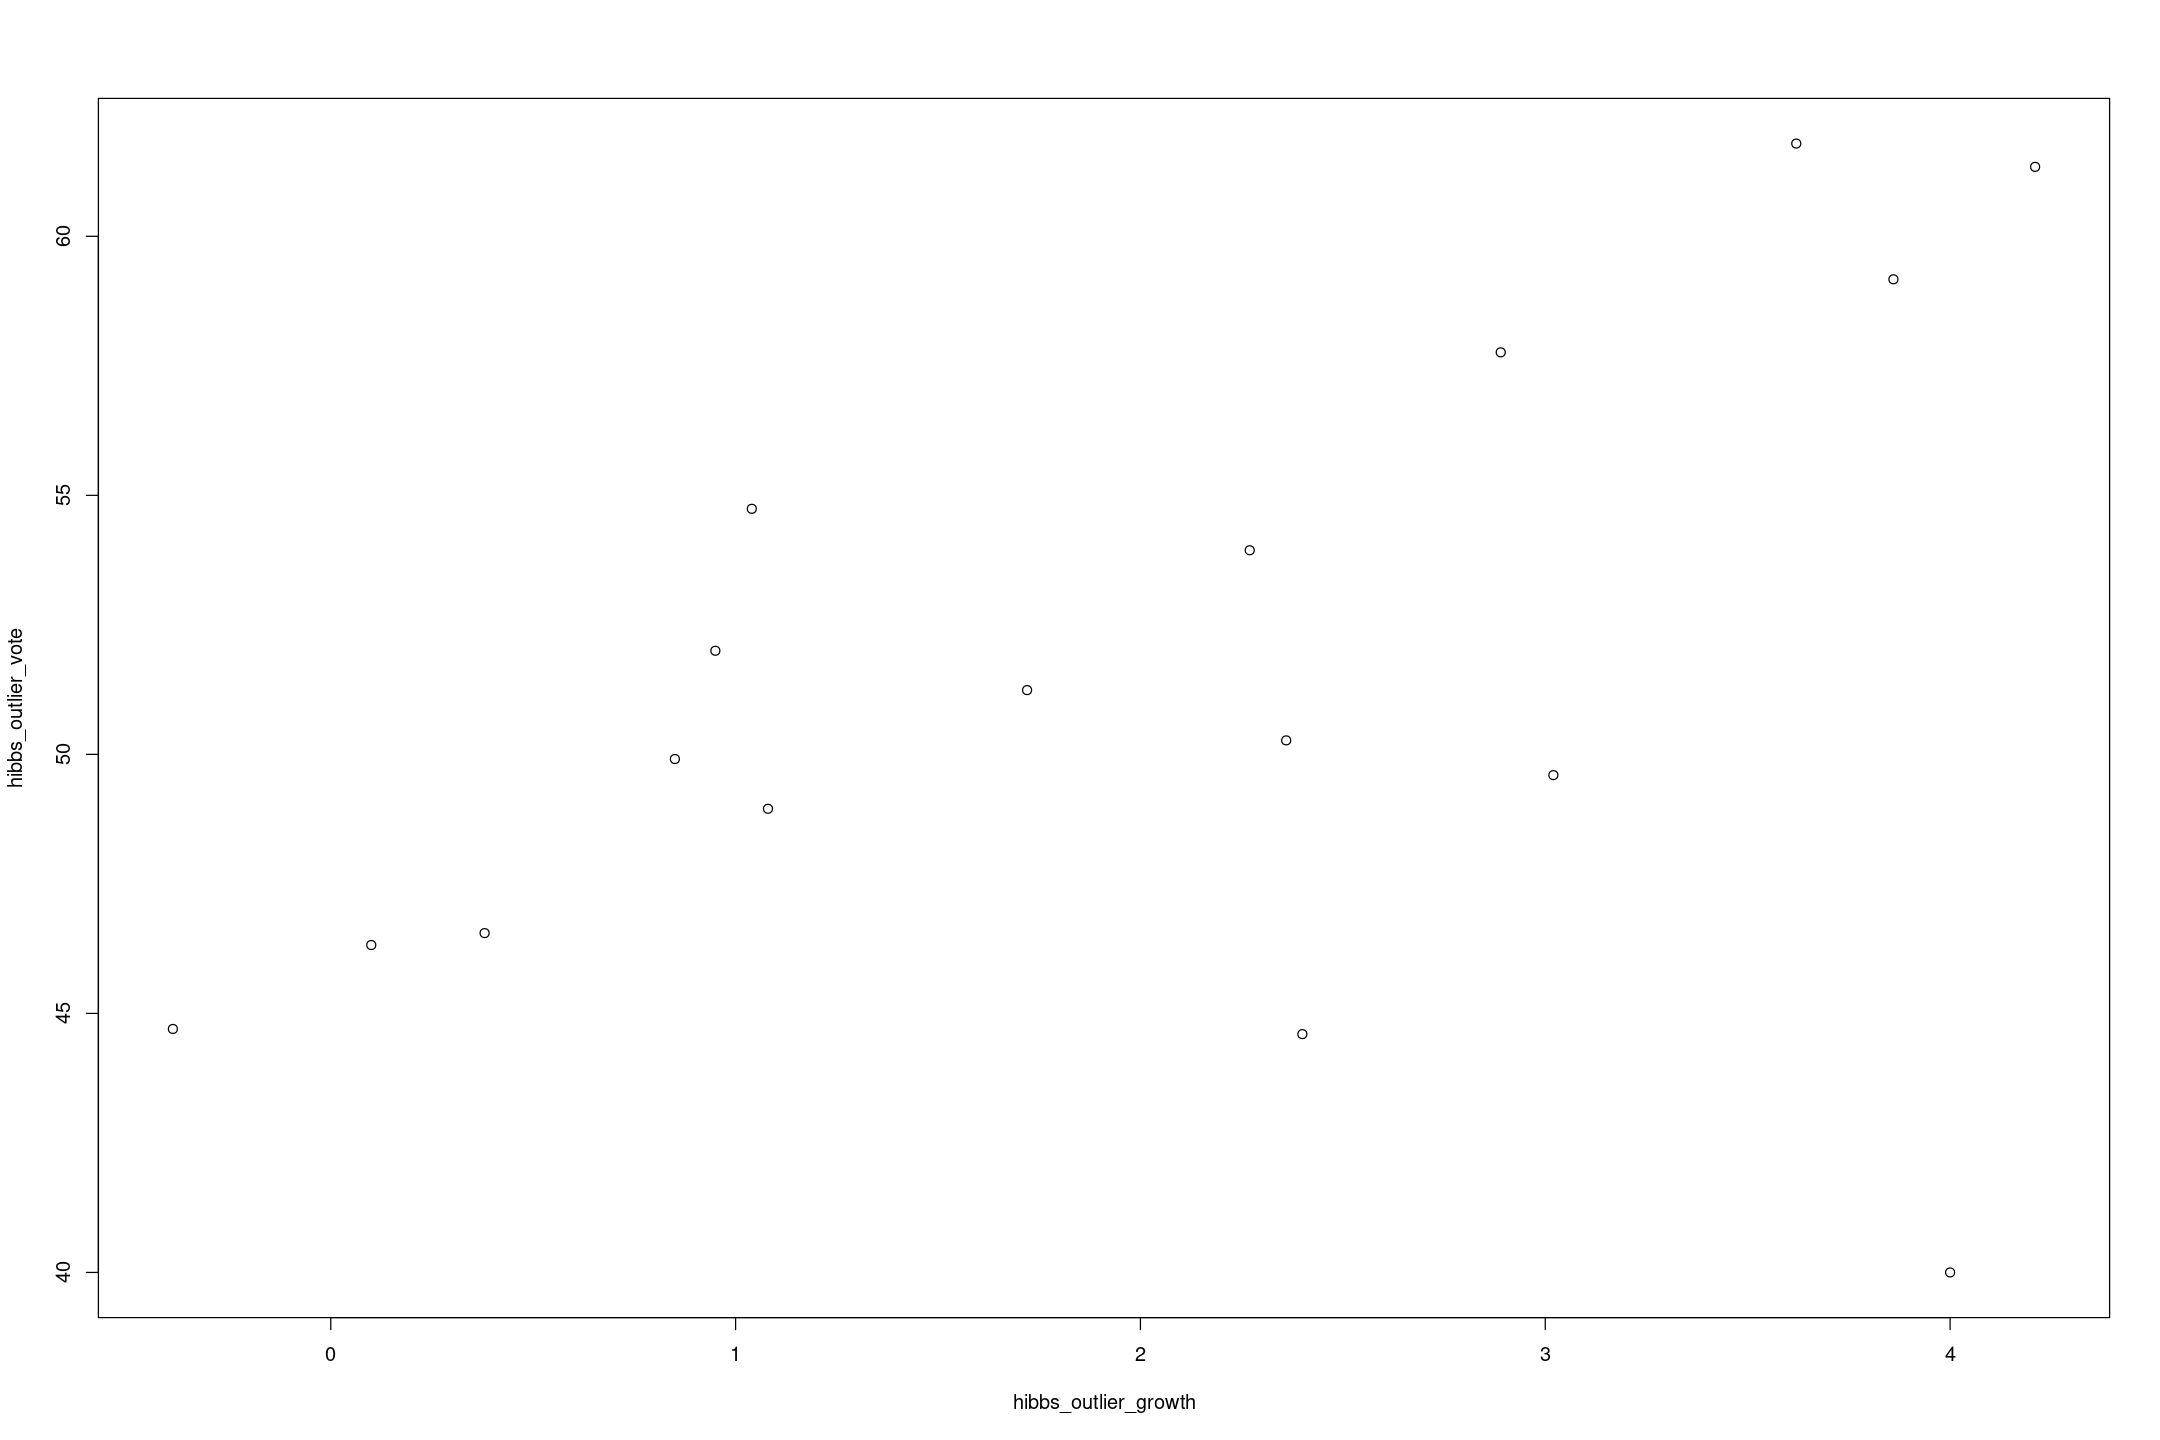

In [41]:
plot(hibbs_outlier_growth, hibbs_outlier_vote)

## Find the minimiser of absolute value and RSS

In [45]:
outlier_fits <- expand.grid(a=as, b=bs) %>%
rowwise() %>% mutate(rss_resid = rss(hibbs_outlier_growth, hibbs_outlier_vote, a, b)) %>%
rowwise() %>% mutate(abs_resid = absolute_residual(hibbs_outlier_growth, hibbs_outlier_vote, a, b))

In [46]:
min_absolute_residual <- outlier_fits %>% arrange(abs_resid) %>% head(1)
a_abs_outlier_min <- min_absolute_residual$a[1]
b_abs_outlier_min <- min_absolute_residual$b[1]
c(a_abs_outlier_min, b_abs_outlier_min)

[1] 46.00  3.41

In [47]:
min_rss_residual <- outlier_fits %>% arrange(rss_resid) %>% head(1)
a_rss_outlier_min <- min_rss_residual$a[1]
b_rss_outlier_min <- min_rss_residual$b[1]
c(a_rss_outlier_min, b_rss_outlier_min)

[1] 47.40  1.96

## Plot the differences

We can see the least squares deviation estimate has moved the line much closer to the outlier than the absolute deviation estimate has.

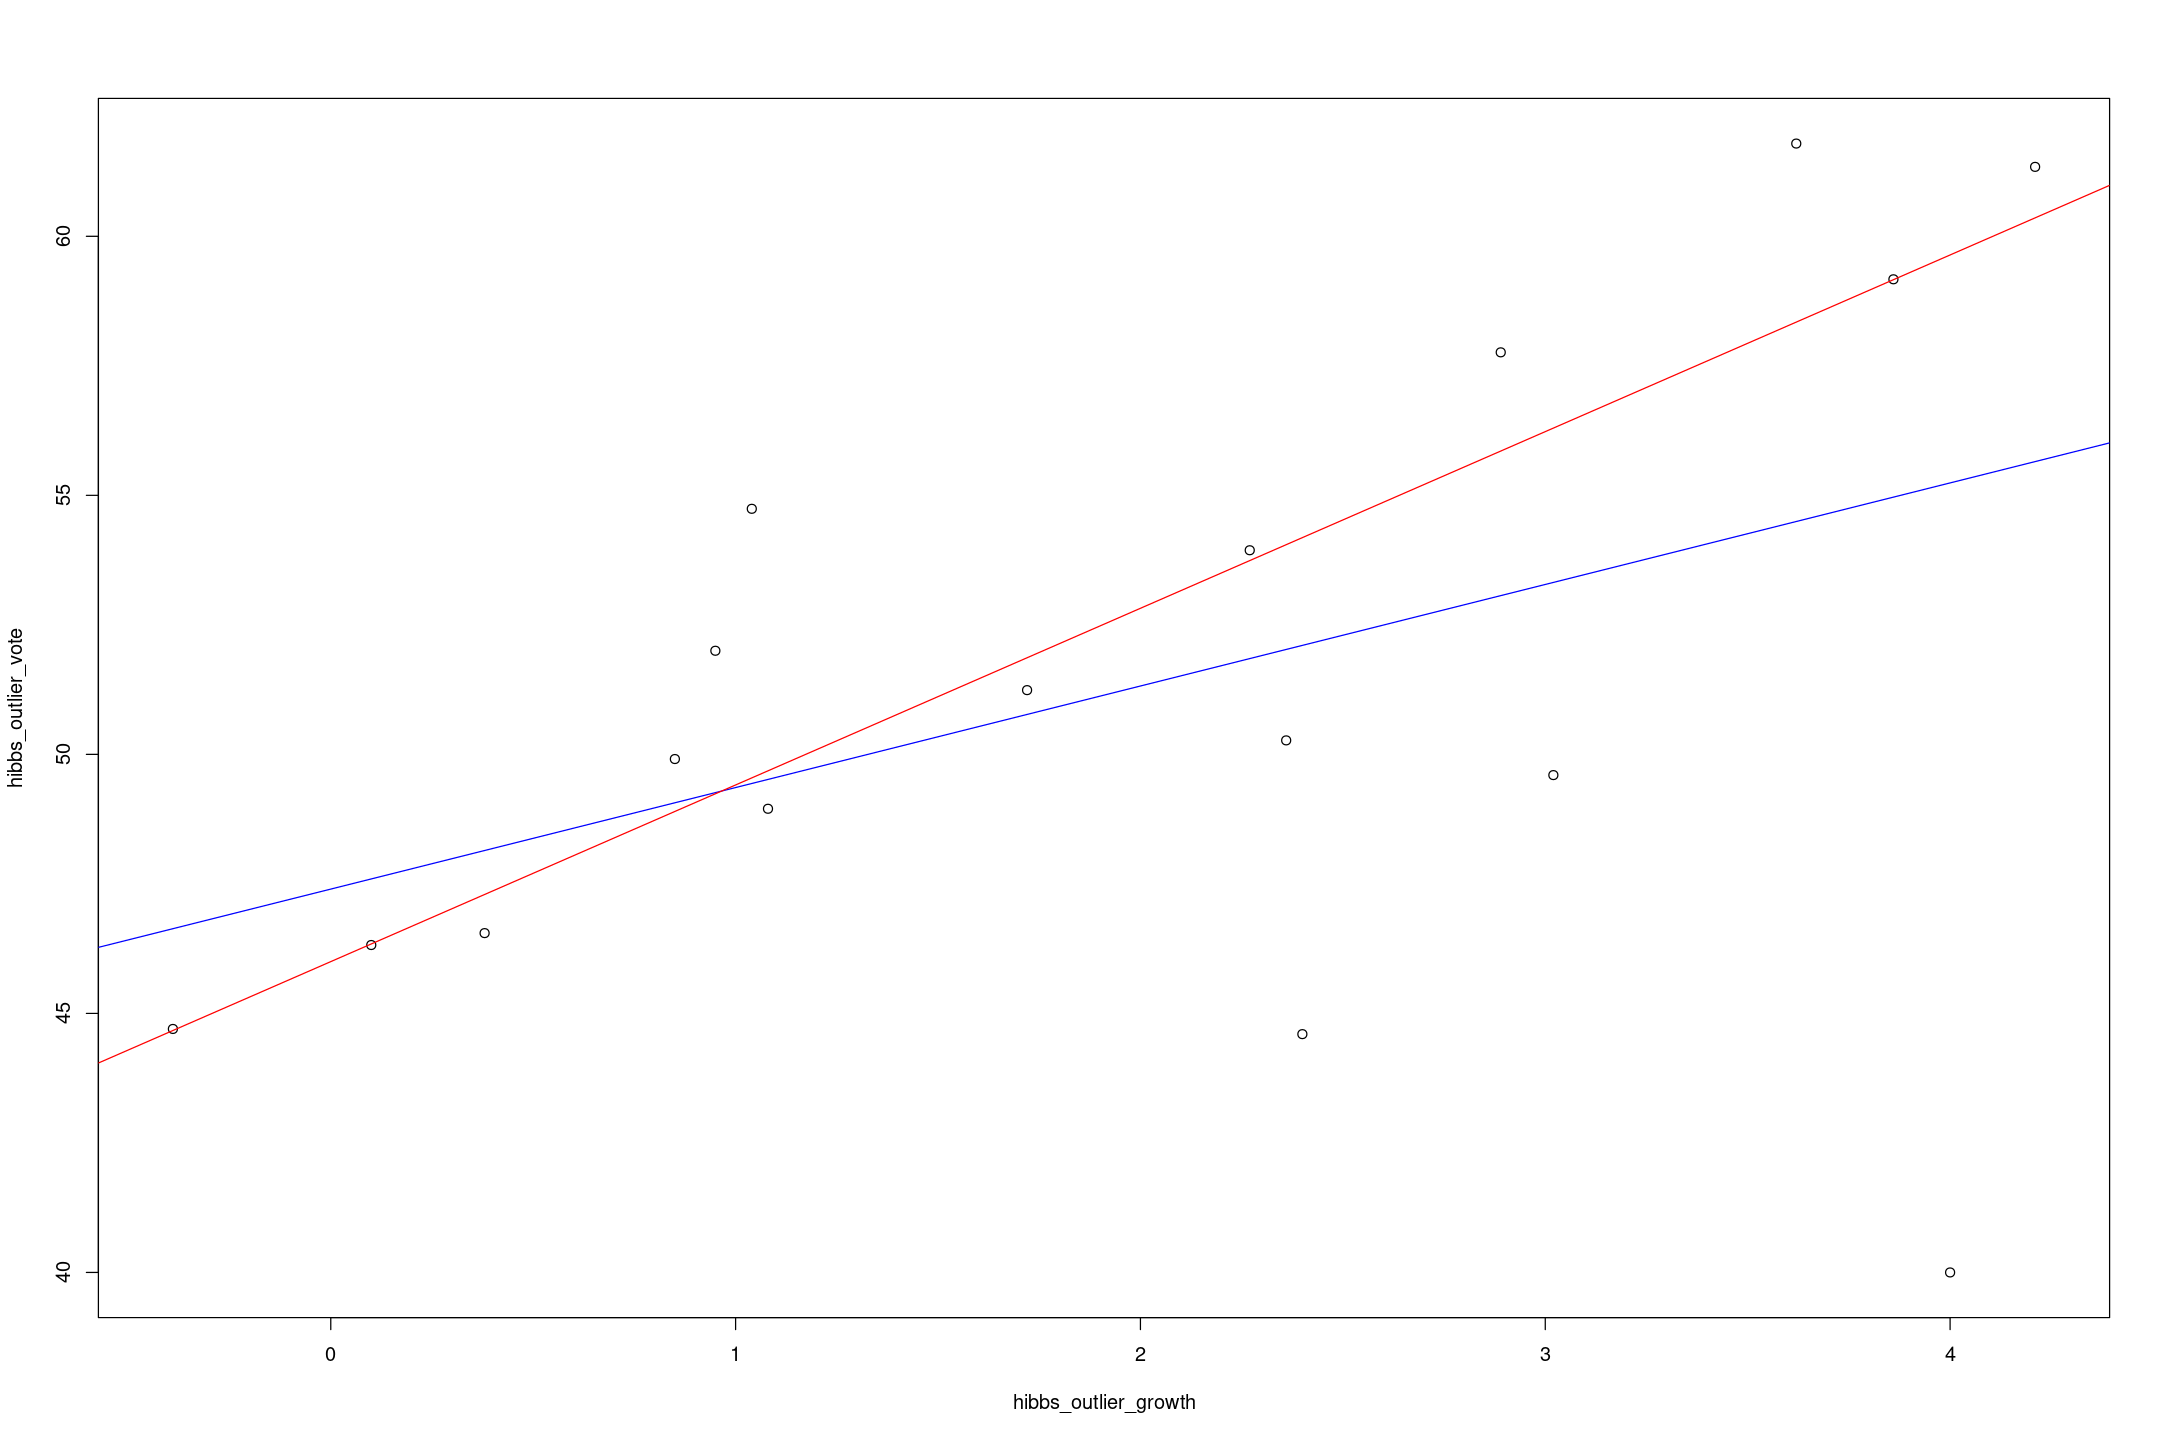

In [48]:
plot(hibbs_outlier_growth, hibbs_outlier_vote)
abline(a_rss_outlier_min, b_rss_outlier_min, col='blue')
abline(a_abs_outlier_min, b_abs_outlier_min, col='red')

# Influence of individual data points
A linear regression is fit to the data below.
Which point has the most influence on the slope.

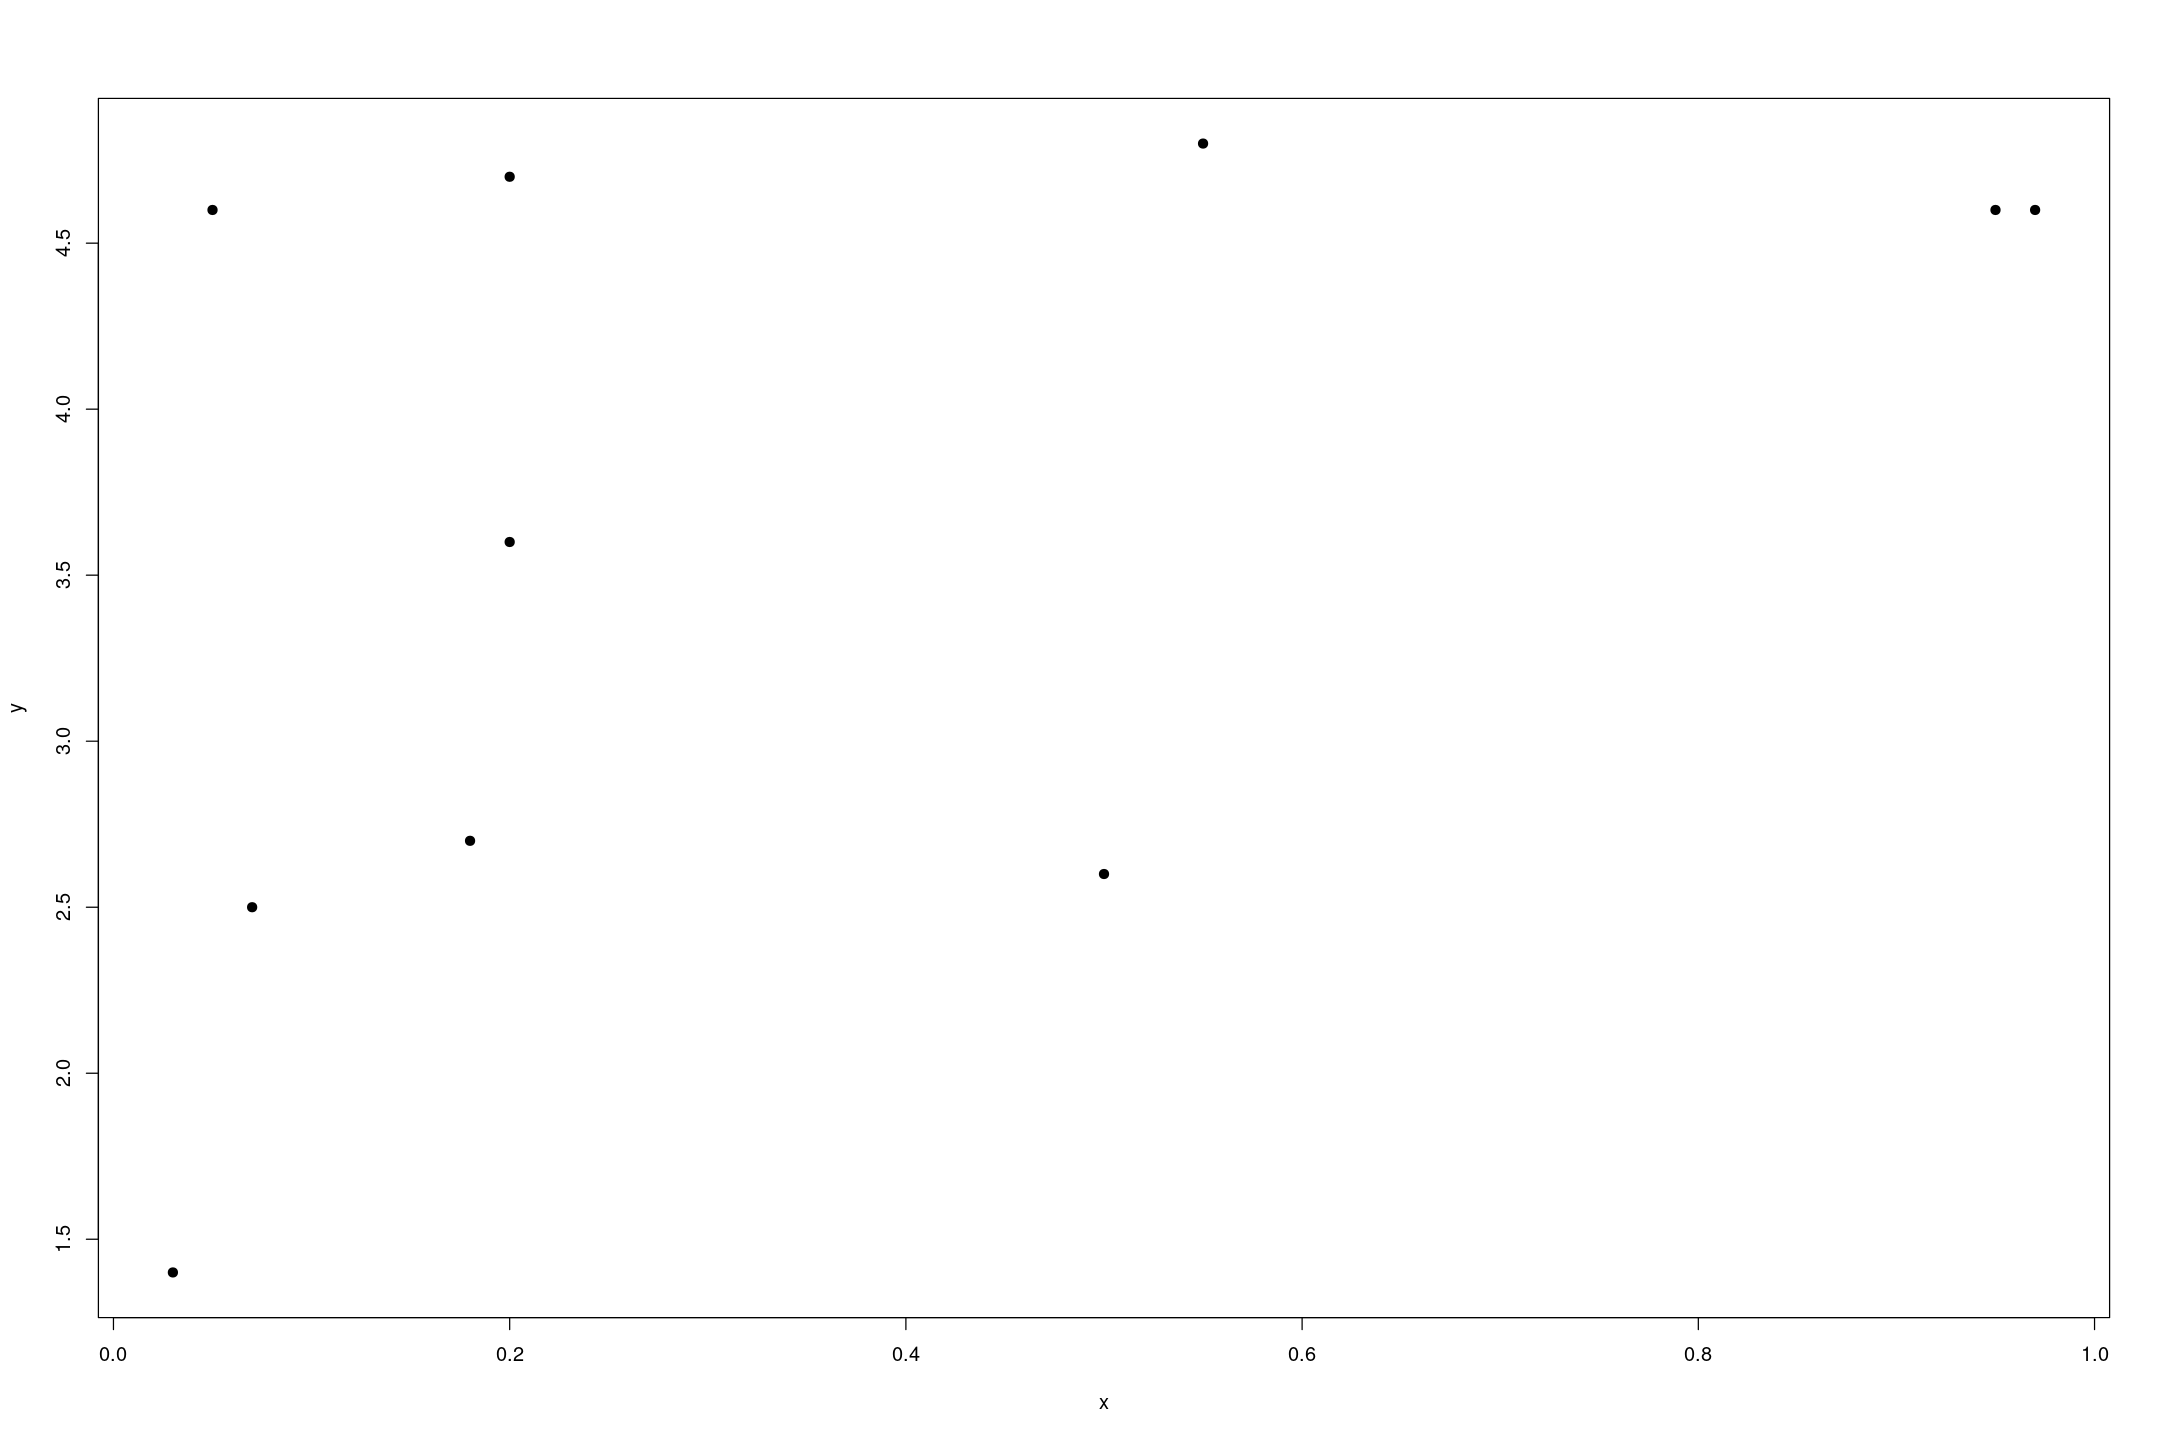

In [49]:
scatters <- tribble(
  ~x, ~y,
  0.03, 1.4,
  0.05, 4.6,
  0.07, 2.5,
  0.18, 2.7,
    0.2, 3.6,
    0.2, 4.7,
    0.5, 2.6,
    0.55, 4.8,
    0.95, 4.6,
    0.97, 4.6
    )

plot(scatters, pch=19)

The slope is given by:

$$ \hat{b} = \frac{\sum_{i=1}^{n} (x_i -\bar{x}) y_i}{\sum_{i=1}^{n} (x_i - \bar{x})^2} $$


The *influence* of a point is defined how much a change in 1 in *y* changes the slope.
Because of the weight $(x_i -\bar{x})$ it's the point furthest from the median on the x-axis, which here is the rightmost point.

But another way of looking at the slope is as the weighted average of slopes:


$$ \hat{b} = \frac{\sum_{i,j}(x_j - x_i)^2 \frac{y_j - y_i}{x_j - x_i}}{\sum_{i,j}(x_j-x_i)^2} $$

So the point that changes the value of the slope the most has the most different slope, especially for points far away.
In this case it would be the bottom leftmost point; it has a much steeper slope to the two far points on the rightmost than the others, and in general the slopes are steeper to most of the points.

## Default fit

Get the default slope

In [50]:
scatters_model = lm(y ~ x, data=scatters)
scatters_slope = coef(scatters_model)['x']
scatters_intercept = coef(scatters_model)['(Intercept)']
scatters_slope

x 
1.749739

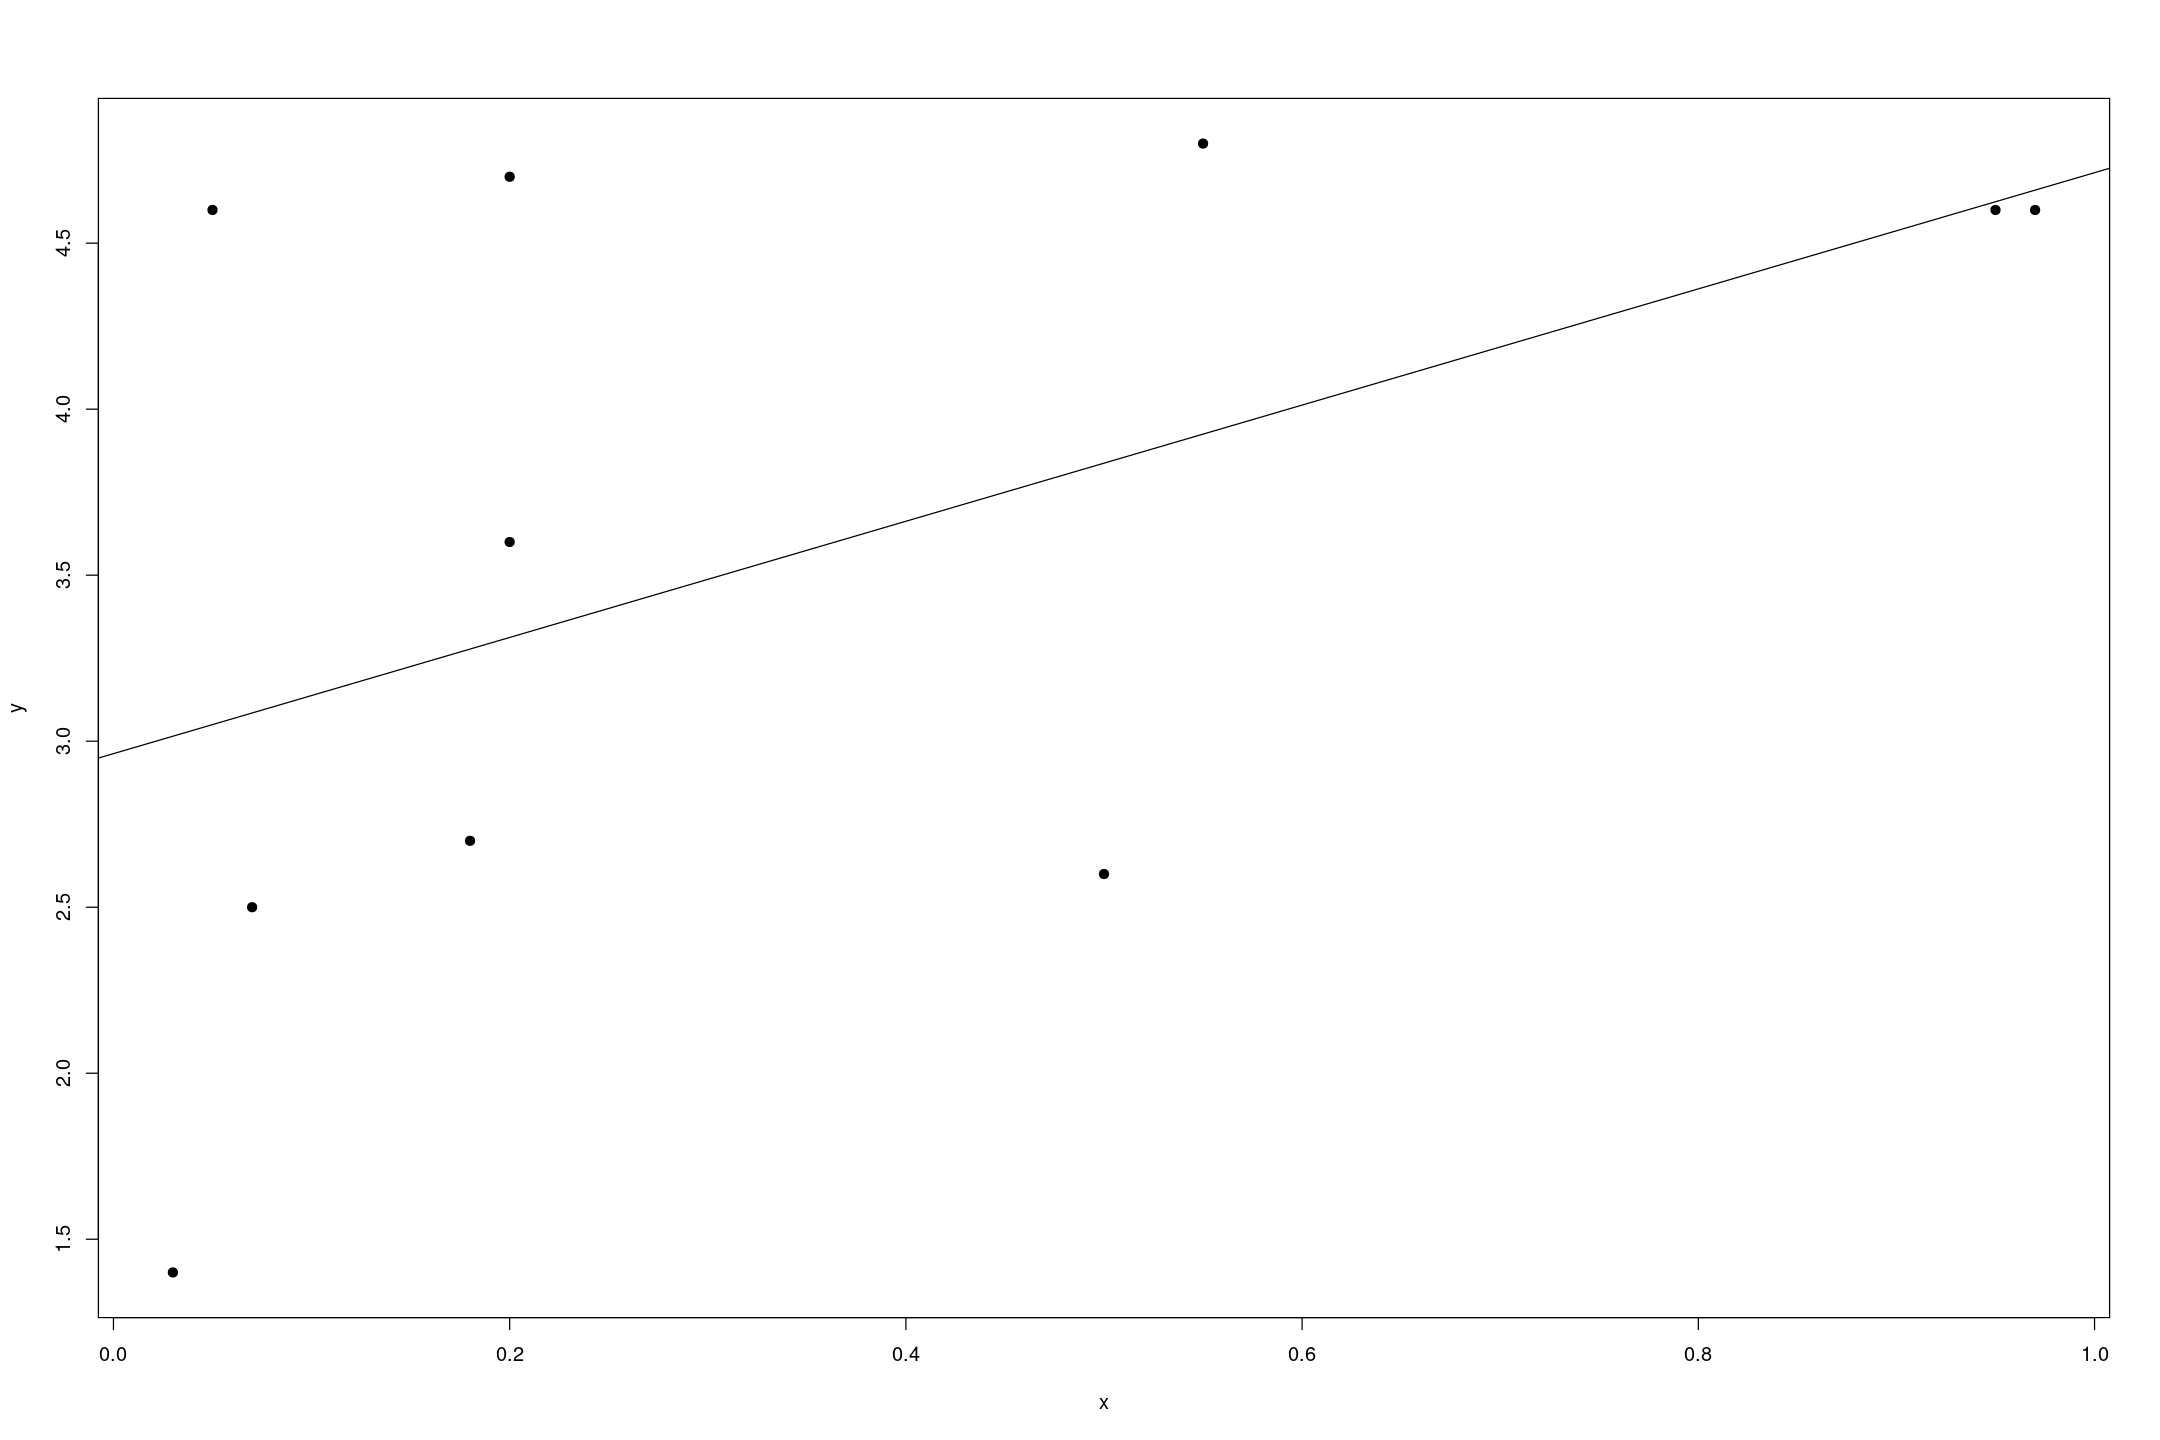

In [51]:
plot(scatters, pch=19)
abline(scatters_intercept, scatters_slope)

## Checking influence

The biggest influence is from the rightmost point, and as expected the smallest impact is from the point in the centre of the x-axis.

In [89]:
scatter_influence = tibble(x=scatters$x,
                 y=scatters$y,
                 data=purrr::map(seq(1, nrow(scatters)), ~tibble(x=scatters$x, y=scatters$y + diag(nrow(scatters))[.,]))) %>%
rowwise() %>% mutate(model = list(stan_glm(y ~ x, data=data, refresh=0, prior=NULL, prior_intercept=NULL, prior_aux=NULL))) %>%
rowwise() %>% mutate(slope = coef(model)["x"])  %>% 
mutate(influence = slope - scatters_slope) %>% 
arrange(desc(abs(influence)))

scatter_influence

x    y  
1  0.97 4.6
2  0.95 4.6
3  0.03 1.4
4  0.05 4.6
5  0.07 2.5
6  0.18 2.7
7  0.55 4.8
8  0.20 4.7
9  0.50 2.6
10 0.20 3.6
   data                                                                                                                  
1  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 5.60
2  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 5.60, 4.60
3  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 2.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
4  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 5.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
5  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 3.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
6  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 3.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
7  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 5.80, 4.60, 4.60
8  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 5.70, 2.60, 4.80, 4.60, 4.60
9  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 3.60, 4.80, 4.60, 4.60
10 0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 4.60, 4.70, 2.60, 4.80, 4.60, 4.60
   model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
1  2.872104, 2.279076, 0.61477, 1.227313, 2.940476, 2.986057, 3.031639, 3.282337, 3.327919, 3.327919, 4.011641, 4.125595, 5.037225, 5.082807, 2.940476, 2.986057, 3.031639, 3.282337, 3.327919, 3.327919, 4.011641, 4.125595, 5.037225, 5.082807, -1.540476, 1.613943, -0.5316389, -0.5823372, 0.2720813, 1.372081, -1.411641, 0.6744049, -

Close to a straight line centred at the origin

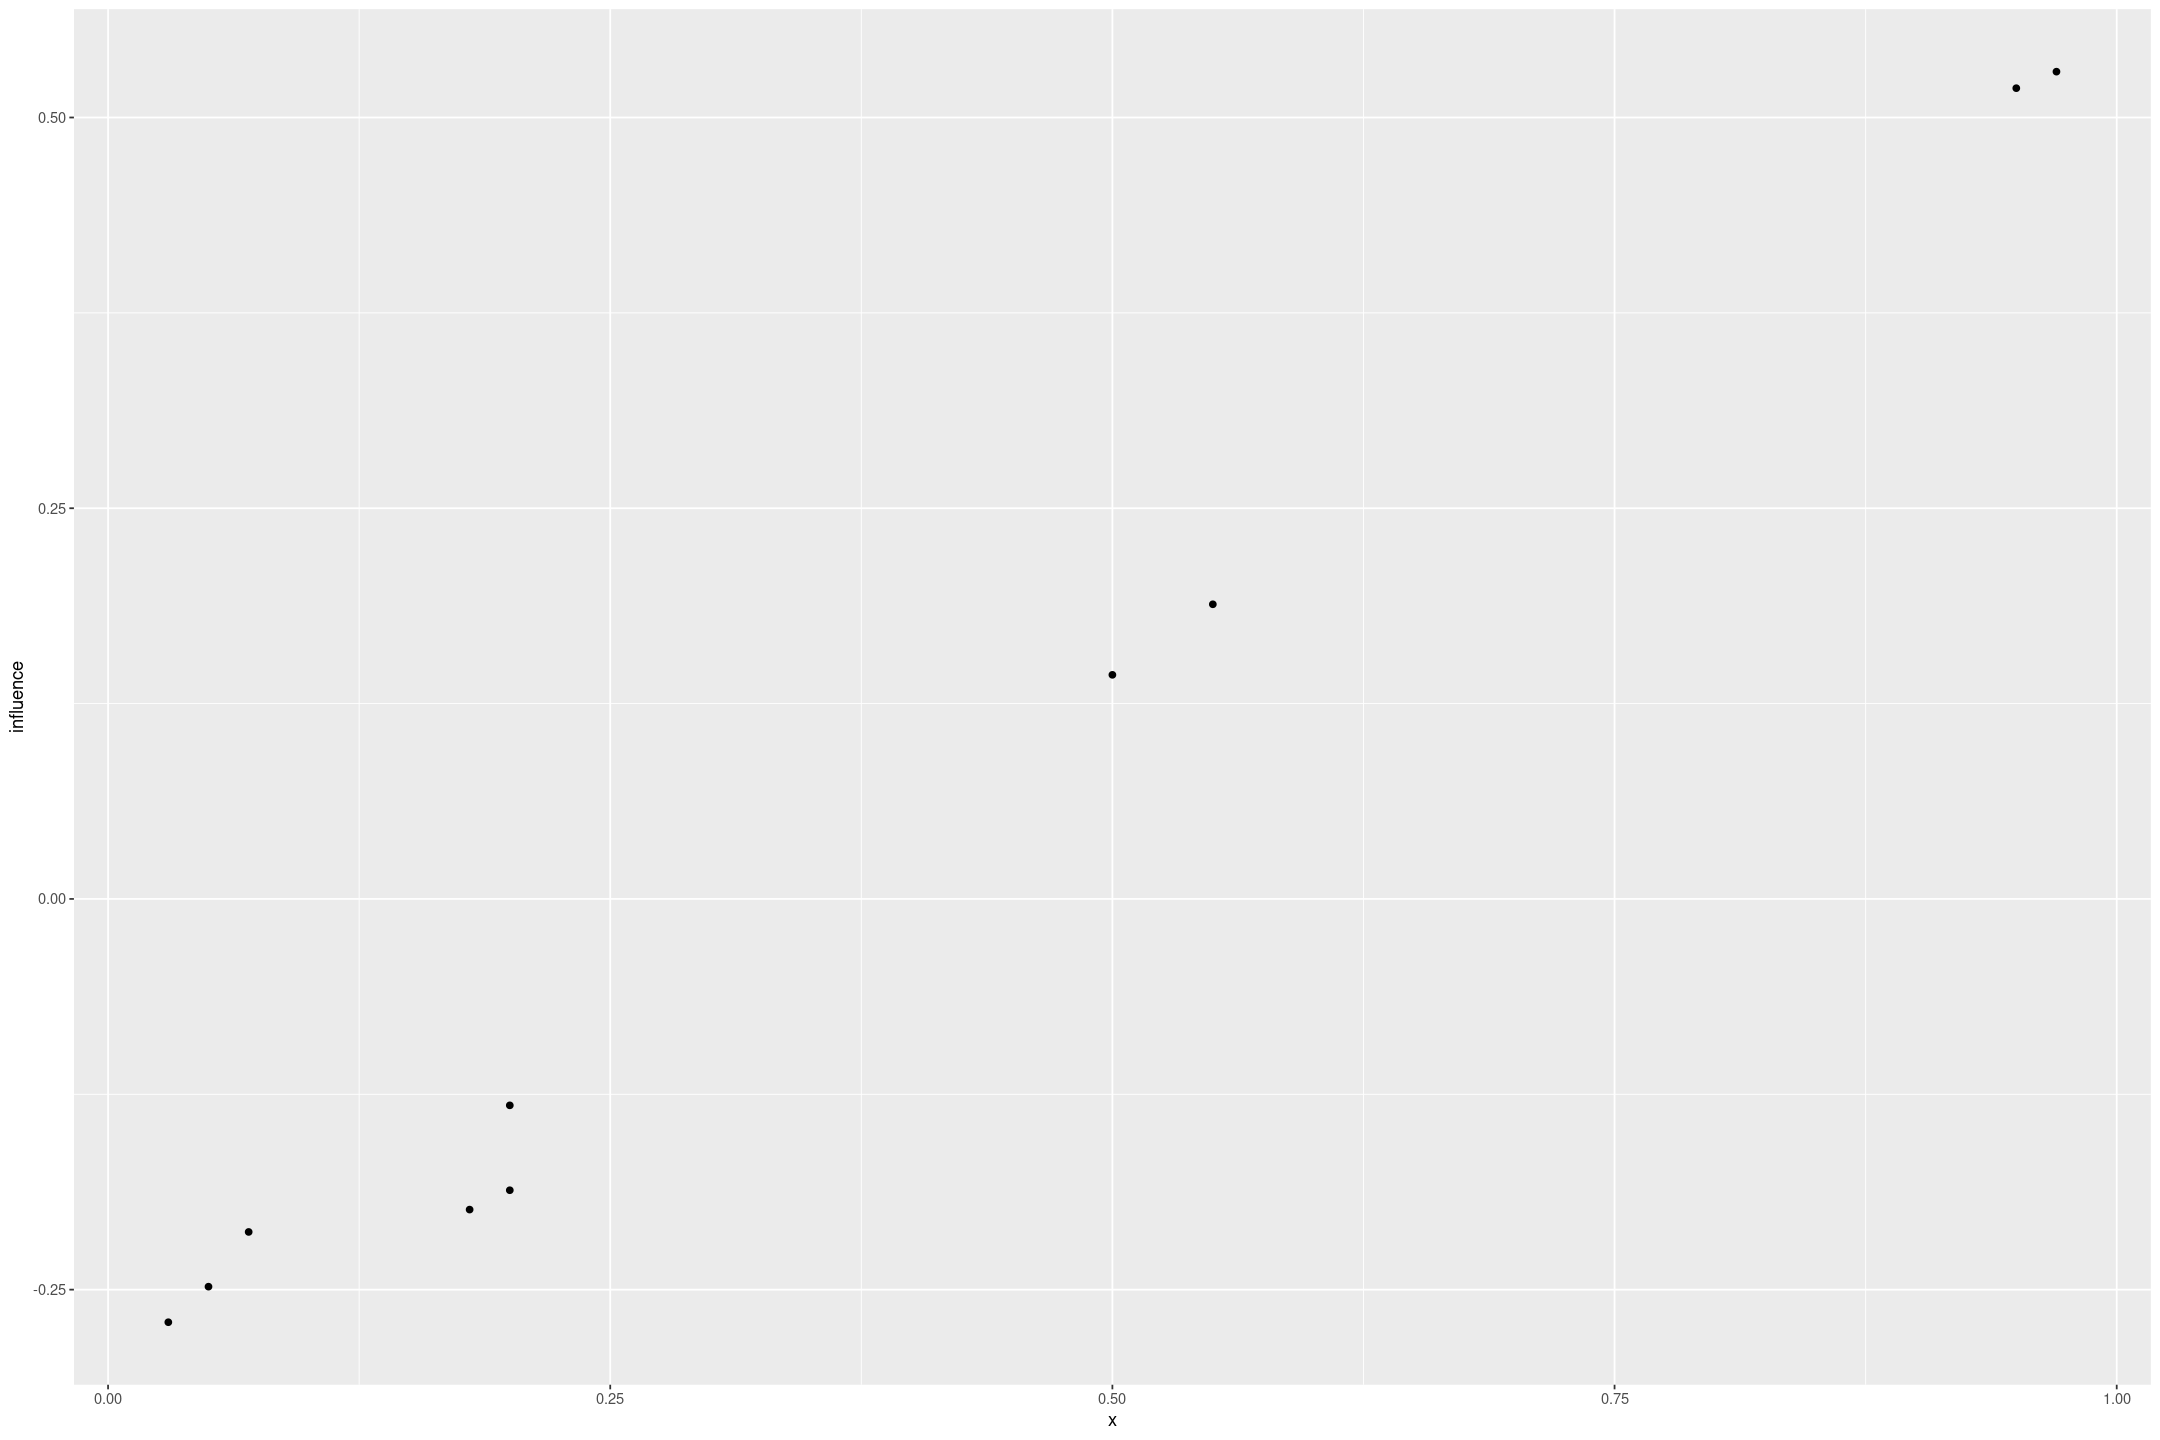

In [91]:
scatter_influence %>% gf_point(influence ~ x)

## Checking impact of removing points on slope

In [78]:
xmean = mean(scatters$x)
xmean

[1] 0.37

Removing the point at the left bottom causes the most change to the slope, so this is the point that has the most influence on slope.

In [79]:
loo = tibble(data=purrr::map(seq(1,nrow(scatters)), ~scatters[-.,]),
          x = scatters$x,
          y = scatters$y) %>% 
mutate(deltax = x - xmean) %>%
rowwise() %>% mutate(model=list(lm(y ~ x, data=data))) %>% 
rowwise() %>% mutate(slope = coef(model)['x']) %>%
rowwise() %>% mutate(intercept = coef(model)['(Intercept)']) %>%
mutate(slope_change = slope - scatters_slope) %>%
arrange(desc(abs(slope_change)))

loo

data                                                                                                      
1  0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
2  0.03, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
3  0.03, 0.05, 0.07, 0.18, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 2.60, 4.80, 4.60, 4.60
4  0.03, 0.05, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
5  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 4.80, 4.60, 4.60
6  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.60, 4.60
7  0.03, 0.05, 0.07, 0.20, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 3.60, 4.70, 2.60, 4.80, 4.60, 4.60
8  0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.95, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60
9  0.03, 0.05, 0.07, 0.18, 0.20, 0.50, 0.55, 0.95, 0.97, 1.40, 4.60, 2.50, 2.70, 4.70, 2.60, 4.80, 4.60, 4.60
10 0.03, 0.05, 0.07, 0.18, 0.20, 0.20, 0.50, 0.55, 0.97, 1.40, 4.60, 2.50, 2.70, 3.60, 4.70, 2.60, 4.80, 4.60
   x    y   deltax
1  0.03 1.4 -0.34 
2  0.05 4.6 -0.32 
3  0.20 4.7 -0.17 
4  0.07 2.5 -0.30 
5  0.50 2.6  0.13 
6  0.55 4.8  0.18 
7  0.18 2.7 -0.19 
8  0.97 4.6  0.60 
9  0.20 3.6 -0.17 
10 0.95 4.6  0.58 
   model                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1  3.386178, 1.151062, 1.156269, -0.9667524, -0.8933692, -0.01639048, 1.08361, -1.361709, 0.7807379, 0.1203131, 0.09729188, -11.56667, 1.162034, -1.044328, -0.1873168, 0.9126832, -1.832147, 0.2603808, -0.7993933, -0.842382, 2, 3.443731, 3.466752, 3.593369, 3.61639, 3.61639, 3.961709, 4.019262, 4.479687, 4.502708, 0, 1, -3, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, -1.223333, 1.009532, 0.1370271, 0.117216, 0.117216, -0.1799513, -0.2294792, -0.6257023, -0.6455134, 1.333333, 1.245988, 1, 2, 1e-07, 2, 7, lm(formula = y ~ x, data = data), y ~ x, 4.6, 2.5, 2.7, 3.6, 4.7, 2.6, 4.8, 4.6, 4.6, 0.05, 0.07, 0.18, 0.2, 0.2, 0.5, 0.55, 0.95, 0.97   
2  2.574201, 2.282791, -1.242685, -0.2339968, -0.2851038, 0.5692404, 1.66924, -1.115597, 0.9702635, -0.1428528, -0.1885087, -10.5, 2.321074, 0.01754524, 0.873108, 1.973108, -0.7934508, 1.295456, 0.206711, 0.1622738, 2, 2.642685, 2.733997, 2.985104, 3.03076, 3.03076, 3.715597, 3.829736, 4.742853, 4.788509, 0, 1, -3, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, -1.216667, 1.01677, 0.129495, 0.1098249, 0.1098249, -0.185227, -0.2344023, -0.6278047, -0.6474749, 1.333333, 1.237681, 1, 2, 1e-07, 2, 7, lm(formula = y ~ x, data = data), y ~ x, 1.4, 2.5, 2.7, 3.6, 4.7, 2.6, 4.8, 4.6, 4.6, 0.03, 0.07, 0.18, 0.2, 0.2, 0.5, 0.55, 0.95, 0.97            
3  2.717069, 1.98468, -1.376609, 1.783697, -0.3559964, -0.3743112, 0.4859952, -1.109409, 0.9913571, -0.002515091, -0.0422087, -10.46667, 2.096154, -0.3854131, -0.2244148, 0.668494, -0.4378744, 1.744398, 1.402573, 1.395482, 2, 2.776609, 2.816303, 2.855996, 3.074311, 3.114005, 3.709409, 3.808643, 4.602515, 4.642209, 0, 1, -3, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, 0.3333333, -1.166667, 1.056167, 0.2169796, 0.1128294, 0.09389297, -0.190153, -0.237494, -0.6162219, -0.63515

Visually you can see removing the lower leftmost point (red) significantly changes the slope of the corresponding line fitted excluding that point.

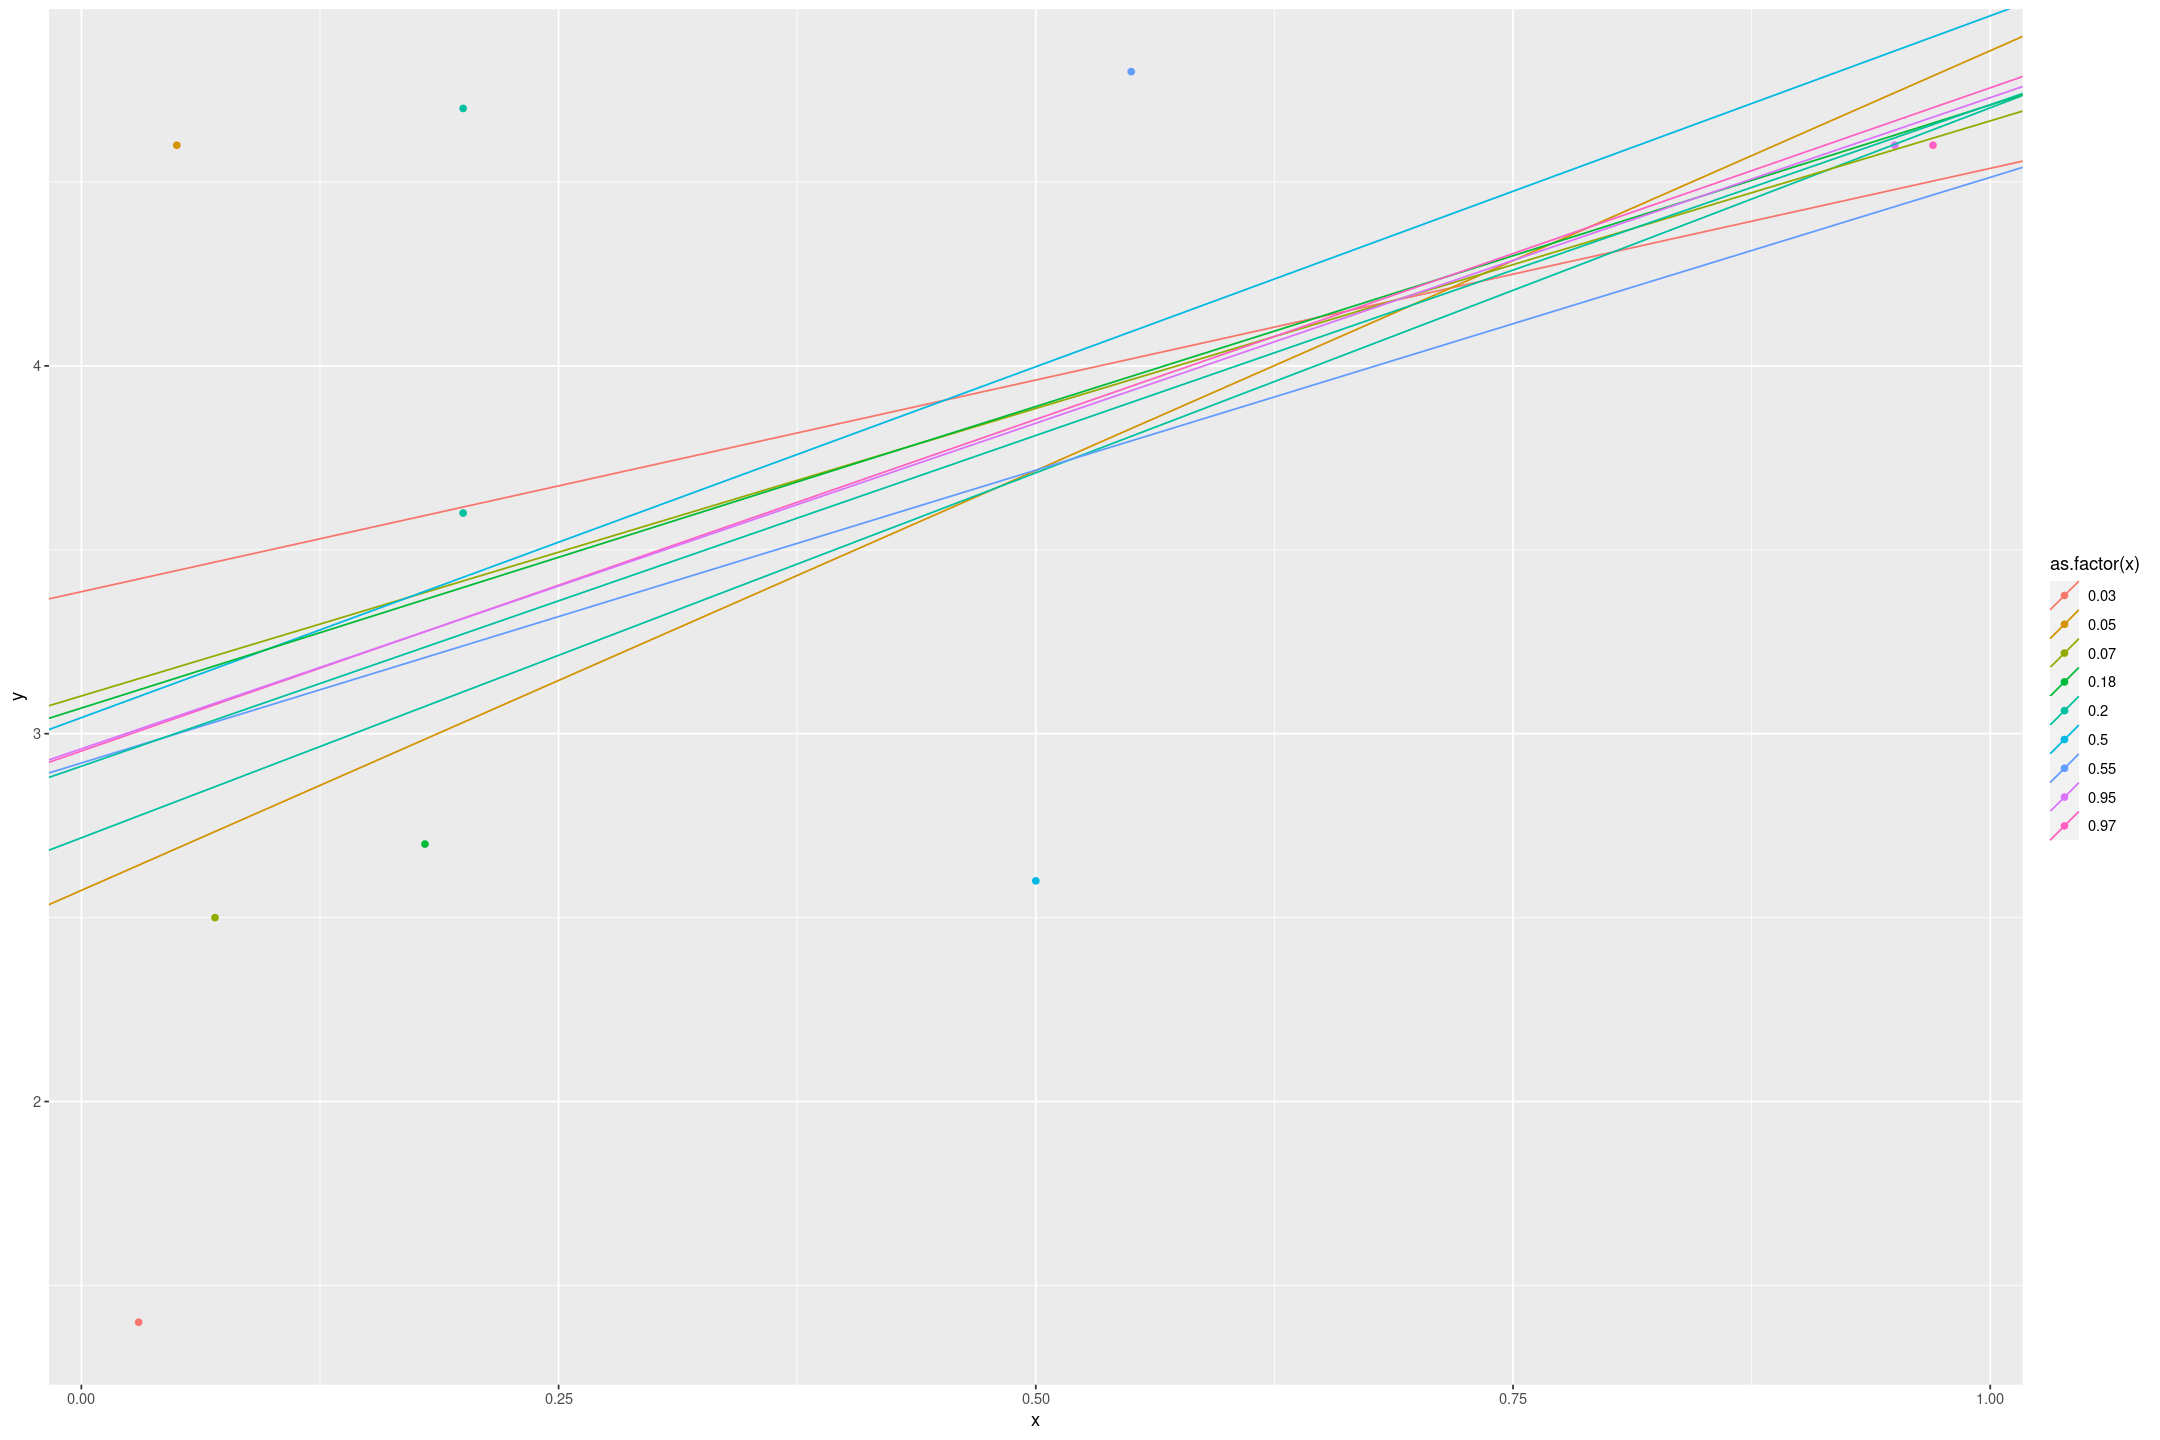

In [92]:
loo %>% gf_point(y ~ x, col=~as.factor(x))%>% 
gf_abline(intercept=~intercept, slope=~slope, col=~as.factor(x))

# Influence of individual data points

a) Using expression (8.3), compute the influence of each of the data points in the election forecasting example on the fitted slope of the model.
Make a graph plotting influence of point $i$ vs. $x_i$.

b) Re-fit the model $n$ times, for each data point $i$ adding 1 to $y_i$.
Save $\hat{b}$ from each of these altered regressions, compare to the $\hat{b}$ from the original data, and check that the influence is approximately the same as computed above using the formula.
(The two calculations will not exactly give identical results because `stan_glm` uses a prior distribution and so it does not exactly yield the least squares estimate.)

a) Influence gets bigger the further away from the mean you are. So it's a straight line of slope 1, with a minimum at the mean value.

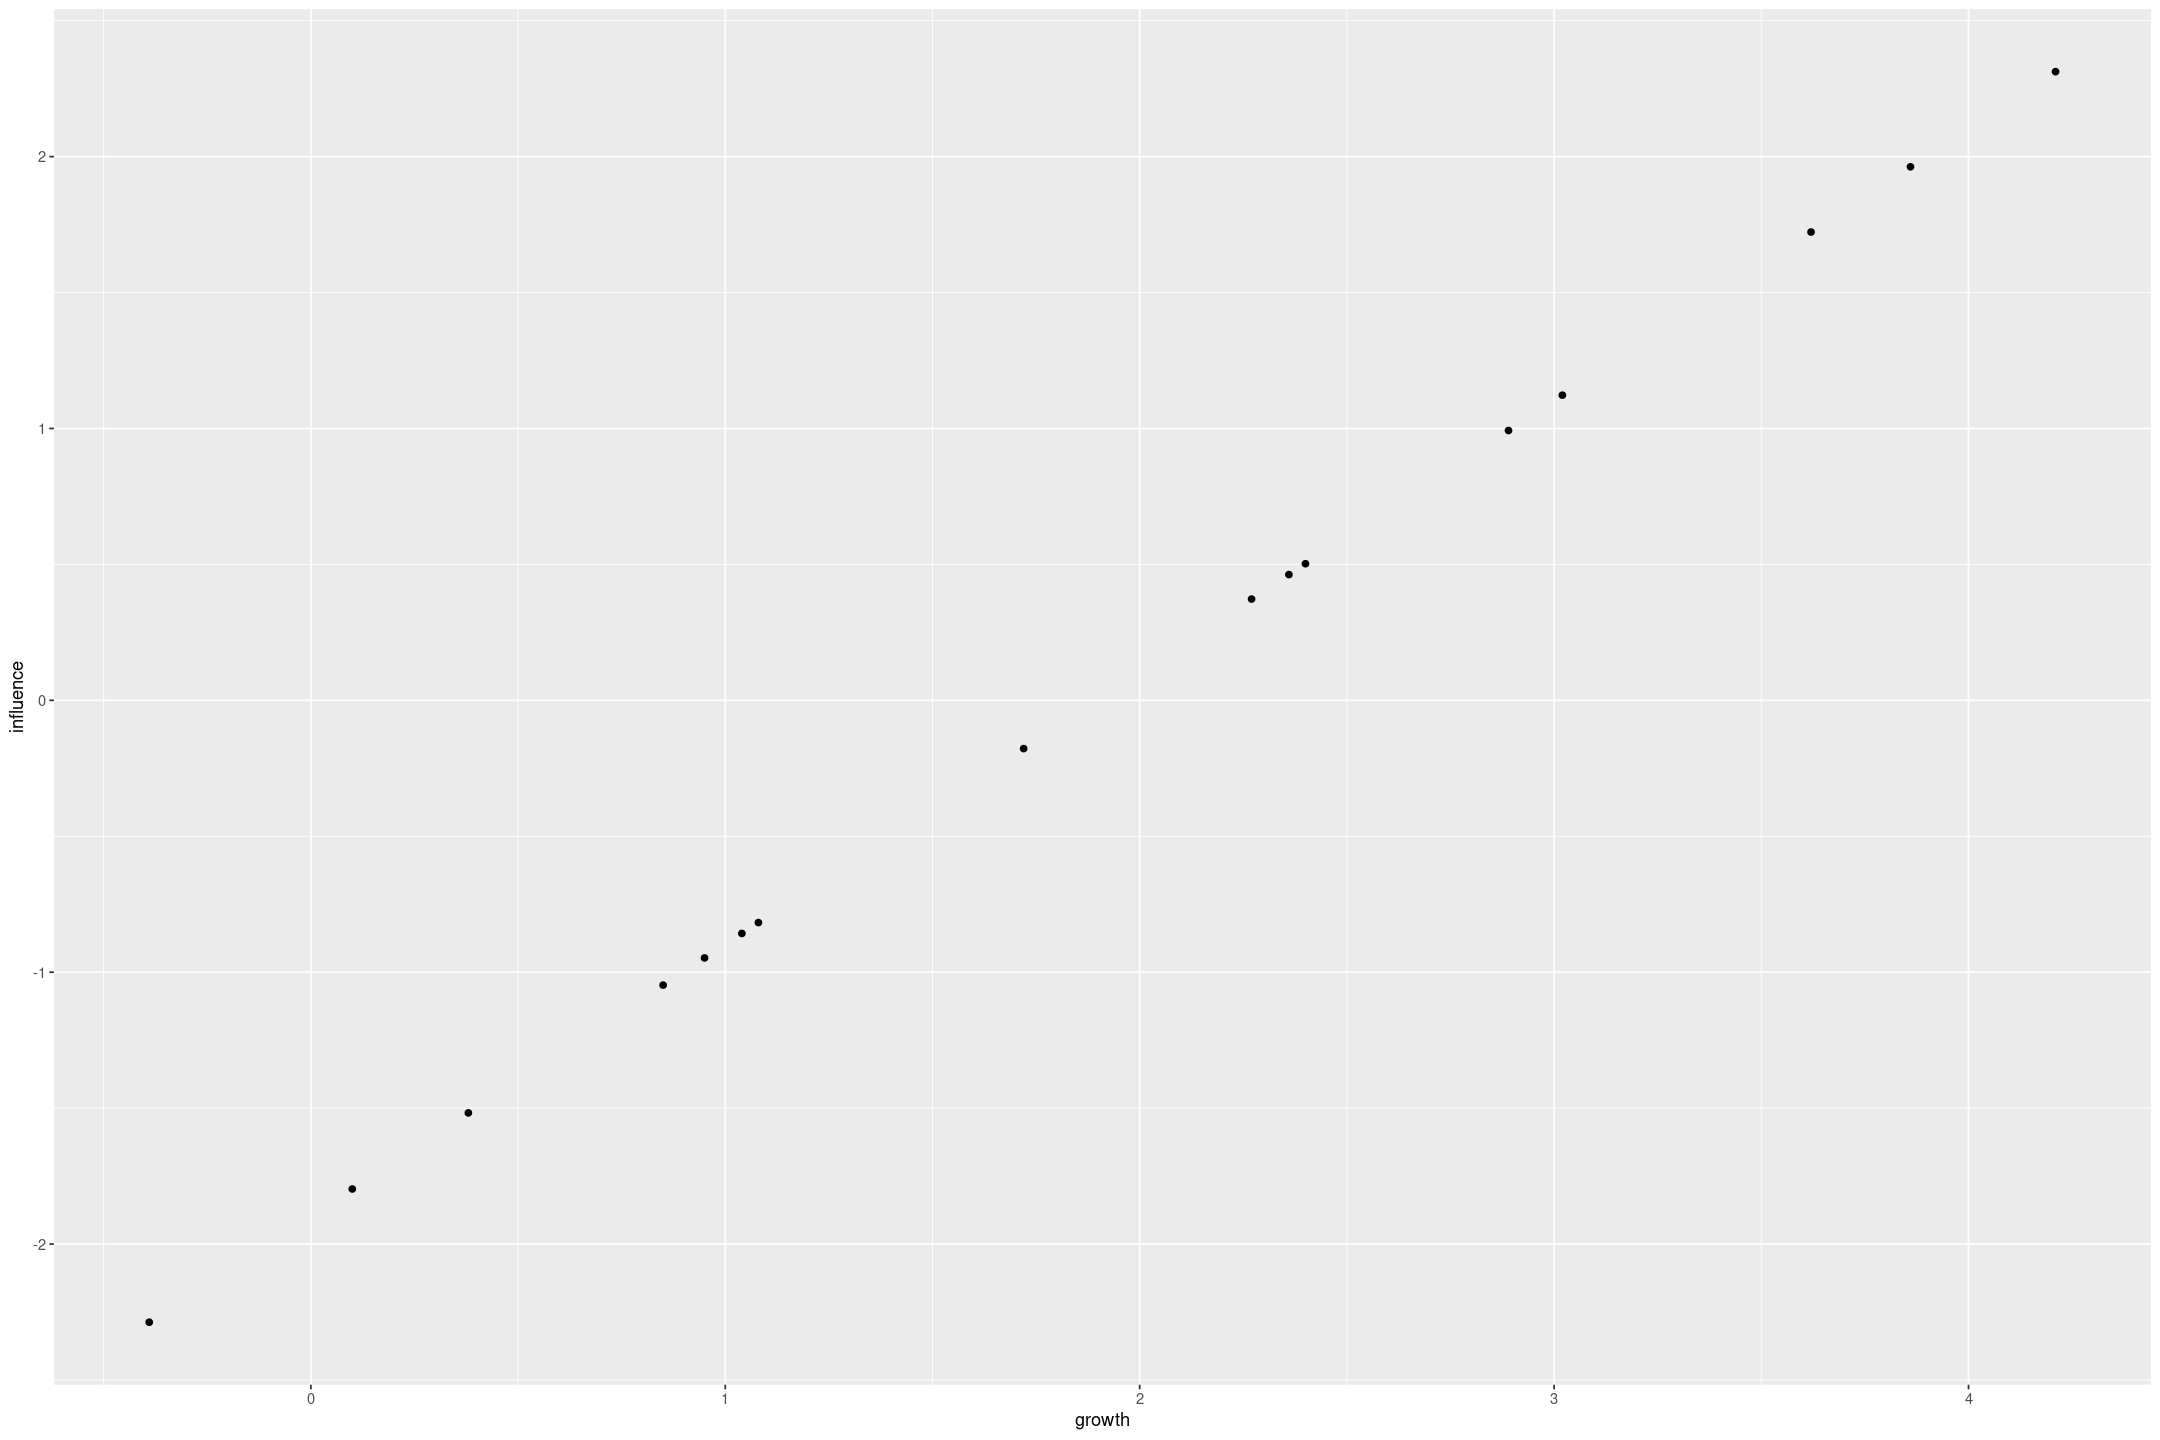

In [93]:
hibbs %>% mutate(influence = growth - mean(growth)) %>%
gf_point(influence ~ growth)

b)

In [94]:
hibbs

year growth vote  inc_party_candidate other_candidate
1  1952  2.40  44.60 Stevenson           Eisenhower     
2  1956  2.89  57.76 Eisenhower          Stevenson      
3  1960  0.85  49.91 Nixon               Kennedy        
4  1964  4.21  61.34 Johnson             Goldwater      
5  1968  3.02  49.60 Humphrey            Nixon          
6  1972  3.62  61.79 Nixon               McGovern       
7  1976  1.08  48.95 Ford                Carter         
8  1980 -0.39  44.70 Carter              Reagan         
9  1984  3.86  59.17 Reagan              Mondale        
10 1988  2.27  53.94 Bush, Sr.           Dukakis        
11 1992  0.38  46.55 Bush, Sr.           Clinton        
12 1996  1.04  54.74 Clinton             Dole           
13 2000  2.36  50.27 Gore                Bush, Jr.      
14 2004  1.72  51.24 Bush, Jr.           Kerry          
15 2008  0.10  46.32 McCain              Obama          
16 2012  0.95  52.00 Obama               Romney

In [111]:
purrr::map(c(1,2), ~mutate(hibbs, vote = vote + diag(nrow(hibbs))[.,]))

[[1]]
   year growth  vote inc_party_candidate other_candidate
1  1952   2.40 45.60           Stevenson      Eisenhower
2  1956   2.89 57.76          Eisenhower       Stevenson
3  1960   0.85 49.91               Nixon         Kennedy
4  1964   4.21 61.34             Johnson       Goldwater
5  1968   3.02 49.60            Humphrey           Nixon
6  1972   3.62 61.79               Nixon        McGovern
7  1976   1.08 48.95                Ford          Carter
8  1980  -0.39 44.70              Carter          Reagan
9  1984   3.86 59.17              Reagan         Mondale
10 1988   2.27 53.94           Bush, Sr.         Dukakis
11 1992   0.38 46.55           Bush, Sr.         Clinton
12 1996   1.04 54.74             Clinton            Dole
13 2000   2.36 50.27                Gore       Bush, Jr.
14 2004   1.72 51.24           Bush, Jr.           Kerry
15 2008   0.10 46.32              McCain           Obama
16 2012   0.95 52.00               Obama          Romney

[[2]]
   year growth  vote inc_party_candidate other_candidate
1  1952   2.40 44.60           Stevenson      Eisenhower
2  1956   2.89 58.76          Eisenhower       Stevenson
3  1960   0.85 49.91               Nixon         Kennedy
4  1964   4.21 61.34             Johnson       Goldwater
5  1968   3.02 49.60            Humphrey           Nixon
6  1972   3.62 61.79               Nixon        McGovern
7  1976   1.08 48.95                Ford          Carter
8  1980  -0.39 44.70              Carter          Reagan
9  1984   3.86 59.17              Reagan         Mondale
10 1988   2.27 53.94           Bush, Sr.         Dukakis
11 1992   0.38 46.55           Bush, Sr.         Clinton
12 1996   1.04 54.74             Clinton            Dole
13 2000   2.36 50.27                Gore       Bush, Jr.
14 2004   1.72 51.24           Bush, Jr.           Kerry
15 2008   0.10 46.32              McCain           Obama
16 2012   0.95 52.00               Obama          Romney

In [129]:
influence <- tibble(growth=hibbs$growth,
                 vote=hibbs$vote,
                 data=purrr::map(seq(1, nrow(hibbs)), 
                                 ~mutate(hibbs, vote = vote + diag(nrow(hibbs))[.,]))) %>%
rowwise() %>% mutate(model = list(stan_glm(vote ~ growth, data=data, refresh=0))) %>%
rowwise() %>% mutate(slope = coef(model)["growth"])  %>% 
mutate(influence = slope - b_min) %>% arrange(desc(abs(influence)))

influence

growth vote 
1  -0.39  44.70
2   0.38  46.55
3   0.95  52.00
4   1.08  48.95
5   0.10  46.32
6   3.02  49.60
7   4.21  61.34
8   3.62  61.79
9   3.86  59.17
10  1.04  54.74
11  0.85  49.91
12  1.72  51.24
13  2.89  57.76
14  2.27  53.94
15  2.40  44.60
16  2.36  50.27
   data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 45.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
2  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 47.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
3  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 53.00, 14.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
4  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 49.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
5  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 47.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
6  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 50.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11

Note that the slope is a lot less steep and the values are smaller because by removing a point we change the denominator of the fitted line.

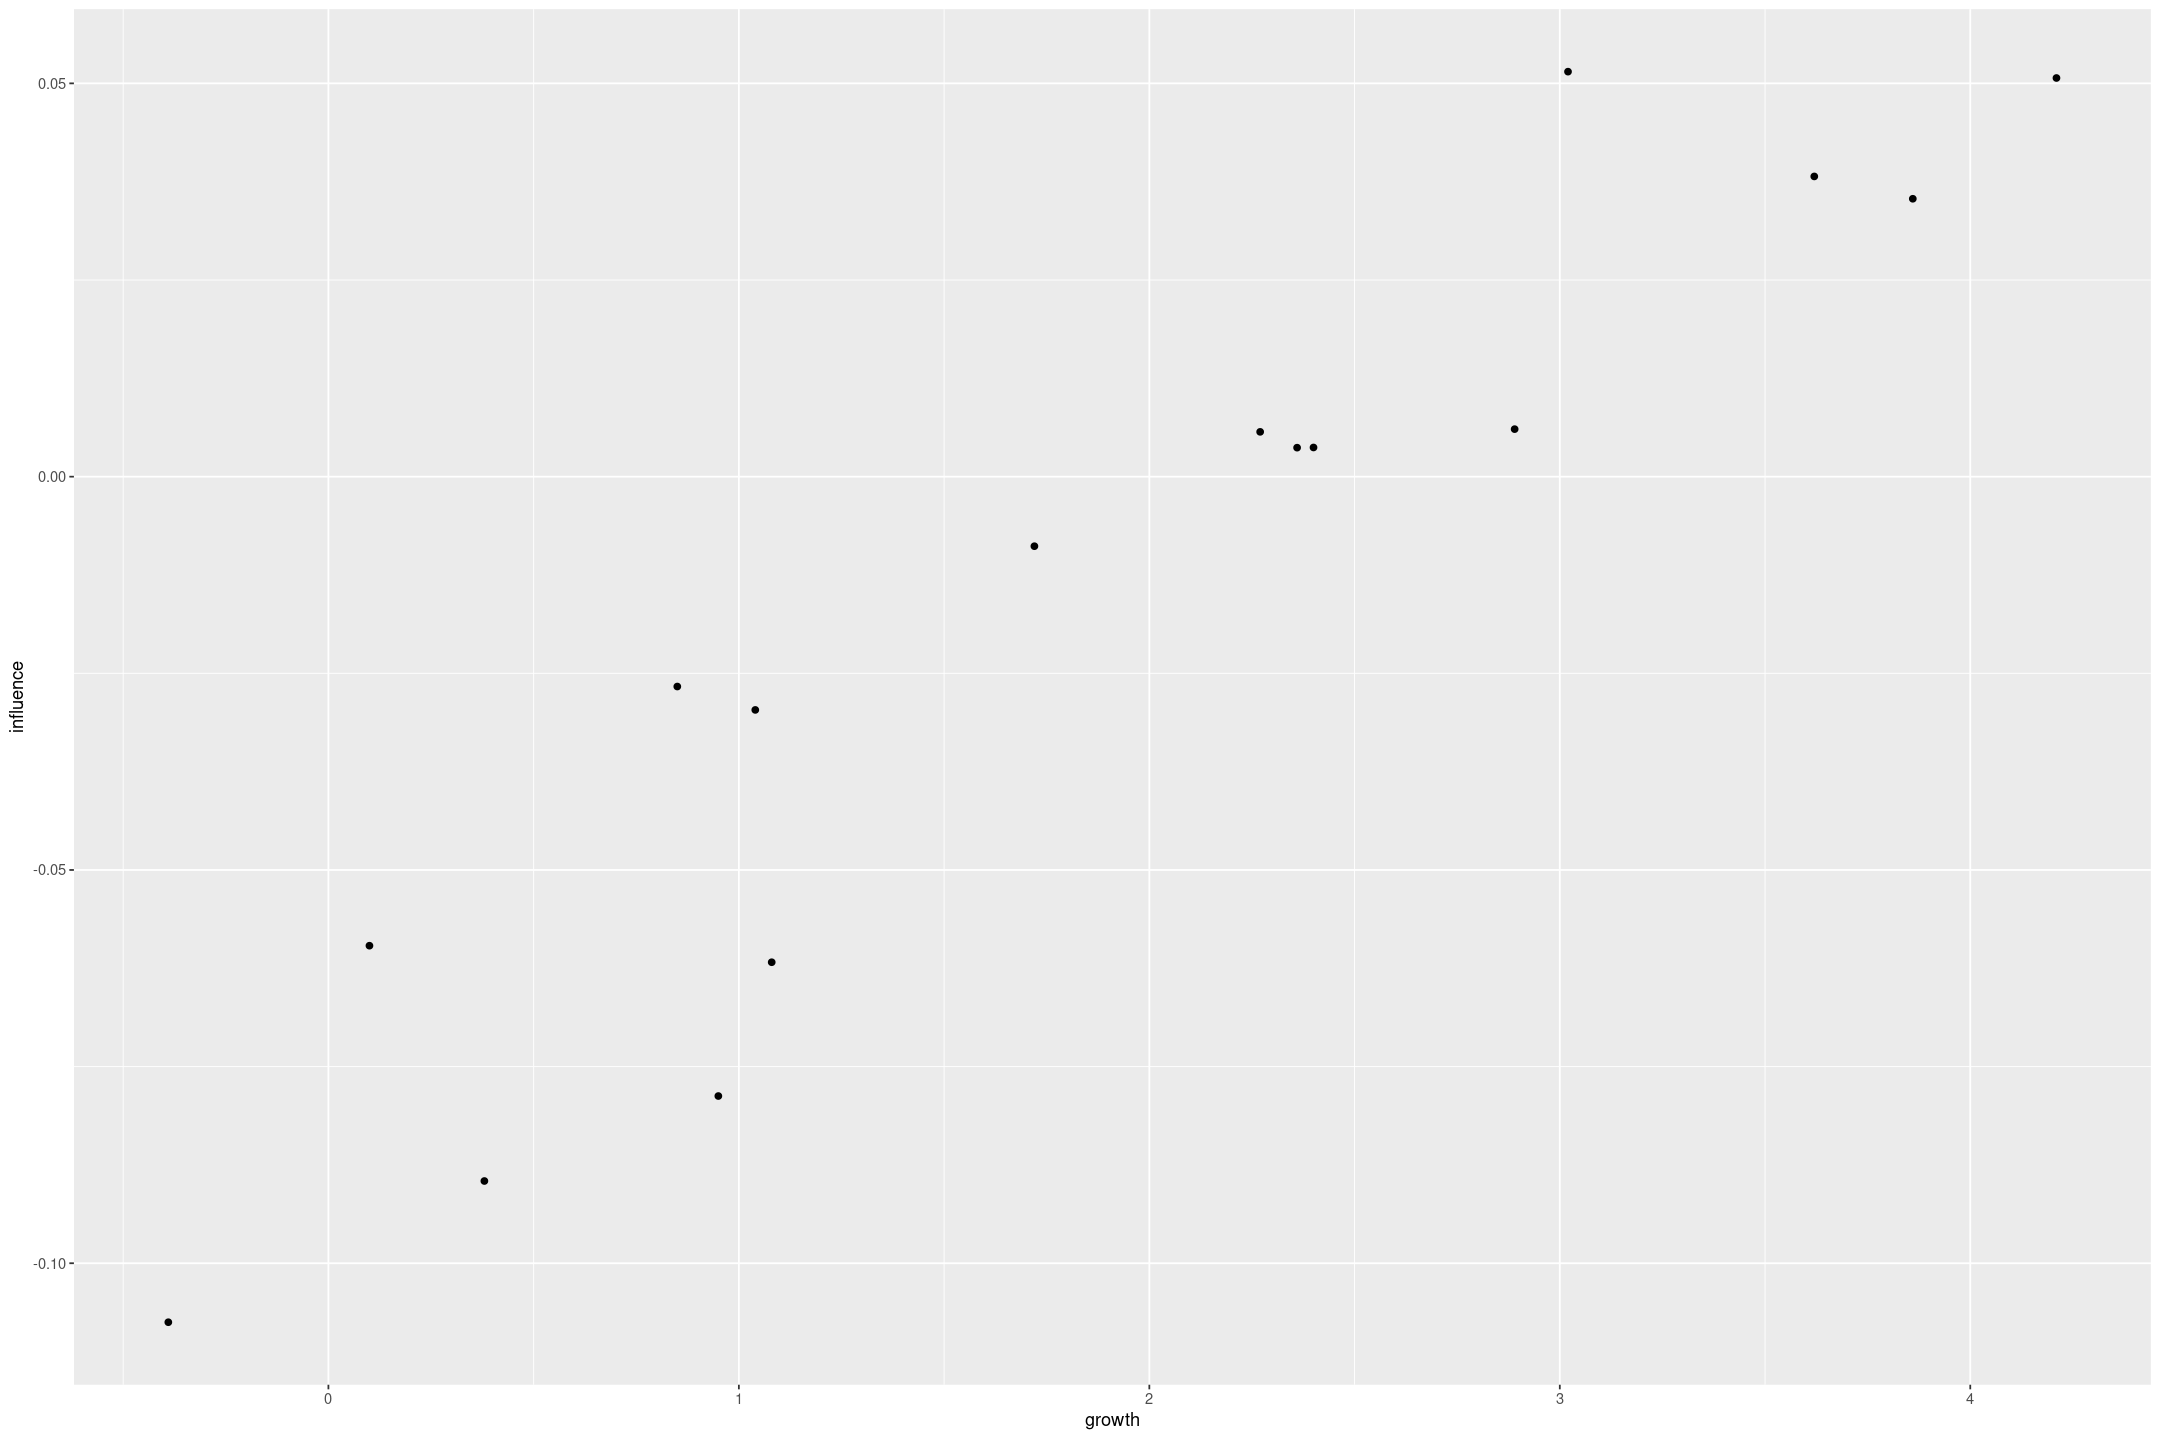

In [135]:
influence %>% gf_point(influence ~ growth)

# Least squares slope as a weighted average of individual slopes

a) Prove that the weighted average slope defined in equation (8.8) is equivalent to the least squares regression slope in equation (8.3).

Start with the weighted sum of all pairs of slopes, weighted by $(x_j-x_i)^2$.
Sum over all pairs; we can count each pair twice (x_i, x_j and x_j, x_i) because it cancels out between the numerator and the denominator.
The pairs containing the same point twice contribute nothing to the sum, because the weight is 0.


$$ \rm{slope\ weighted\ average} =  \frac{\sum_{i, j}(x_j - x_i)^2 \frac{y_j - y_i}{x_j - x_i}}{\sum_{i , j}(x_j-x_i)^2} $$

Then cancelling out the denominators in the top row gives:

$$ \rm{slope\ weighted\ average} =  \frac{\sum_{i, j}(x_j - x_i) (y_j - y_i)}{\sum_{i, j}(x_j-x_i)^2} $$

Start by expanding the top row, and reindex the terms:

$$ \begin{align}
\sum_{i, j}(x_j - x_i) (y_j - y_i)
& =  2 \sum_{i, j} x_i y_i - 2 \sum_{i, j} x_i y_j \\
& = 2N \sum_{i} x_i y_i - 2N \sum_{i} \bar{x} y_i \\
& = 2N \sum_{i} (x_i - \bar{x}) y_i
\end{align}$$

where on the second line we used the definition of the average $$ N \bar{x} = \sum_{i=1}^{N} x_i $$

The denominator can be expanded similarly (substituting y for x above) giving

$$ \sum_{i, j} (x_j - x_i)^2 = 2N \sum_{i} (x_i - \bar{x}) x_i $$

Notive that by the definition of the average $ \sum_{i=1}^{N} (x_i - \bar{x}) = 0 $, and so we can subtract the term $2N \bar{x}\sum_{i=1}^{N} (x_i - \bar{x}) = 0$ to get

$$ 
\begin{align}
\sum_{i, j} (x_j - x_i)^2 
& = 2N \sum_{i} (x_i - \bar{x}) x_i  \\
& = 2N \sum_{i} (x_i - \bar{x}) x_i - 2N \sum_{i=1}^{N} (x_i - \bar{x}) \bar{x} \\
& = 2N \sum_{i} (x_i - \bar{x})^2
\end{align}
$$

Substituting these into our weighted average equation gives:

$$ 
\begin{align}
\rm{slope\ weighted\ average} 
&=  \frac{\sum_{i, j}(x_j - x_i)^2 \frac{y_j - y_i}{x_j - x_i}}{\sum_{i , j}(x_j-x_i)^2} \\
&= \frac{2N \sum_{i} (x_i - \bar{x}) y_i}{2N \sum_{i} (x_i - \bar{x})^2} \\
& = \frac{\sum_{i} (x_i - \bar{x}) y_i}{\sum_{i} (x_i - \bar{x})^2}
\end{align}$$

Which is exactly the equation for the slope of the line that minimises the residual sum of squares.

b) Demonstrate how this works in a simple case with three data points, $(x, y) = (0,0), (4, 1), (5,5)$.

In [147]:
p1 = c(x=0,y=0)
p2 = c(x=4,y=1)
p3 = c(x=5,y=5)

slope <- function(p, q) (p[['y']] - q[['y']]) / (p[['x']] - q[['x']])

slope_weight <- function(p, q) (p[['x']] - q[['x']])^2

We have to be a little careful about how we handle infinite slopes.
Let's just remove them from the sum since the weight should set them to 0.

In [151]:
slope_weight(p1,p1)

[1] 0

In [150]:
slope(p1,p1) * slope_weight(p1,p1)

[1] NaN

Calculating the sum of weighted slopes

In [158]:
points = list(p1, p2, p3)

sum_weighted_slopes = 0
total_weight = 0
for (point1 in points) {
    for (point2 in points) {
        weight = slope_weight(point1, point2)
        if (weight > 0) {
            total_weight = total_weight + weight
            sum_weighted_slopes = sum_weighted_slopes + weight * slope(point1, point2)
        }
    }
}
sum_weighted_slopes / total_weight

[1] 0.7857143

Calculating the traditional way gives the same answer

In [159]:
xs = c(p1[['x']], p2[['x']], p3[['x']])
ys = c(p1[['y']], p2[['y']], p3[['y']])

sum((xs - mean(xs)) * ys) / sum((xs-mean(xs))^2)

[1] 0.7857143

# Comparing `lm` and `stan_glm`
Use simulated data to compare least squares estimation to default Bayesian regression.

a) Simulate 100 data points from the model, $y = 2 + 3x + \rm{error}$, with predictors x drawn from a uniform distribution from 0 to 20, and with independent errors drawn from the normal distribution with mean 0 and standard deviation 5.
Fit the regression of y on x data using `lm` and `stan_glm` (using its default settings) and check that the two programs give nearly identical results.

In [163]:
x <- runif(100, 0, 20)
y <- 2 + 3 * x + rnorm(100, 0, 5)

fake_data <- data.frame(x=x, y=y)

In [164]:
fake_lm <- lm(y ~ x, data=fake_data)

In [167]:
fake_lm


Call:
lm(formula = y ~ x, data = fake_data)

Coefficients:
(Intercept)            x  
      2.361        3.042  


In [171]:
sigma(fake_lm)

[1] 4.465626

In [165]:
fake_stan_lm <- stan_glm(y~x, data=fake_data, refresh=0)

Rounded to 1 decimal place the intercept, slope and standard deviation are the same.

In [169]:
fake_stan_lm

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 2.4    0.9   
x           3.0    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 4.5    0.3   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

b) Plot the simulated data and the two fitted regression lines.

The two lines are almost indistinguishable

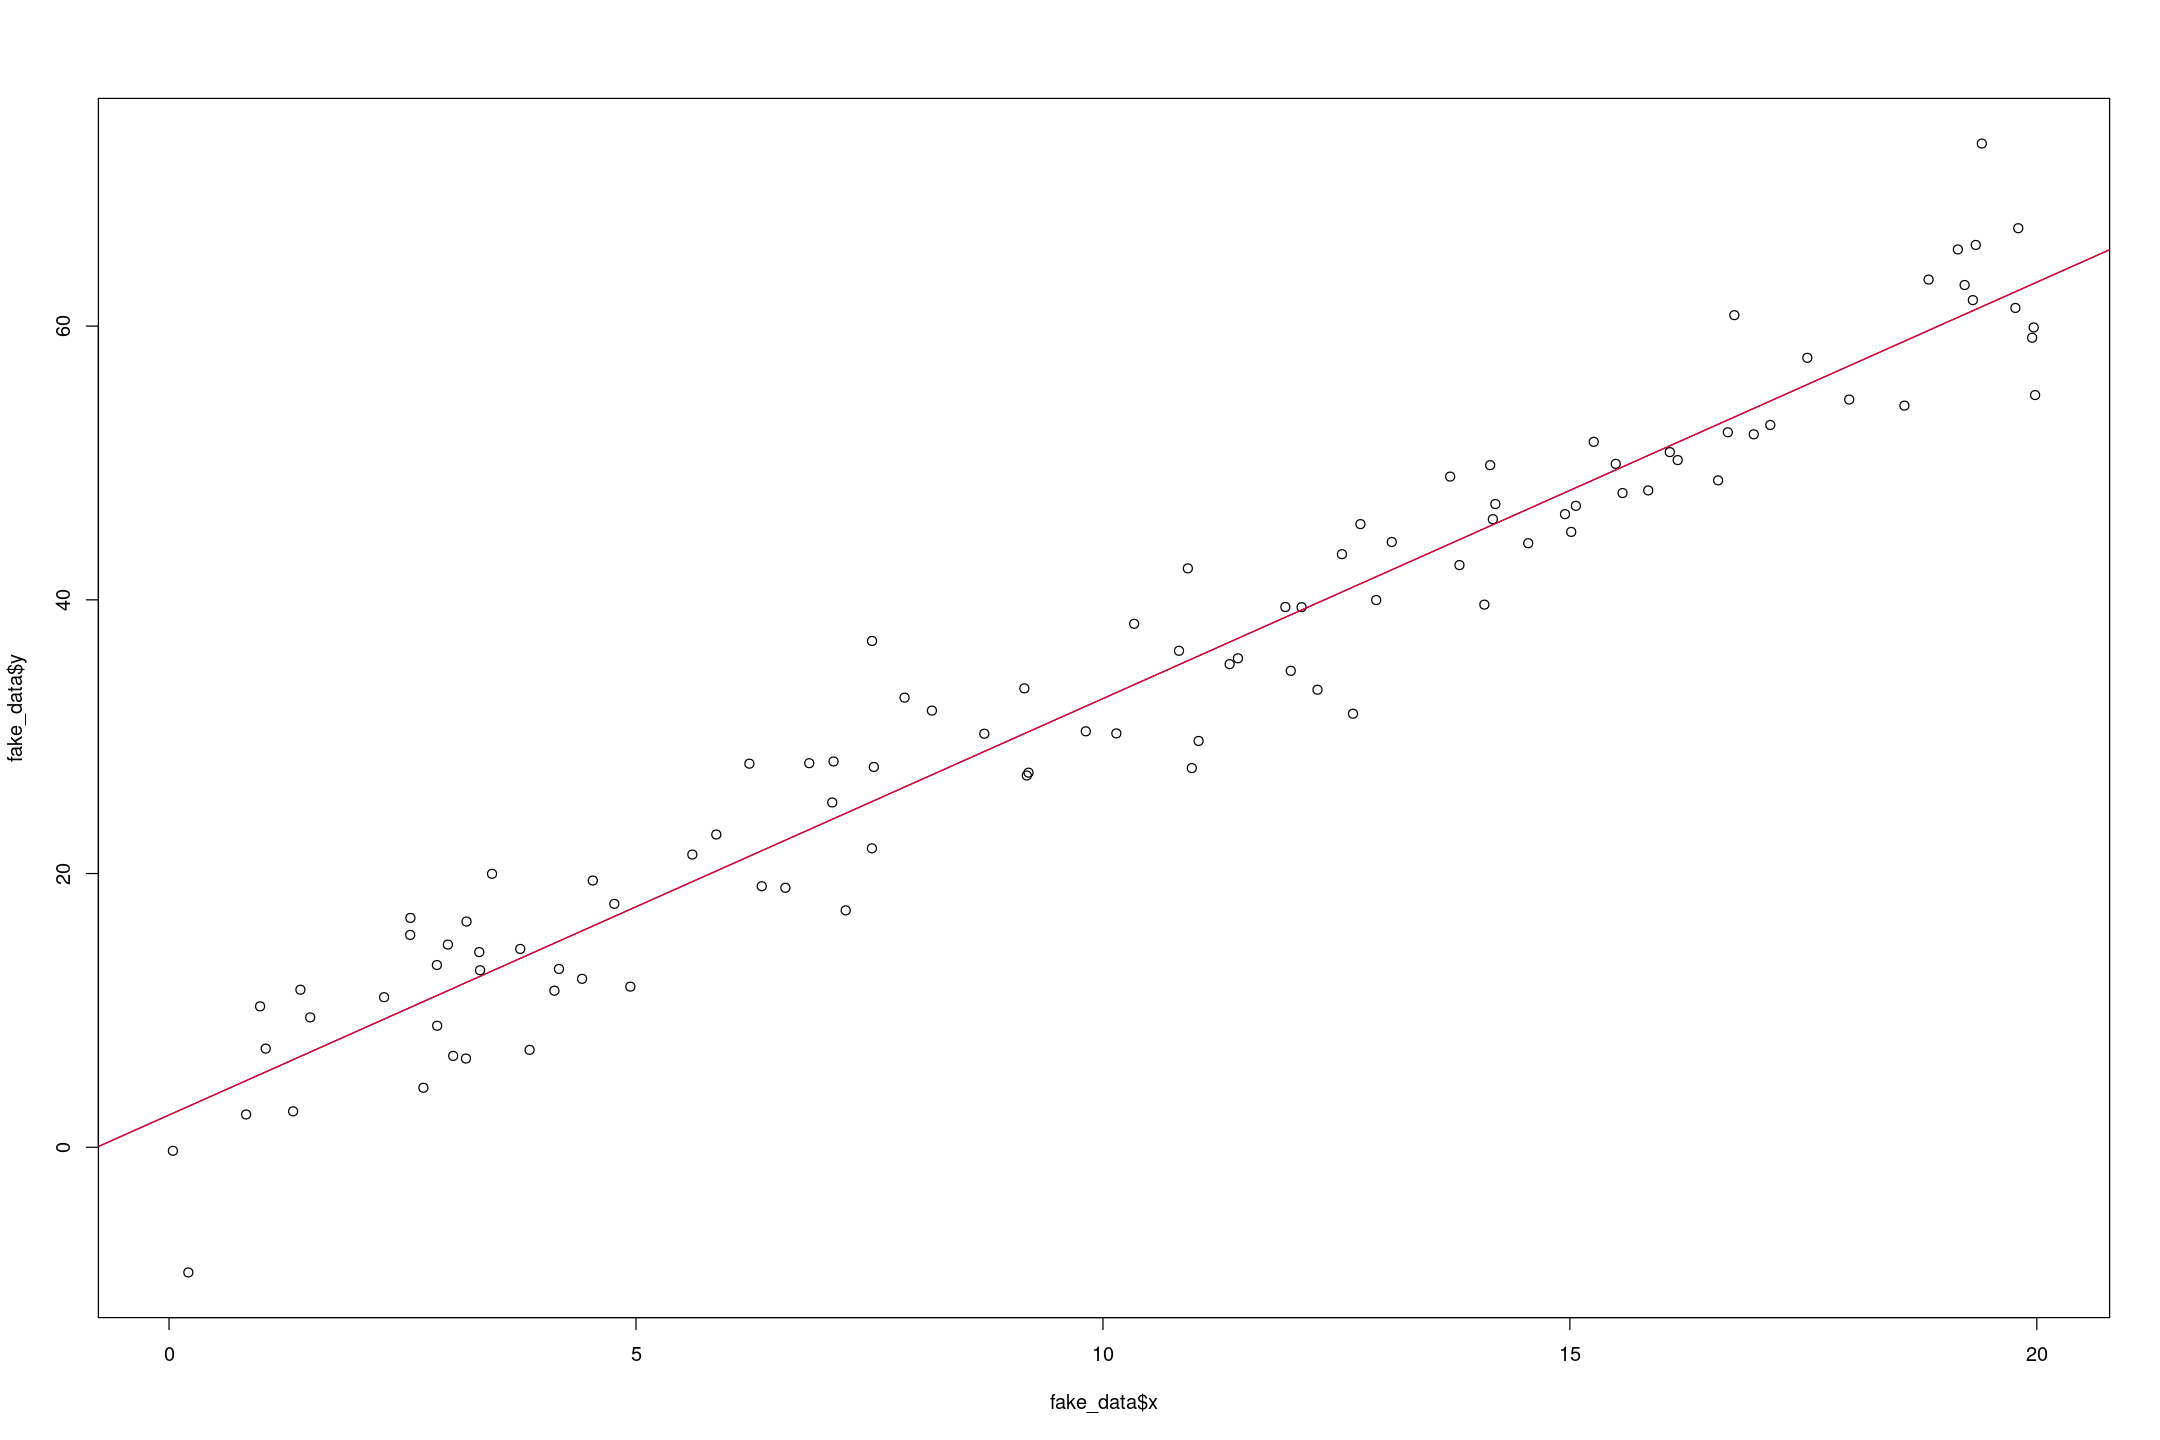

In [176]:
fake_intercept = coef(fake_lm)[['(Intercept)']]
fake_slope = coef(fake_lm)[['x']]

fake_stan_intercept = coef(fake_stan_lm)[['(Intercept)']]
fake_stan_slope = coef(fake_stan_lm)[['x']]

plot(fake_data$x, fake_data$y)
abline(fake_intercept, fake_slope, col="blue")
abline(fake_stan_intercept, fake_stan_slope, col="red")

c) Repeat the two steps above but try to create conditions for your simulation so that `lm` and `stan_glm` give much different results.

The default prior in `stan_glm` is weak; we expect to see it most strongly when the evidence for the regression is weak.

Let's pick some small, noisy data.

In [258]:
x <- runif(4, 0, 20)
y <- 2 - 1 * x + rnorm(4, 0, 50)
fake_data <- data.frame(x=x, y=y)

In [259]:
fake_lm <- lm(y ~ x, data=fake_data)

In [260]:
fake_lm


Call:
lm(formula = y ~ x, data = fake_data)

Coefficients:
(Intercept)            x  
     53.672       -3.118  


In [261]:
fake_stan_lm <- stan_glm(y~x, data=fake_data, refresh=0)
fake_stan_lm

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 4
 predictors:   2
------
            Median MAD_SD
(Intercept) 48.8   48.0  
x           -2.8    3.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 38.8   16.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

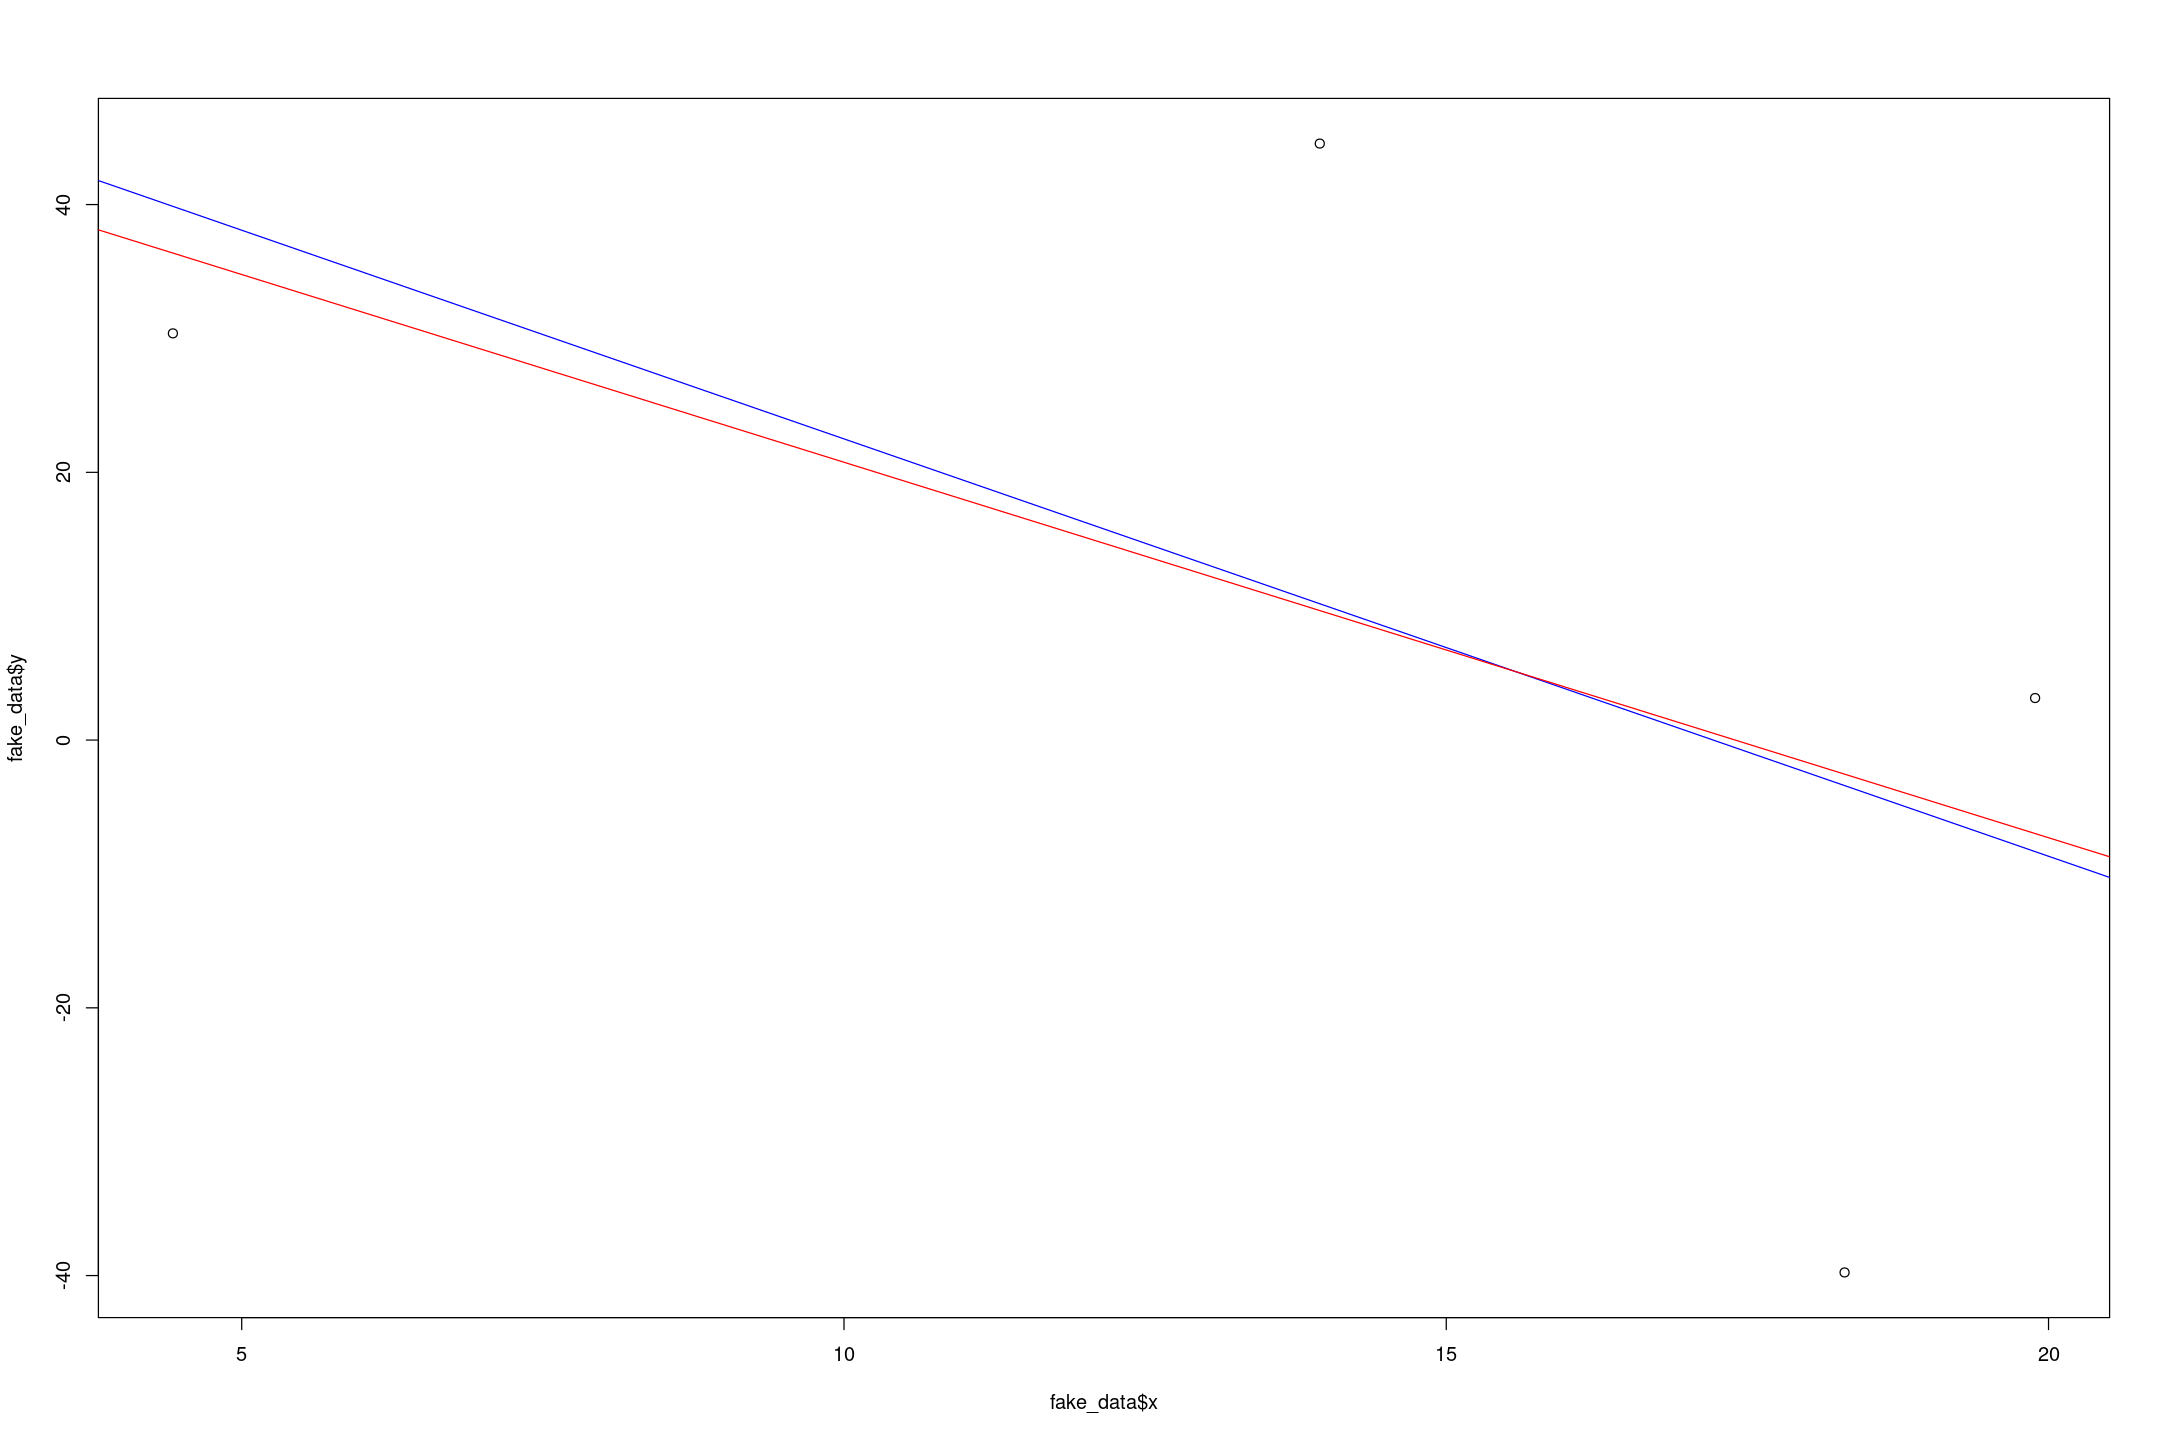

In [262]:
fake_intercept = coef(fake_lm)[['(Intercept)']]
fake_slope = coef(fake_lm)[['x']]

fake_stan_intercept = coef(fake_stan_lm)[['(Intercept)']]
fake_stan_slope = coef(fake_stan_lm)[['x']]

plot(fake_data$x, fake_data$y)
abline(fake_intercept, fake_slope, col="blue")
abline(fake_stan_intercept, fake_stan_slope, col="red")

# Leave-one-out cross validation

As discussed in the context of (8.5), the root mean square of residuals, $ \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - (\hat{a} + \hat{b}x_i))^2}$, is an underestimate of the error of the standard deviation $\sigma$ of the regression model, because of overfitting, that the parameters a and b are estimated from the same n data points as are being used to computer the residuals.

*Cross valiation*, which we disucss in detail in Section 11.8, is an alternative approach to assessing predictive error that avoids some of the problems of overfitting. The simplest version of cross validation is the leave-one-out approach, in which the model is fit n times, in each case excluding one data point, fitting the model to the remaining $ n-1$ data points, and using this fitted model to predict the held-out observation:

* For $ i = 1, \ldots, n$:

   - Fit the model $ y = a + bx + \rm{error}$ to the $ n- 1$ data points $(x, y)_j,\,j \neq i$. Label the esitmated regression coefficients as $\hat{a}_{-i}, \hat{b}_{-i}$
   - Compute the cross-validated residual, $r_i^{\rm{CV}} = y_i - (\hat{a}_{-i} + \hat{b}_{-i} x_i)$
   
* Compute the estimate $\hat{\sigma}^{\rm{CV}} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} r_i^2}$

a) Perform the above steps for the elections model from Section 7.1.

In [266]:
election_model <- stan_glm(vote ~ growth, data=hibbs, refresh=0)
election_model

stan_glm
 family:       gaussian [identity]
 formula:      vote ~ growth
 observations: 16
 predictors:   2
------
            Median MAD_SD
(Intercept) 46.3    1.6  
growth       3.1    0.7  

Auxiliary parameter(s):
      Median MAD_SD
sigma 3.9    0.7   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [279]:
election_a <- coef(election_model)[['(Intercept)']]
election_b <- coef(election_model)[['growth']]
c(election_a, election_b)

[1] 46.254787  3.051223

Calculate the fit for removing each row

In [313]:
loo_election = tibble(data=purrr::map(seq(1,nrow(hibbs)), ~hibbs[-.,]),
          growth = hibbs$growth,
          vote = hibbs$vote) %>% 
rowwise() %>% mutate(model=list(stan_glm(vote ~ growth, data=data, refresh=0))) %>% 
rowwise() %>% mutate(slope = coef(model)[['growth']]) %>%
rowwise() %>% mutate(intercept = coef(model)[['(Intercept)']])

loo_election

data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1  1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
2  1952.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
3  1952.00, 1956.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
4  1952.00, 1956.00, 1960.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
5  1952.00, 1956.00, 1960.00, 1964.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
6  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00  
7  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 4

In [314]:
loo_election <- loo_election %>% mutate(resid_cv = vote - (intercept + slope * growth))
loo_election

data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1  1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 5.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 16.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
2  1952.00, 1960.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 11.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 8.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
3  1952.00, 1956.00, 1964.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 9.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 7.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
4  1952.00, 1956.00, 1960.00, 1968.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 8.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 12.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00
5  1952.00, 1956.00, 1960.00, 1964.00, 1972.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 11.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 10.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00 
6  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1976.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 14.00, 5.00, 11.00, 9.00, 8.00, 6.00, 3.00, 13.00, 2.00, 2.00, 4.00, 7.00, 1.00, 10.00, 12.00, 6.00, 16.00, 8.00, 7.00, 12.00, 2.00, 14.00, 11.00, 5.00, 3.00, 4.00, 1.00, 9.00, 13.00, 15.00  
7  1952.00, 1956.00, 1960.00, 1964.00, 1968.00, 1972.00, 1980.00, 1984.00, 1988.00, 1992.00, 1996.00, 2000.00, 2004.00, 2008.00, 2012.00, 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 4

Looking at the leave-one-out fitted lines.

The leave-one-out residuals are larger the further we are from the main trend line.

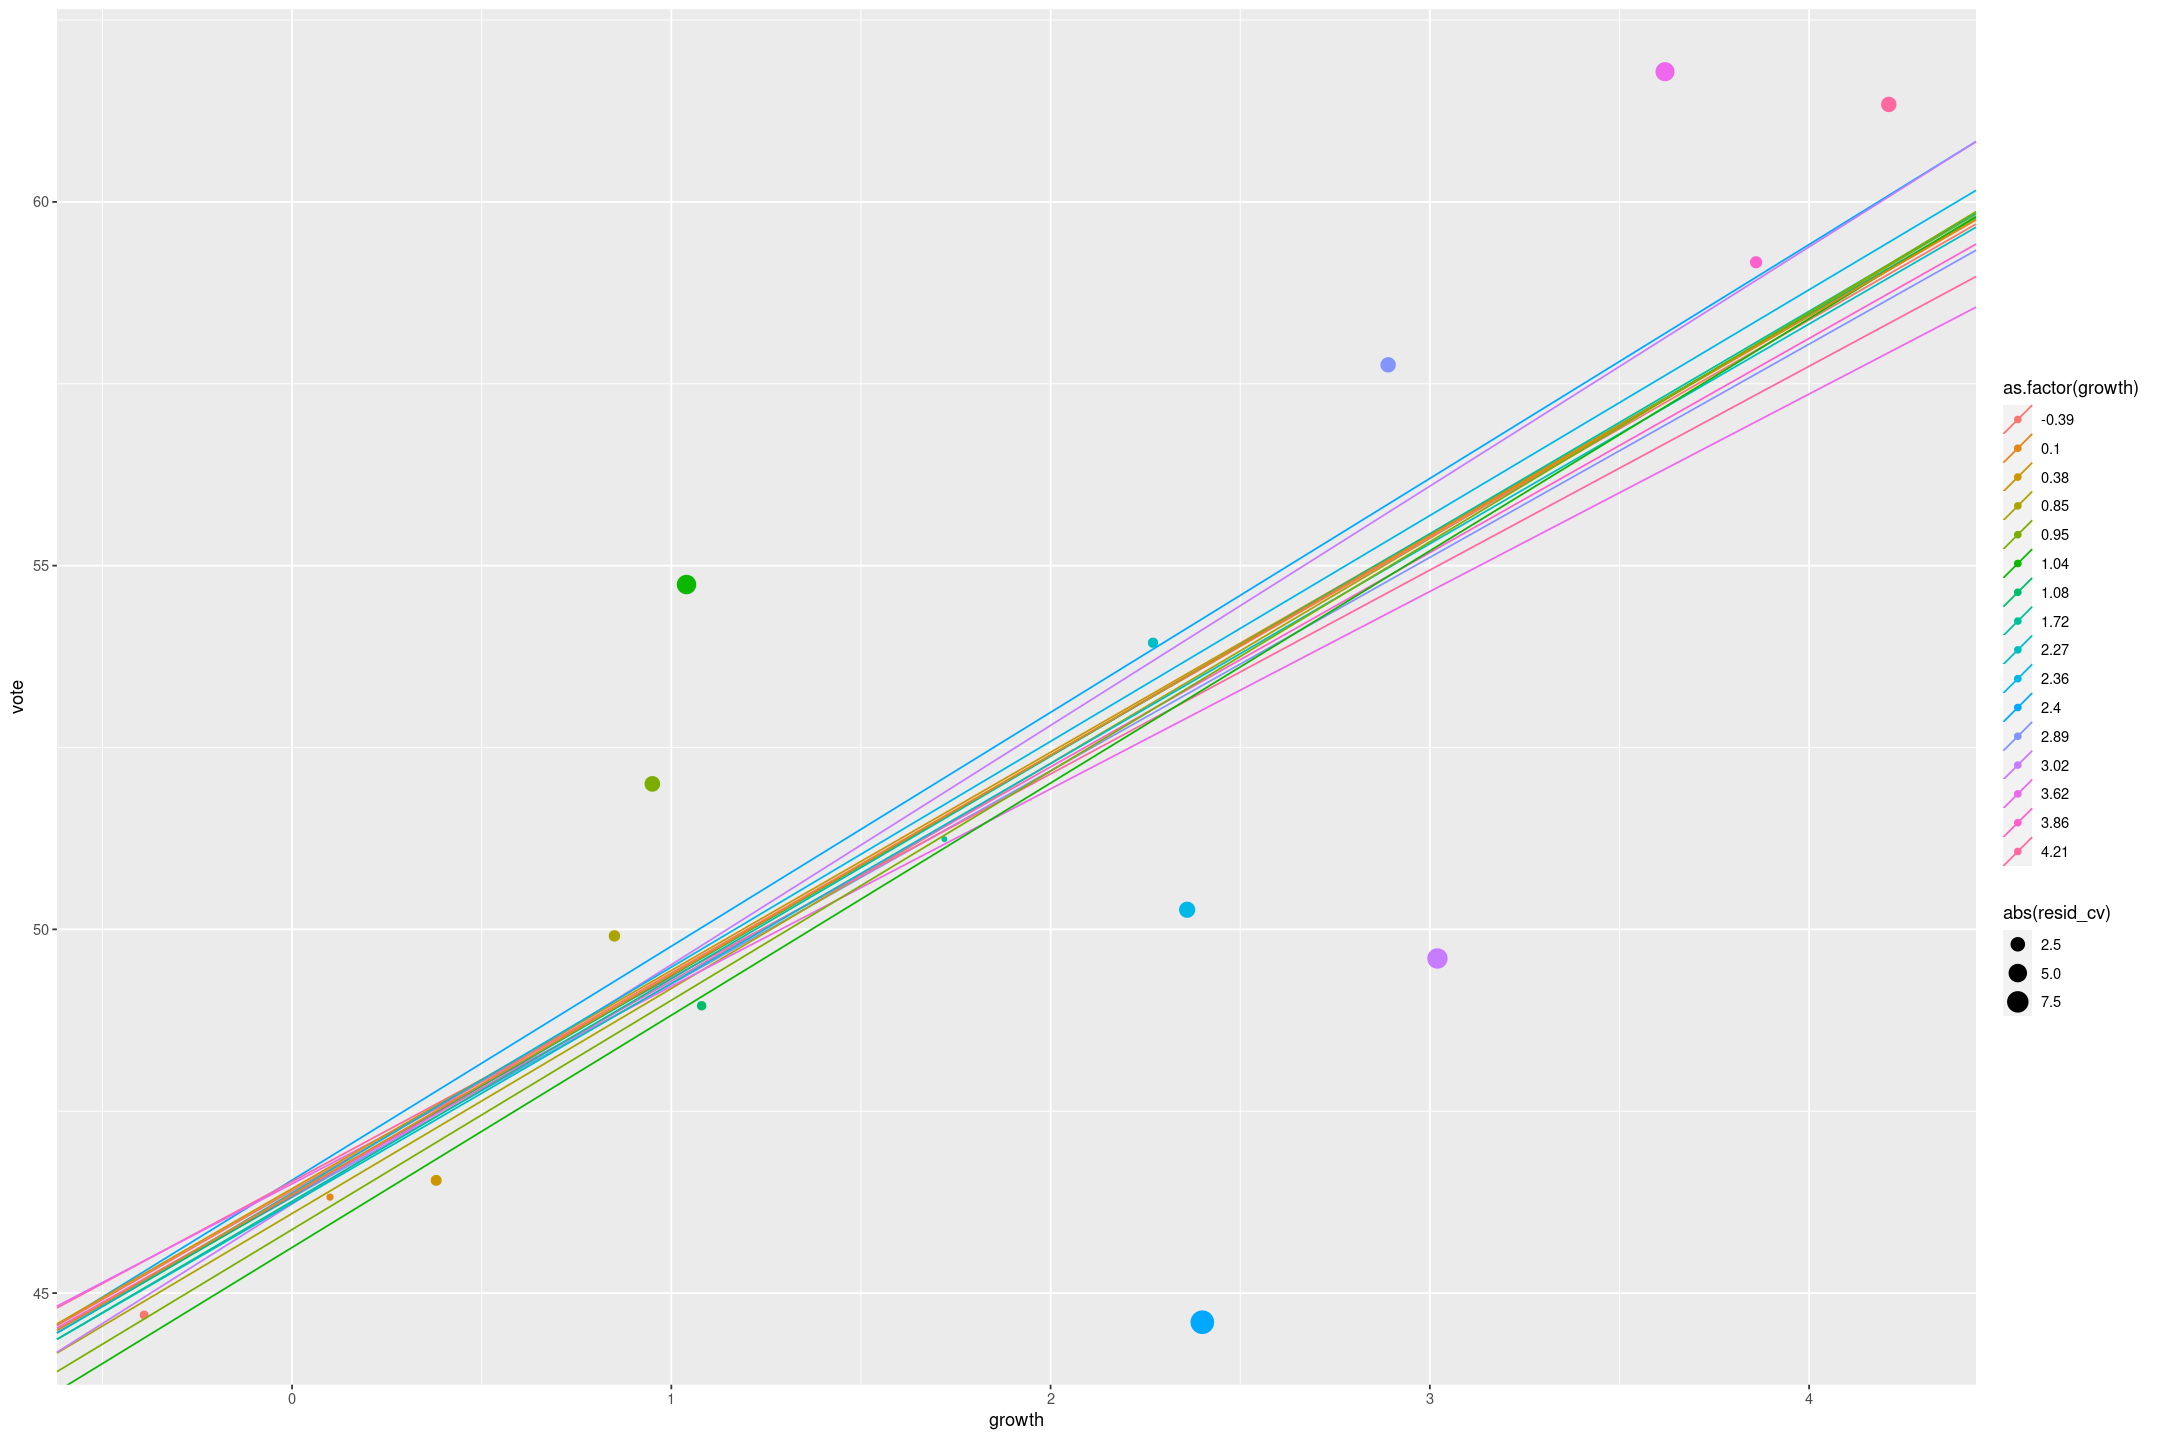

In [315]:
loo_election %>% 
gf_point(vote ~ growth, colour=~as.factor(growth), size=~abs(resid_cv)) %>% 
gf_abline(slope=~slope, intercept=~intercept, colour=~as.factor(growth))

In [318]:
sigma_cv = sqrt(mean(loo_election$resid_cv^2))

Compare three estimates of $\sigma$:

1. the estimate produced by `stan_glm`
2. $\sqrt{\frac{1}{n-2}\sum_{i=1}^{n} \left(y_i - (\hat{a} + \hat{b}x_i)\right)^2}$
3. $\hat{\sigma}^{\rm{CV}} = \sqrt{\frac{1}{n}\sum_{i=1}^{n} r_i^2}$

In [320]:
sigma(election_model)

[1] 3.895546

In [325]:
election_residuals = hibbs$vote - (election_a + election_b * hibbs$growth)
sigma_adjusted = sqrt(sum(election_residuals^2)/(nrow(hibbs)-2))
sigma_adjusted

[1] 3.763328

In [323]:
sigma_cv

[1] 3.917864

b) Discuss any differences between the three esitmates

The leave-one-out cross-validated standard deviation is the largest, followed by the `stan_glm` estimate, followed by the adjusted formula.

Taking the cross-validated as the gold standard, because it really does give an indication of the error on new data, it seems that `stan_glm` estimate is closer to the standard error than the standard deviation formula adjusted for degrees of freedom (which is again closer than the the unadjusted standard deviation).

# Leave-one-out cross validation

Create a fake dataset $(x,y)_i,\, i=1,\ldots,n$, in such a way that there is a big difference between $\hat{\sigma}^{\rm{CV}}$ as defined in the period exercise, and the estimated residual deviation $\sqrt{\frac{1}{n-2}\sum_{i=1}^{n} \left(y_i - (\hat{a} + \hat{b}x_i)\right)^2}$.
Explain what you did to create this discrepancy.

## Generating the data

Let's use the outlier data from [Question 4](#Least-squares-and-least-abolute-deviation).

Intuitively we know the outlier changes the slope of the line a lot and so will create a very difference fit. For this reason I expect the $\hat{\sigma}^{\rm{CV}}$ to be much larger

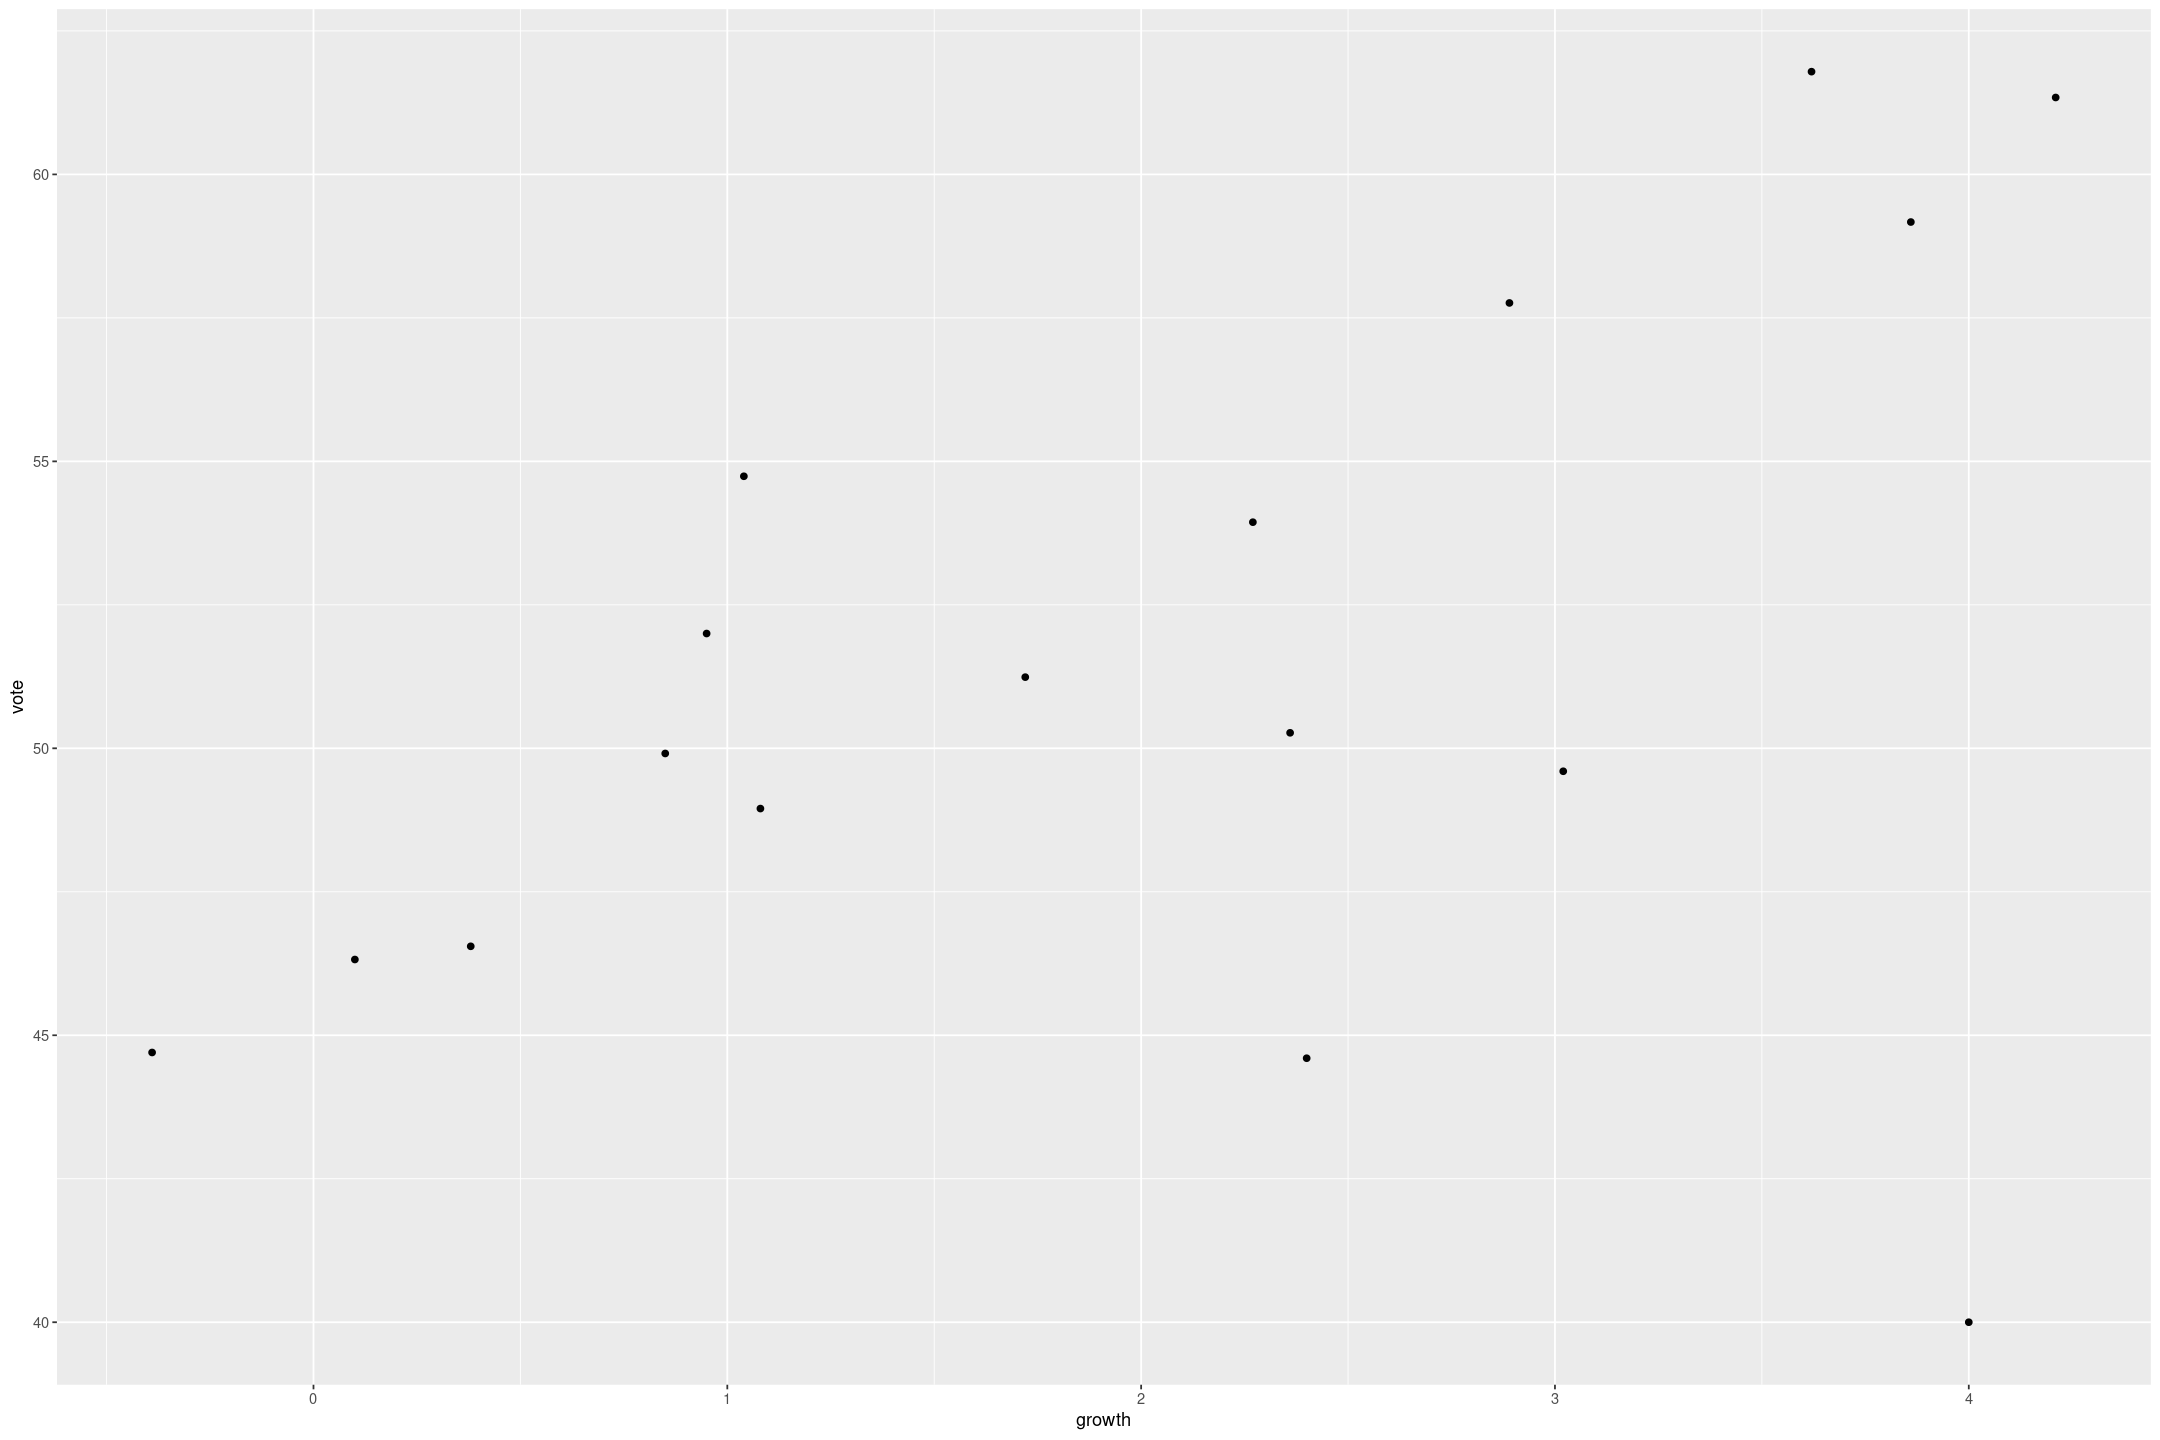

In [327]:
hibbs_outlier = tibble(growth = hibbs_outlier_growth, vote = hibbs_outlier_vote)
gf_point(hibbs_outlier, vote ~ growth)

## Generating the data

In [332]:
loo_outlier = tibble(data=purrr::map(seq(1,nrow(hibbs_outlier)), ~hibbs_outlier[-.,]),
          growth = hibbs_outlier$growth,
          vote = hibbs_outlier$vote) %>% 
rowwise() %>% mutate(model=list(stan_glm(vote ~ growth, data=data, refresh=0))) %>% 
rowwise() %>% mutate(slope = coef(model)[['growth']]) %>%
rowwise() %>% mutate(intercept = coef(model)[['(Intercept)']]) %>%
mutate(resid_cv = vote - (intercept + slope * growth))

loo_outlier %>% arrange(desc(abs(resid_cv)))

data                                                                                                                                                                                                           
1  2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00
2  2.40, 2.89, 0.85, 4.21, 3.02, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
3  2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
4  2.40, 2.89, 0.85, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
5  2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 50.27, 51.24, 46.32, 52.00, 40.00
6  2.40, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
7  2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
8  2.40, 2.89, 0.85, 4.21, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
9  2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 40.00
10 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00 
11 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
12 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
13 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 51.24, 46.32, 52.00, 40.00
14 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 52.00, 40.00
15 2.40, 2.89, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
16 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 1.72, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 51.24, 46.32, 52.00, 40.00
17 2.40, 2.89, 0.85, 4.21, 3.02, 3.62, 1.08, -0.39, 3.86, 2.27, 0.38, 1.04, 2.36, 0.10, 0.95, 4.00, 44.60, 57.76, 49.91, 61.34, 49.60, 61.79, 48.95, 44.70, 59.17, 53.94, 46.55, 54.74, 50.27, 46.32, 52.00, 40.00
   growth vote 
1   4.00  40.00
2   3.62  61.79
3   2.40  44.60
4   4.21  61.34
5   1.04  54.74
6   2.89  57.76
7   3.86  59.17
8   3.02  49.60
9   0.95  52.00
10 -0.39  44.70
11  2.27  53.94
12  0.38  46.

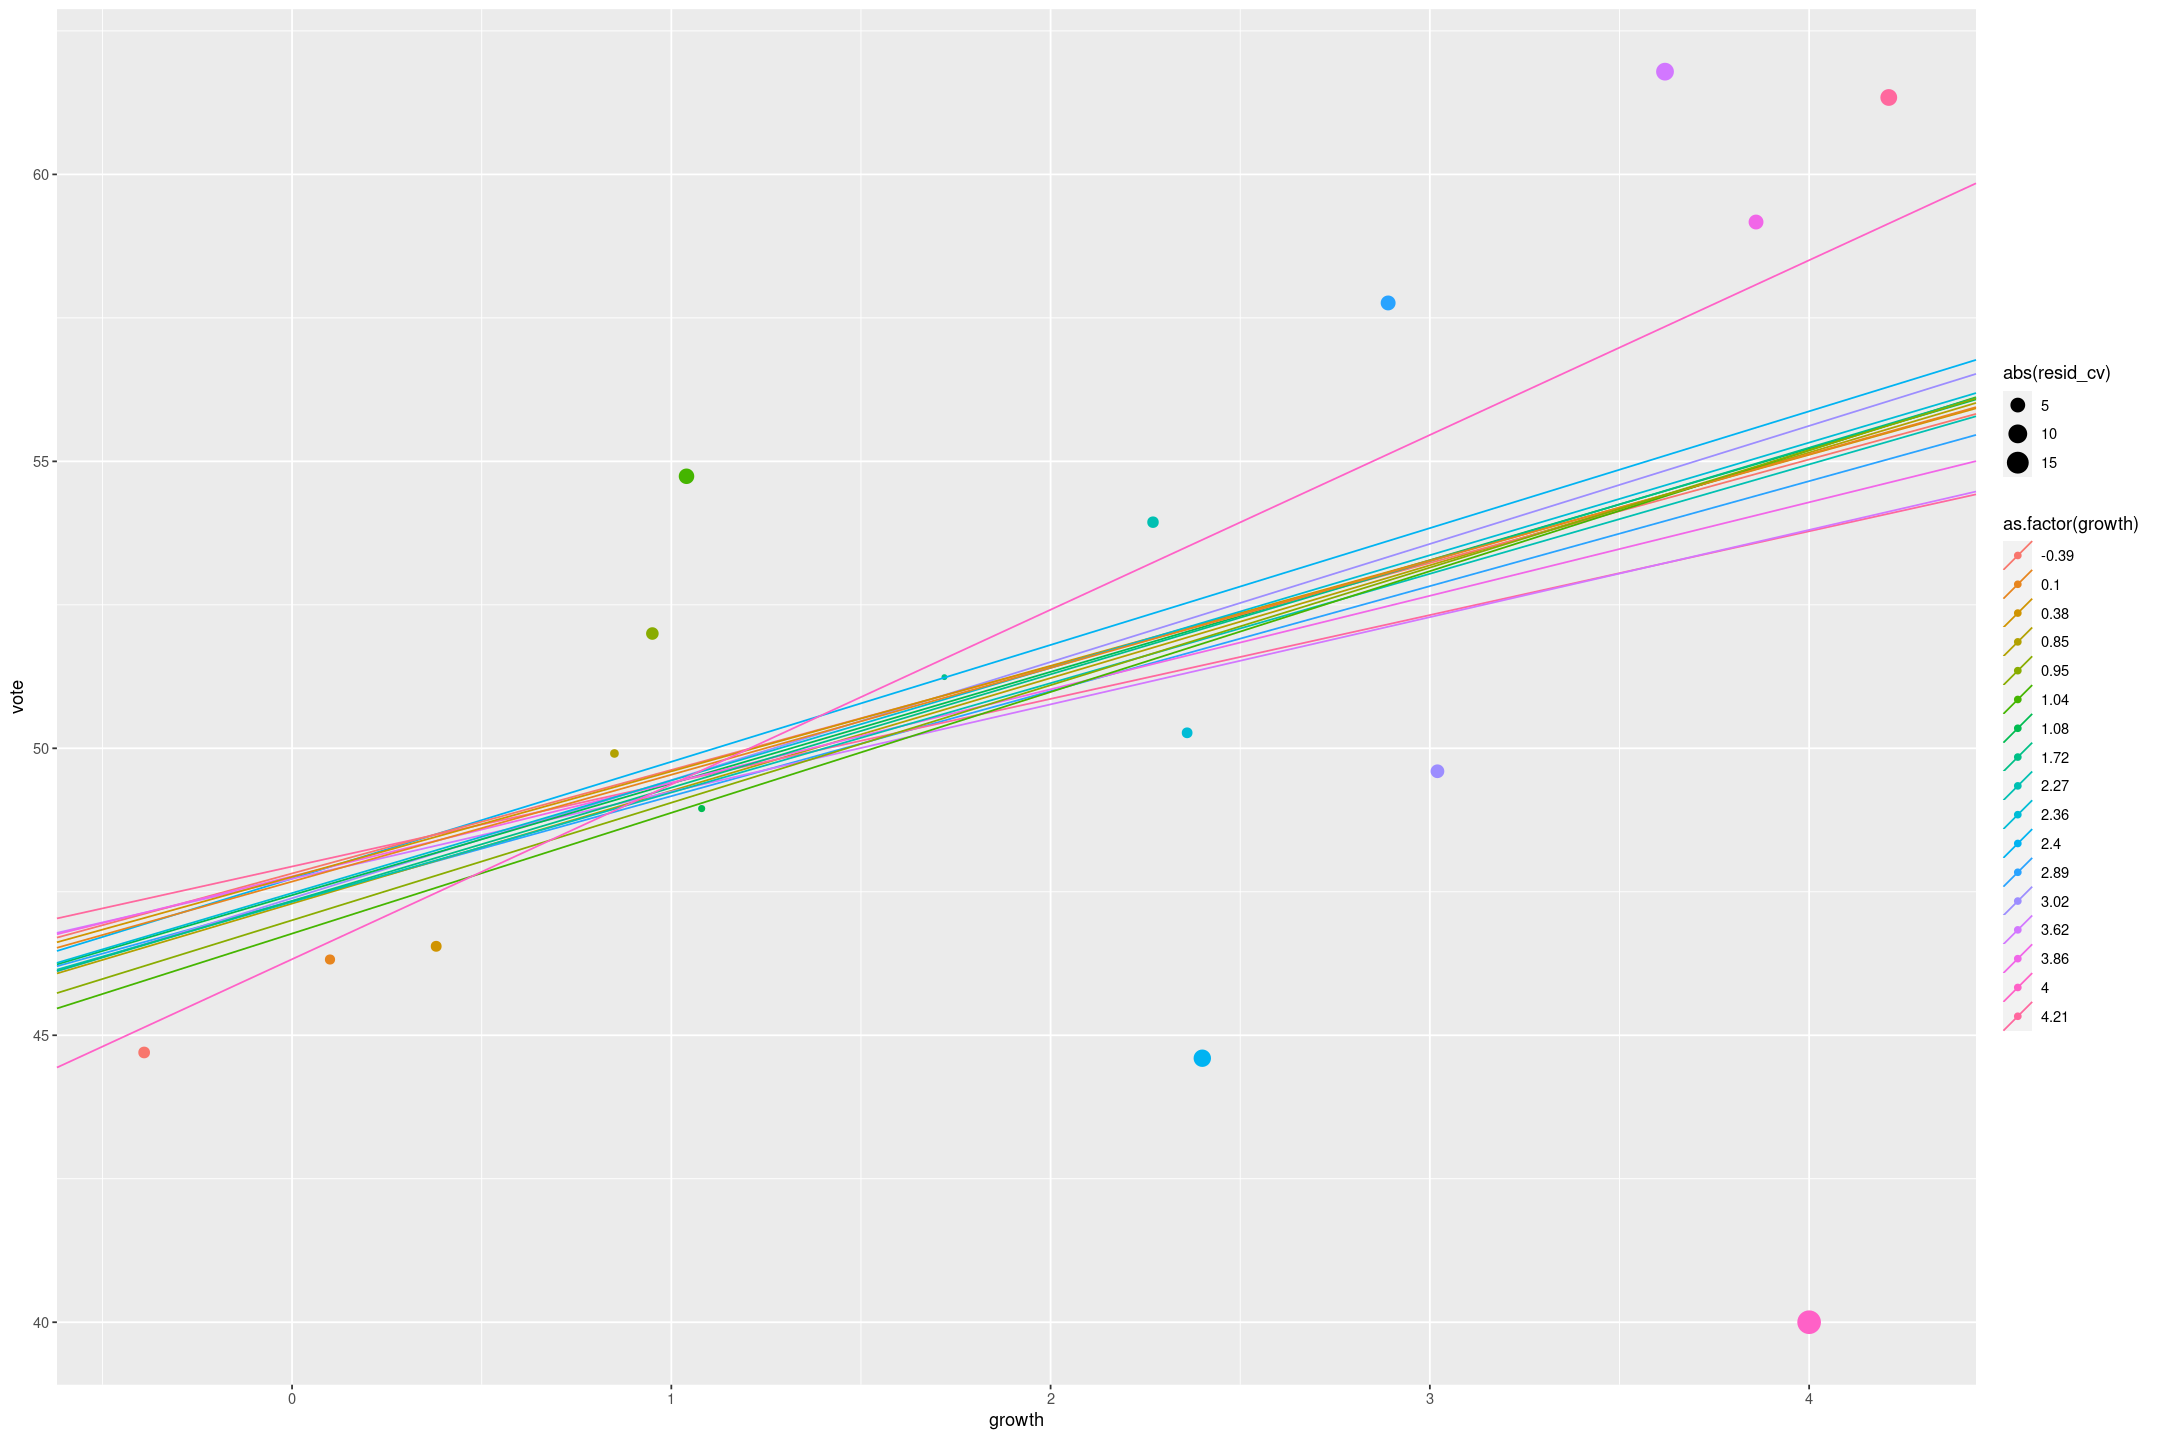

In [333]:
loo_outlier %>% 
gf_point(vote ~ growth, colour=~as.factor(growth), size=~abs(resid_cv)) %>% 
gf_abline(slope=~slope, intercept=~intercept, colour=~as.factor(growth))

## Calculating  $\hat{\sigma}^{\rm{CV}}$

In [335]:
sigma_outlier_cv = sqrt(mean(loo_outlier$resid_cv^2))
sigma_outlier_cv

[1] 6.258022

## Calculating $\sqrt{\frac{1}{n-2}\sum_{i=1}^{n} \left(y_i - (\hat{a} + \hat{b}x_i)\right)^2}$

As expected we get a much lower error estimate using the cross validation formula

In [336]:
outlier_fit = stan_glm(vote ~ growth, data=hibbs_outlier, refresh=0)

outlier_a = coef(outlier_fit)[['(Intercept)']]
outlier_b = coef(outlier_fit)[['growth']]

outlier_residuals = hibbs_outlier$vote - (outlier_a + outlier_b * hibbs_outlier$growth)
outlier_sigma_adjusted = sqrt(sum(outlier_residuals^2)/(nrow(hibbs_outlier)-2))
outlier_sigma_adjusted

[1] 5.656609